# 📊 Análise Diagnóstica - Camada RAW (Bronze)

**Objetivo:** Validação de ingestão, avaliação de qualidade e identificação de inconsistências.

Na camada Raw, os dados ainda estão:
- ❌ Sem limpeza completa
- ❌ Com valores ausentes
- ❌ Com categorias inconsistentes
- ✅ Próximos do formato original da fonte

**Os gráficos aqui não são "bonitos", são diagnósticos.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette('husl')

def find_project_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'Data Layer').exists():
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd())
RAW_PATH = PROJECT_ROOT / 'Data Layer' / 'raw'

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"RAW_PATH: {RAW_PATH}")

PROJECT_ROOT: c:\Users\David\Documents\UnB\SBD2\SBD2
RAW_PATH: c:\Users\David\Documents\UnB\SBD2\SBD2\Data Layer\raw


In [13]:
df_raw = pd.read_csv(RAW_PATH / 'data_raw.csv', low_memory=False)
print(f"Total de registros: {len(df_raw):,}")
print(f"Total de colunas: {len(df_raw.columns)}")

Total de registros: 50,000
Total de colunas: 28


---
## 1. 📈 Gráficos de Volume e Ingestão

**Objetivo:** Validar consistência do pipeline de ingestão e detectar anomalias na coleta de dados.

### 1.1 Volume de Crimes por Ano (Dados Brutos)

**Descrição:** Gráfico de barras mostrando a quantidade de crimes registrados por ano.

**Objetivo:** Detectar quedas ou picos inesperados causados por falhas de coleta ou problemas no pipeline de ingestão.

**Como interpretar:**
- 🔴 **Barras vermelhas:** Anos com volume abaixo do esperado (< média - 1σ) - possível falha na coleta
- 🟢 **Barras verdes:** Anos com volume acima do esperado (> média + 1σ) - verificar se é tendência real
- 🔵 **Barras azuis:** Anos dentro do intervalo normal
- **Linhas tracejadas:** Média e limites de ±1 desvio padrão

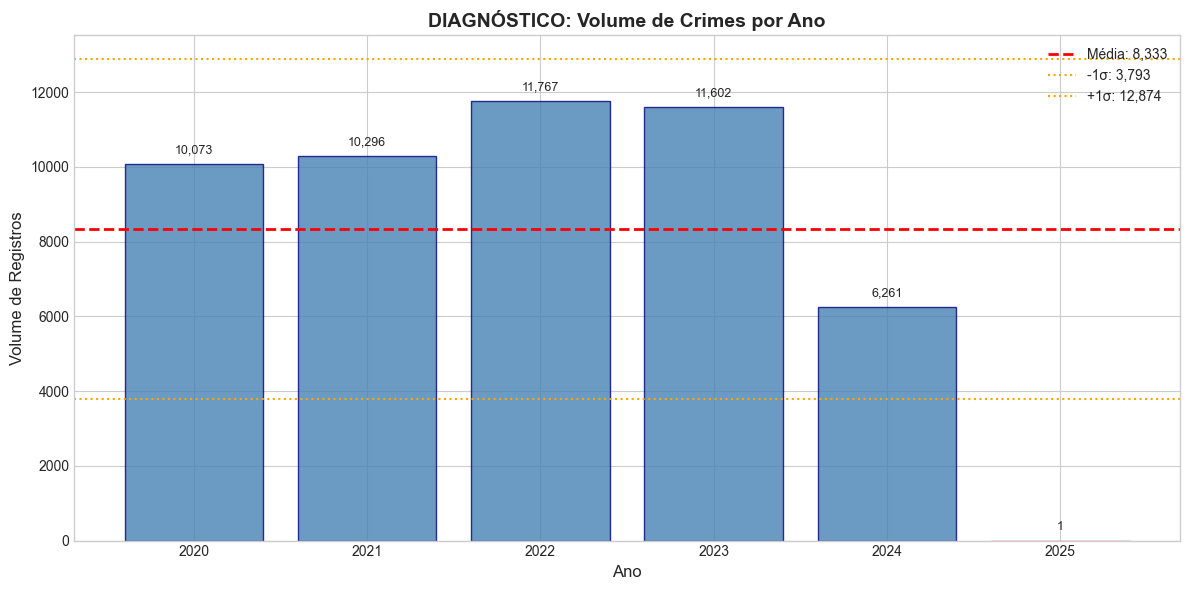


Média: 8,333 | Desvio: 4,540
Anos anômalos: [2025]


In [14]:
df_raw['DATE OCC'] = pd.to_datetime(df_raw['DATE OCC'], errors='coerce')
df_raw['Year'] = df_raw['DATE OCC'].dt.year
yearly_counts = df_raw['Year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(yearly_counts.index.astype(str), yearly_counts.values, color='steelblue', edgecolor='navy', alpha=0.8)

mean_vol = yearly_counts.mean()
std_vol = yearly_counts.std()
for i, (year, count) in enumerate(yearly_counts.items()):
    if count < mean_vol - std_vol:
        bars[i].set_color('red')
    elif count > mean_vol + std_vol:
        bars[i].set_color('green')

ax.axhline(y=mean_vol, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_vol:,.0f}')
ax.axhline(y=mean_vol - std_vol, color='orange', linestyle=':', label=f'-1σ: {mean_vol - std_vol:,.0f}')
ax.axhline(y=mean_vol + std_vol, color='orange', linestyle=':', label=f'+1σ: {mean_vol + std_vol:,.0f}')

ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Volume de Registros', fontsize=12)
ax.set_title('DIAGNÓSTICO: Volume de Crimes por Ano', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')

for i, (year, count) in enumerate(yearly_counts.items()):
    ax.text(i, count + 200, f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nMédia: {mean_vol:,.0f} | Desvio: {std_vol:,.0f}")
print(f"Anos anômalos: {list(yearly_counts[yearly_counts < mean_vol - std_vol].index)}")

### 1.2 Série Temporal de Ingestão Mensal

**Descrição:** Gráfico de linha mostrando o volume de registros ingeridos mês a mês.

**Objetivo:** Identificar gaps de ingestão, picos anômalos ou períodos com falhas no pipeline.

**Como interpretar:**
- 🔴 **Pontos vermelhos:** Meses com volume fora de ±2 desvios padrão - requerem investigação
- **Área sombreada:** Representa o volume total ao longo do tempo
- **Linha tracejada vermelha:** Média mensal esperada
- **Quedas bruscas:** Podem indicar problemas na fonte de dados ou no processo de ETL

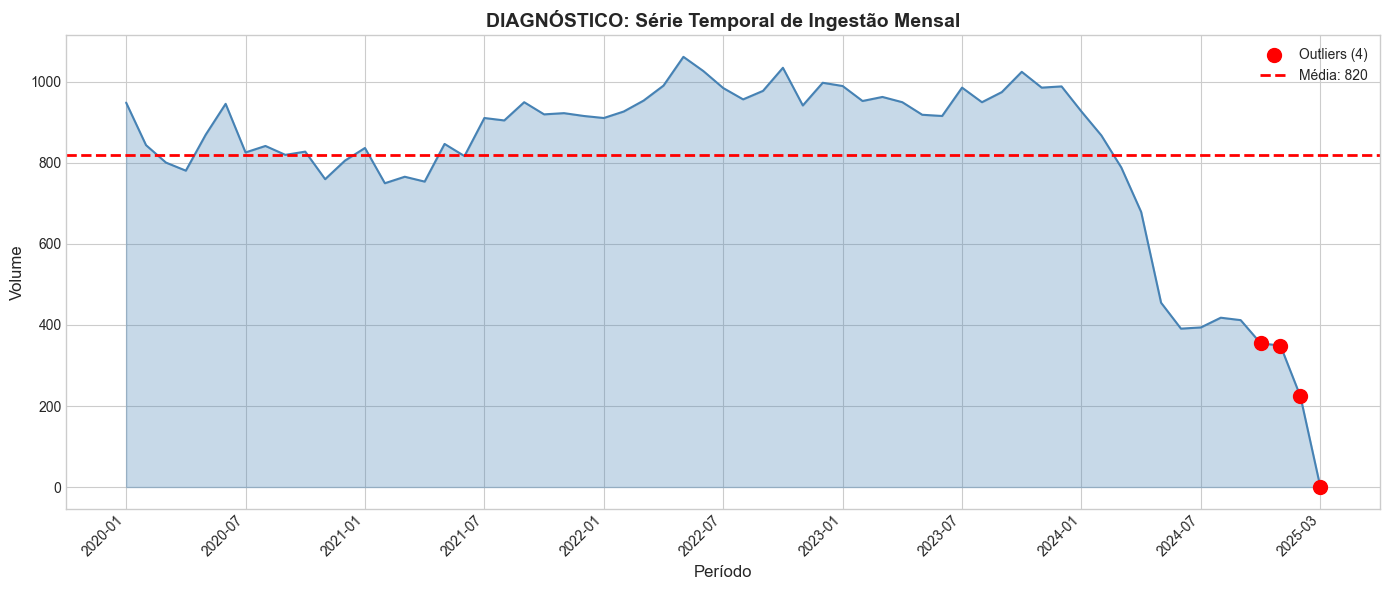


Meses anômalos: 4


In [15]:
df_raw['YearMonth'] = df_raw['DATE OCC'].dt.to_period('M')
monthly_counts = df_raw['YearMonth'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(len(monthly_counts)), monthly_counts.values, color='steelblue', linewidth=1.5)
ax.fill_between(range(len(monthly_counts)), monthly_counts.values, alpha=0.3, color='steelblue')

mean_monthly = monthly_counts.mean()
std_monthly = monthly_counts.std()
outliers = monthly_counts[(monthly_counts < mean_monthly - 2*std_monthly) | (monthly_counts > mean_monthly + 2*std_monthly)]

if len(outliers) > 0:
    outlier_idx = [list(monthly_counts.index).index(x) for x in outliers.index]
    ax.scatter(outlier_idx, outliers.values, color='red', s=100, zorder=5, label=f'Outliers ({len(outliers)})')

ax.axhline(y=mean_monthly, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_monthly:,.0f}')

step = max(1, len(monthly_counts)//10)
ax.set_xticks(range(0, len(monthly_counts), step))
ax.set_xticklabels([str(monthly_counts.index[i]) for i in range(0, len(monthly_counts), step)], rotation=45, ha='right')

ax.set_xlabel('Período', fontsize=12)
ax.set_ylabel('Volume', fontsize=12)
ax.set_title('DIAGNÓSTICO: Série Temporal de Ingestão Mensal', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nMeses anômalos: {len(outliers)}")

---
## 2. 🔍 Gráficos de Qualidade de Dados

**Objetivo:** Identificar campos críticos para tratamento e medir o impacto de dados incompletos.

### 2.1 Percentual de Valores Nulos por Coluna

**Descrição:** Gráfico de barras horizontais mostrando o percentual de valores nulos em cada coluna do dataset.

**Objetivo:** Identificar quais campos precisam de tratamento prioritário na camada Silver.

**Como interpretar:**
- 🟢 **Verde (≤10%):** Coluna com boa qualidade, poucos nulos
- 🟡 **Amarelo (10-50%):** Coluna requer atenção, considerar imputação
- 🔴 **Vermelho (>50%):** Coluna crítica, avaliar se deve ser mantida ou descartada
- **Linhas verticais:** Limites de 10% e 50% para classificação

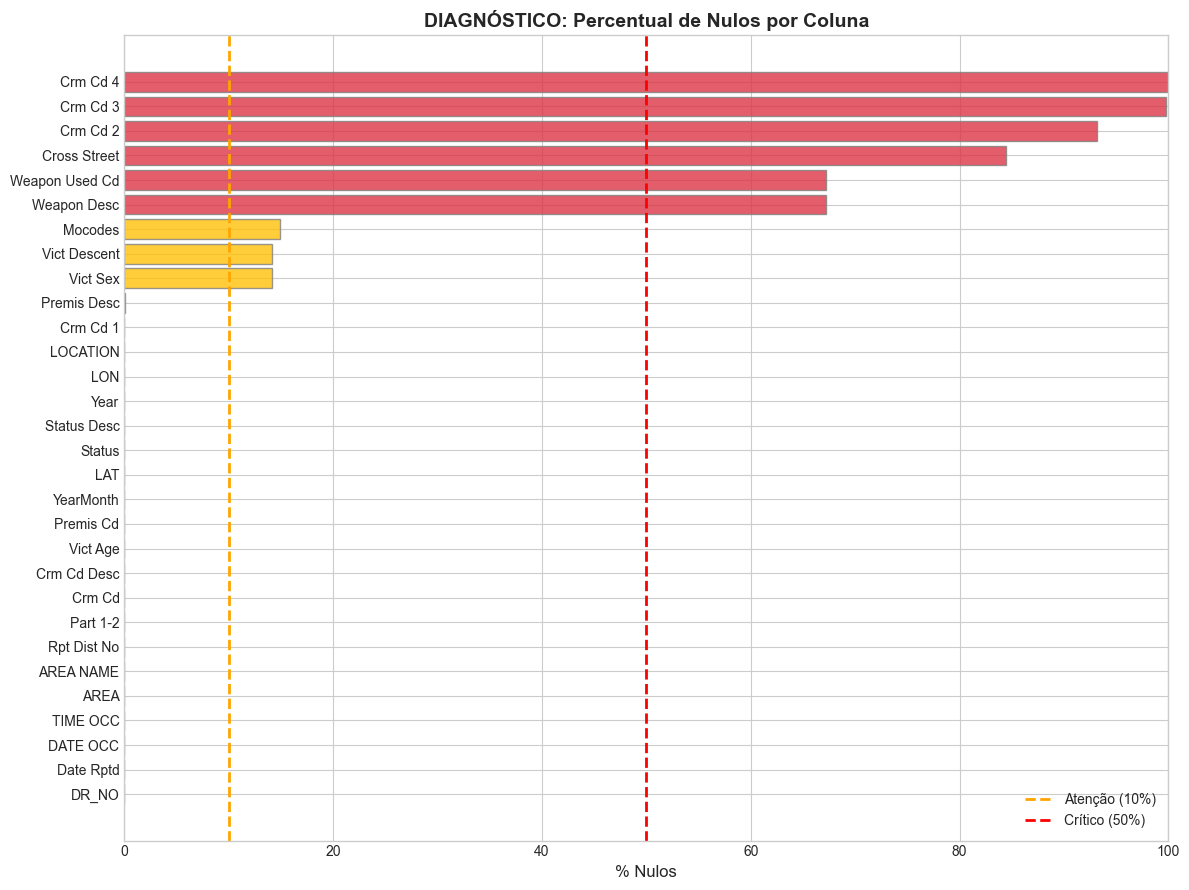


Críticas (>50%): 6
Atenção (10-50%): 3
OK (≤10%): 21


In [16]:
null_pct = (df_raw.isnull().sum() / len(df_raw) * 100).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, max(8, len(null_pct) * 0.3)))

colors = ['#dc3545' if p > 50 else '#ffc107' if p > 10 else '#28a745' for p in null_pct.values]
ax.barh(null_pct.index, null_pct.values, color=colors, edgecolor='gray', alpha=0.8)

ax.axvline(x=10, color='orange', linestyle='--', linewidth=2, label='Atenção (10%)')
ax.axvline(x=50, color='red', linestyle='--', linewidth=2, label='Crítico (50%)')

ax.set_xlabel('% Nulos', fontsize=12)
ax.set_title('DIAGNÓSTICO: Percentual de Nulos por Coluna', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()

print(f"\nCríticas (>50%): {len(null_pct[null_pct > 50])}")
print(f"Atenção (10-50%): {len(null_pct[(null_pct > 10) & (null_pct <= 50)])}")
print(f"OK (≤10%): {len(null_pct[null_pct <= 10])}")

### 2.2 Campos Obrigatórios Ausentes

**Descrição:** Análise dos campos essenciais para análise de crimes e quantos registros estão incompletos.

**Objetivo:** Medir o impacto real dos dados faltantes e determinar quantos registros serão perdidos na limpeza.

**Campos obrigatórios analisados:**
- `DATE OCC` - Data de ocorrência do crime
- `TIME OCC` - Hora da ocorrência
- `AREA NAME` - Distrito/área policial
- `Crm Cd Desc` - Descrição do tipo de crime
- `LAT/LON` - Coordenadas geográficas

**Como interpretar:**
- **Gráfico de barras:** Quantidade de registros ausentes por campo
- **Gráfico de pizza:** Proporção de registros completos vs incompletos

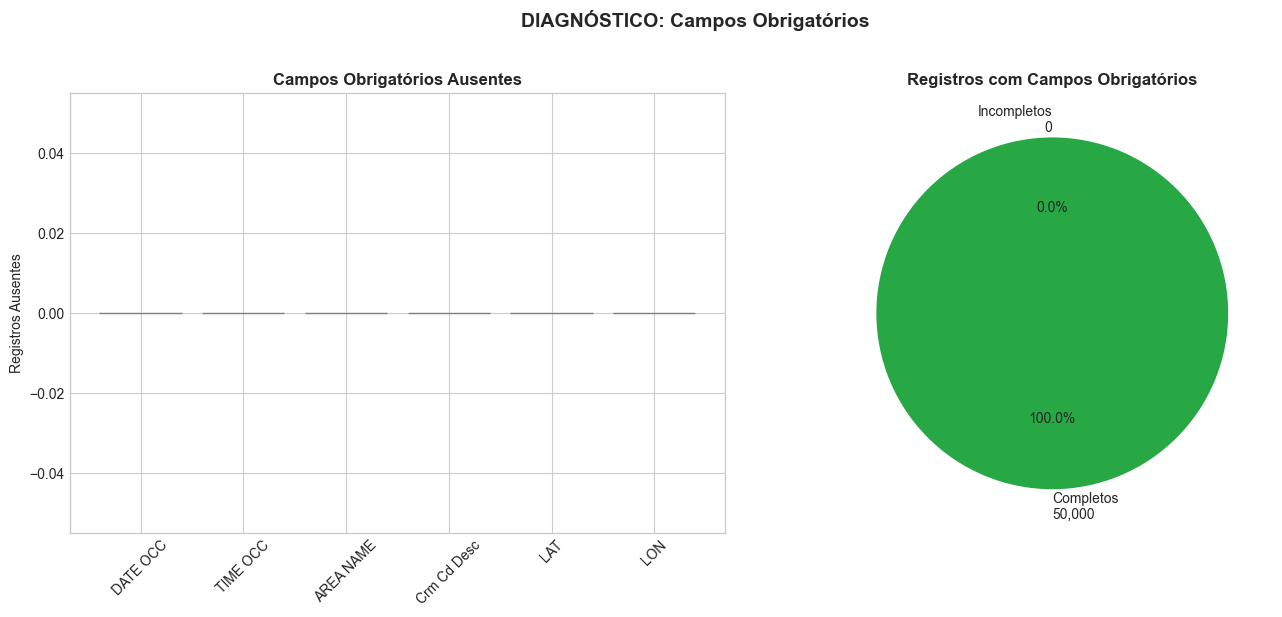

In [17]:
mandatory_fields = ['DATE OCC', 'TIME OCC', 'AREA NAME', 'Crm Cd Desc', 'LAT', 'LON']
available = [f for f in mandatory_fields if f in df_raw.columns]

missing = {f: df_raw[f].isnull().sum() for f in available}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
colors = ['#dc3545' if c > 0 else '#28a745' for c in missing.values()]
ax1.bar(missing.keys(), missing.values(), color=colors, edgecolor='gray')
ax1.set_ylabel('Registros Ausentes')
ax1.set_title('Campos Obrigatórios Ausentes', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

ax2 = axes[1]
complete = len(df_raw.dropna(subset=available))
incomplete = len(df_raw) - complete
ax2.pie([complete, incomplete], labels=[f'Completos\n{complete:,}', f'Incompletos\n{incomplete:,}'],
        colors=['#28a745', '#dc3545'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Registros com Campos Obrigatórios', fontweight='bold')

plt.suptitle('DIAGNÓSTICO: Campos Obrigatórios', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 2.3 Análise de Categorias de Crime

**Descrição:** Distribuição dos tipos de crime e análise de categorias potencialmente inconsistentes.

**Objetivo:** Identificar categorias raras que podem indicar erros de digitação ou categorização inconsistente, justificando normalizações na camada Silver.

**Como interpretar:**
- **Gráfico esquerdo:** Top 20 tipos de crime mais frequentes
- **Gráfico direito:** Distribuição de frequência das categorias
  - Muitas categorias com frequência baixa (1-10) podem indicar inconsistências
  - Categorias muito raras devem ser investigadas para possível agrupamento

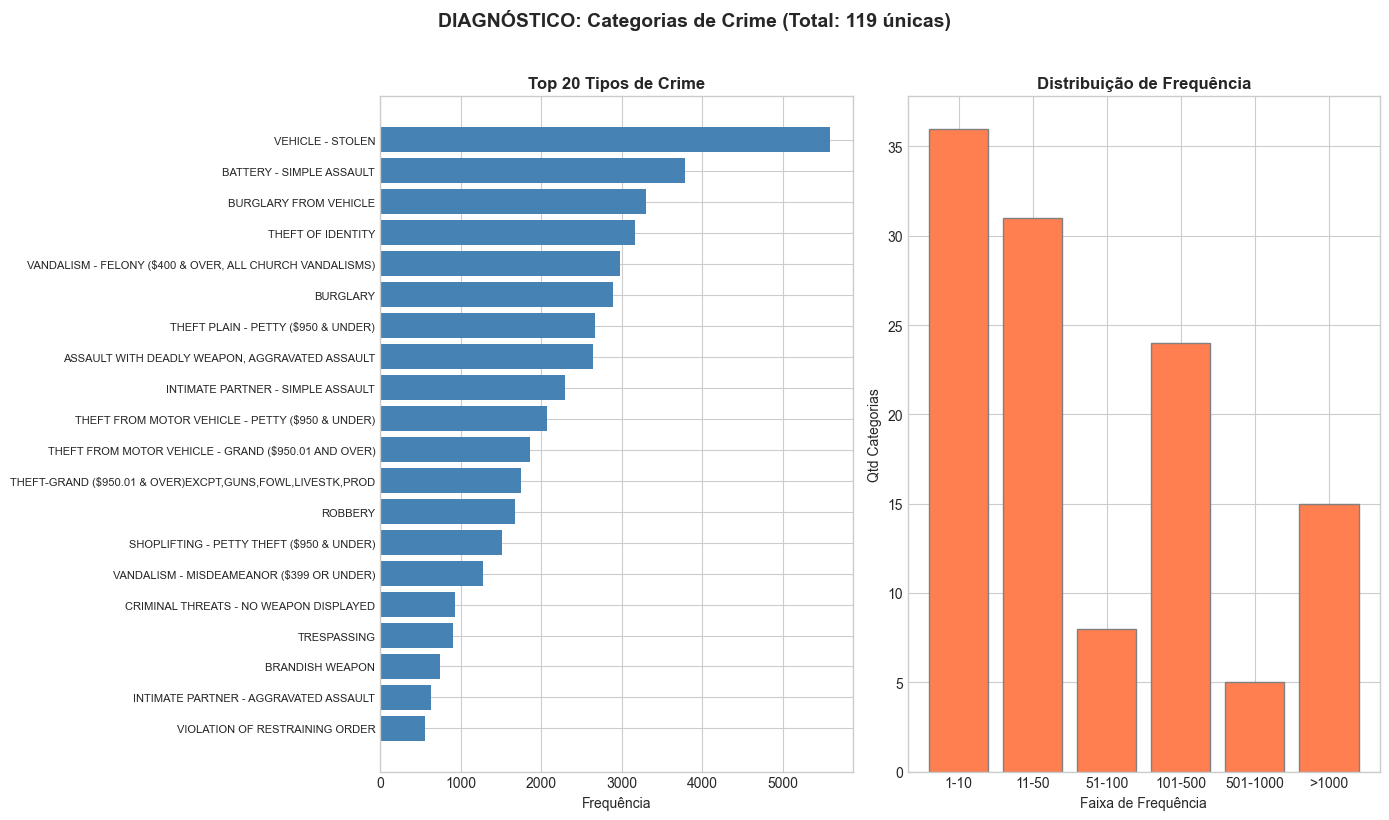


Categorias raras (≤5 ocorrências): 28


In [18]:
crime_types = df_raw['Crm Cd Desc'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

ax1 = axes[0]
top = crime_types.head(20)
ax1.barh(range(len(top)), top.values, color='steelblue')
ax1.set_yticks(range(len(top)))
ax1.set_yticklabels(top.index, fontsize=8)
ax1.invert_yaxis()
ax1.set_xlabel('Frequência')
ax1.set_title('Top 20 Tipos de Crime', fontweight='bold')

ax2 = axes[1]
freq_dist = pd.cut(crime_types, bins=[0, 10, 50, 100, 500, 1000, crime_types.max()],
                   labels=['1-10', '11-50', '51-100', '101-500', '501-1000', '>1000'])
freq_counts = freq_dist.value_counts().sort_index()
ax2.bar(freq_counts.index, freq_counts.values, color='coral', edgecolor='gray')
ax2.set_xlabel('Faixa de Frequência')
ax2.set_ylabel('Qtd Categorias')
ax2.set_title('Distribuição de Frequência', fontweight='bold')

plt.suptitle(f'DIAGNÓSTICO: Categorias de Crime (Total: {len(crime_types)} únicas)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

rare = crime_types[crime_types <= 5]
print(f"\nCategorias raras (≤5 ocorrências): {len(rare)}")

---
## 3. 📐 Gráficos de Estrutura e Outliers

**Objetivo:** Identificar valores fora do intervalo esperado e dados inválidos que precisam ser filtrados.

### 3.1 Validação de Horários (TIME OCC)

**Descrição:** Análise da distribuição do campo TIME OCC para identificar valores fora do intervalo válido (0-23 horas).

**Objetivo:** Detectar erros de digitação ou problemas de conversão no campo de hora.

**Como interpretar:**
- **Histograma:** Distribuição das horas extraídas do campo TIME OCC (formato HHMM)
- **Linhas vermelhas:** Limites válidos (0 e 23)
- **Box plot:** Detecta outliers estatísticos no campo
- Valores fora de 0-23 indicam erros que precisam ser tratados

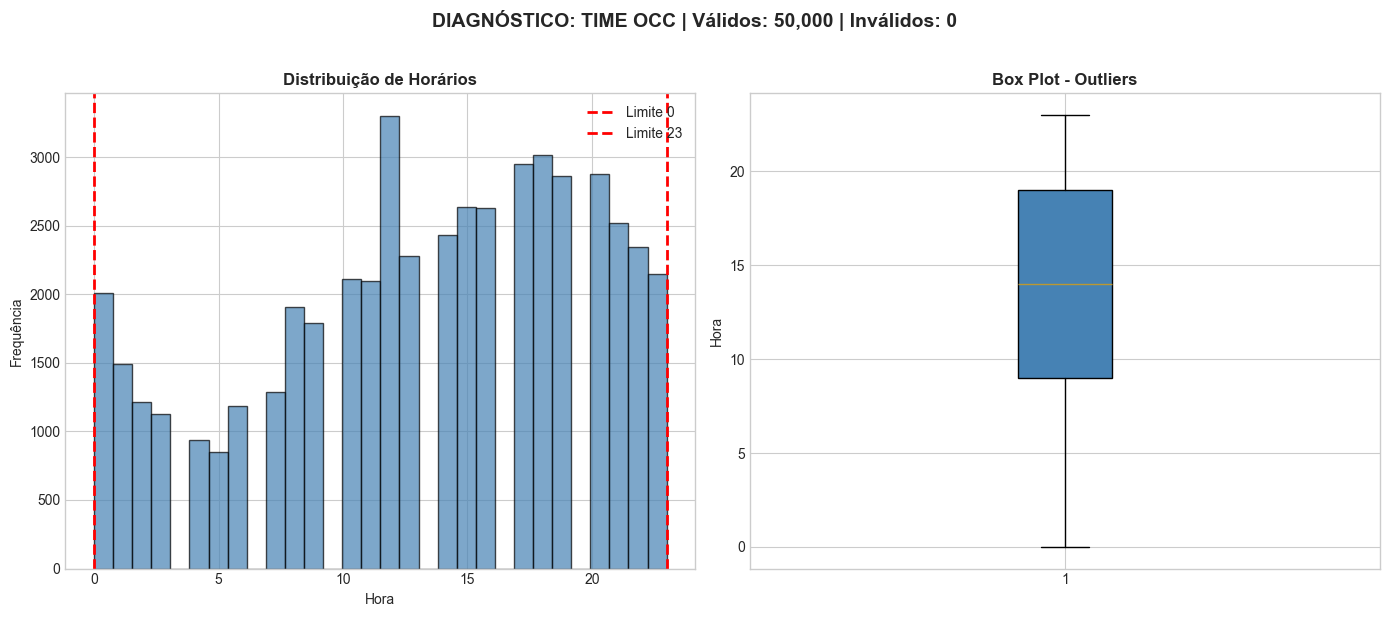

In [19]:
df_raw['Hour'] = df_raw['TIME OCC'] // 100
hour_data = df_raw['Hour'].dropna()

valid_hours = hour_data[(hour_data >= 0) & (hour_data < 24)]
invalid_hours = hour_data[(hour_data < 0) | (hour_data >= 24)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
ax1.hist(hour_data, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Limite 0')
ax1.axvline(x=23, color='red', linestyle='--', linewidth=2, label='Limite 23')
ax1.set_xlabel('Hora')
ax1.set_ylabel('Frequência')
ax1.set_title('Distribuição de Horários', fontweight='bold')
ax1.legend()

ax2 = axes[1]
bp = ax2.boxplot(hour_data, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
ax2.set_ylabel('Hora')
ax2.set_title('Box Plot - Outliers', fontweight='bold')

plt.suptitle(f'DIAGNÓSTICO: TIME OCC | Válidos: {len(valid_hours):,} | Inválidos: {len(invalid_hours):,}', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.2 Validação de Coordenadas Geográficas

**Descrição:** Scatter plot das coordenadas LAT/LON para identificar pontos fora dos limites de Los Angeles.

**Objetivo:** Detectar coordenadas inválidas (zeros, nulos) ou fora da área geográfica esperada.

**Limites de Los Angeles:**
- Latitude: 33.5° a 34.5° N
- Longitude: -118.8° a -117.8° W

**Como interpretar:**
- **Gráfico esquerdo:** Todas as coordenadas (pontos vermelhos = fora de LA)
- **Retângulo verde:** Área válida de Los Angeles
- **Gráfico direito:** Apenas coordenadas válidas dentro de LA

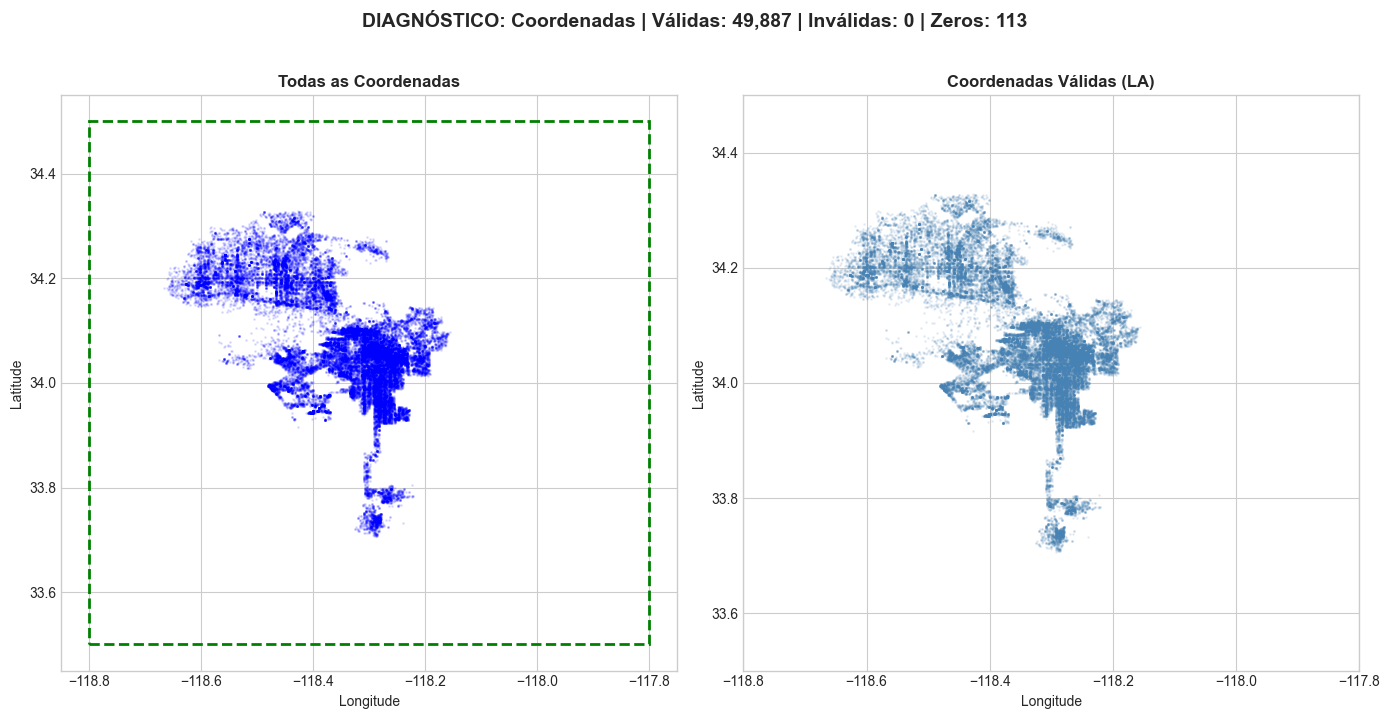

In [20]:
LA_LAT_MIN, LA_LAT_MAX = 33.5, 34.5
LA_LON_MIN, LA_LON_MAX = -118.8, -117.8

coords = df_raw[['LAT', 'LON']].dropna()
coords = coords[(coords['LAT'] != 0) & (coords['LON'] != 0)]

valid_coords = coords[(coords['LAT'] >= LA_LAT_MIN) & (coords['LAT'] <= LA_LAT_MAX) &
                      (coords['LON'] >= LA_LON_MIN) & (coords['LON'] <= LA_LON_MAX)]
invalid_coords = coords[~coords.index.isin(valid_coords.index)]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

ax1 = axes[0]
ax1.scatter(coords['LON'], coords['LAT'], alpha=0.1, s=1, color='blue')
if len(invalid_coords) > 0:
    ax1.scatter(invalid_coords['LON'], invalid_coords['LAT'], alpha=0.5, s=10, color='red', label=f'Fora de LA ({len(invalid_coords):,})')
rect = plt.Rectangle((LA_LON_MIN, LA_LAT_MIN), LA_LON_MAX-LA_LON_MIN, LA_LAT_MAX-LA_LAT_MIN,
                      fill=False, color='green', linewidth=2, linestyle='--')
ax1.add_patch(rect)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Todas as Coordenadas', fontweight='bold')
ax1.legend()

ax2 = axes[1]
ax2.scatter(valid_coords['LON'], valid_coords['LAT'], alpha=0.1, s=1, color='steelblue')
ax2.set_xlim(LA_LON_MIN, LA_LON_MAX)
ax2.set_ylim(LA_LAT_MIN, LA_LAT_MAX)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Coordenadas Válidas (LA)', fontweight='bold')

plt.suptitle(f'DIAGNÓSTICO: Coordenadas | Válidas: {len(valid_coords):,} | Inválidas: {len(invalid_coords):,} | Zeros: {len(df_raw)-len(coords):,}', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.3 Validação de Idade das Vítimas

**Descrição:** Análise da distribuição do campo Vict Age para identificar valores impossíveis.

**Objetivo:** Detectar idades negativas, zeros (não informado) ou valores impossíveis (>120 anos).

**Como interpretar:**
- **Histograma:** Distribuição de todas as idades registradas
- **Linhas vermelhas:** Limites válidos (0 e 120)
- **Idades = 0:** Geralmente significam "não informado"
- **Idades negativas ou >120:** Erros de digitação

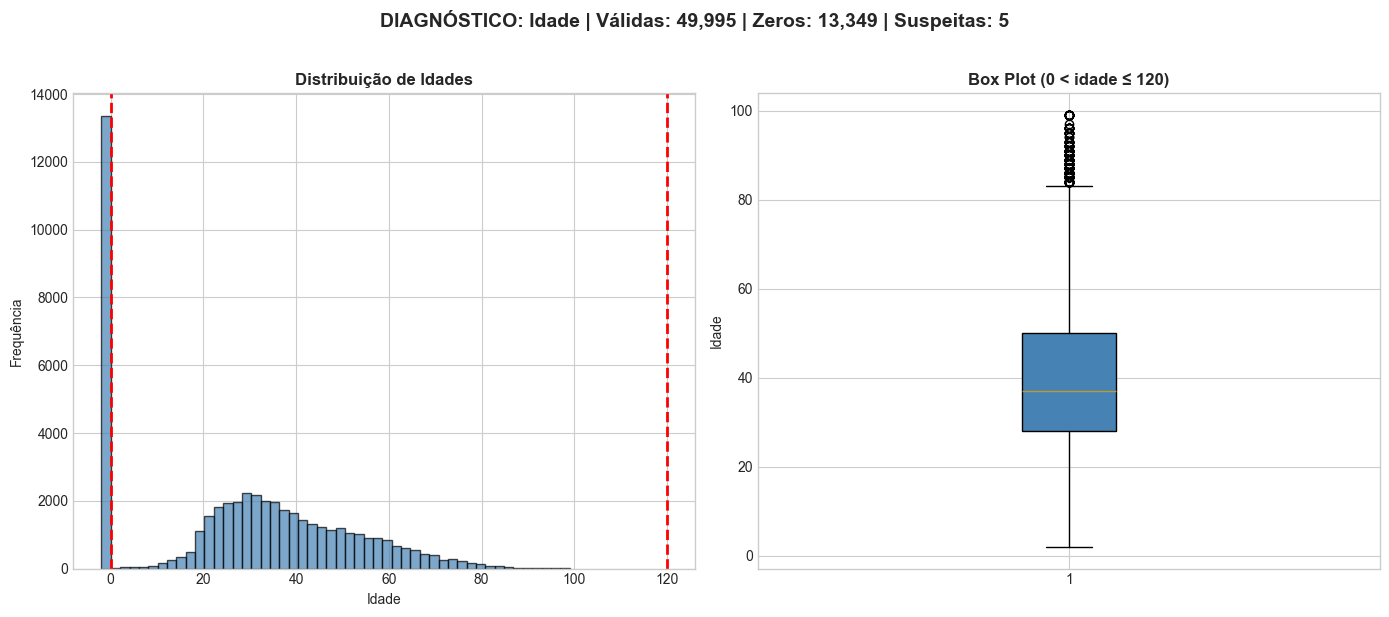

In [21]:
if 'Vict Age' in df_raw.columns:
    age_data = df_raw['Vict Age'].dropna()
    valid_ages = age_data[(age_data >= 0) & (age_data <= 120)]
    suspicious = age_data[(age_data < 0) | (age_data > 120)]
    zeros = age_data[age_data == 0]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1 = axes[0]
    ax1.hist(age_data, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax1.axvline(x=120, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Idade')
    ax1.set_ylabel('Frequência')
    ax1.set_title('Distribuição de Idades', fontweight='bold')
    
    ax2 = axes[1]
    bp = ax2.boxplot(valid_ages[valid_ages > 0], patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    ax2.set_ylabel('Idade')
    ax2.set_title('Box Plot (0 < idade ≤ 120)', fontweight='bold')
    
    plt.suptitle(f'DIAGNÓSTICO: Idade | Válidas: {len(valid_ages):,} | Zeros: {len(zeros):,} | Suspeitas: {len(suspicious):,}', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

---
## 📋 Resumo Diagnóstico

**Na camada Raw, os gráficos foram usados para:**
- ✅ Validação de ingestão (volume por período)
- ✅ Avaliação de qualidade (percentual de nulos)
- ✅ Identificação de inconsistências (categorias, outliers)

**Recomendações para a camada Silver:**
1. Remover/imputar valores nulos críticos
2. Filtrar coordenadas inválidas
3. Padronizar categorias de crimes
4. Tratar idades inválidas (0 e negativos)

In [ ]:
print("="*60)
print("RESUMO DIAGNÓSTICO - CAMADA RAW")
print("="*60)
print(f"\nArquivo: data_raw.csv")
print(f"Registros: {len(df_raw):,}")
print(f"Colunas: {len(df_raw.columns)}")
print(f"\nQUALIDADE:")
print(f"   Colunas >50% nulos: {len(null_pct[null_pct > 50])}")
print(f"   Coordenadas zeradas: {len(df_raw[(df_raw['LAT']==0)|(df_raw['LON']==0)]):,}")
print("="*60)

📊 RESUMO DIAGNÓSTICO - CAMADA RAW

📁 Arquivo: data_raw.csv
📈 Registros: 50,000
📋 Colunas: 31

🔍 QUALIDADE:
   Colunas >50% nulos: 6
   Coordenadas zeradas: 113


# 📊 Análise Diagnóstica - Camada RAW (Bronze)

**Objetivo:** Validação de ingestão, avaliação de qualidade e identificação de inconsistências.

Na camada Raw, os dados ainda estão:
- ❌ Sem limpeza completa
- ❌ Com valores ausentes
- ❌ Com categorias inconsistentes
- ✅ Próximos do formato original da fonte

**Os gráficos aqui não são "bonitos", são diagnósticos.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette('husl')

# Caminhos
PROJECT_ROOT = Path.cwd().parent.parent
RAW_PATH = PROJECT_ROOT / 'Data Layer' / 'raw'

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"RAW_PATH: {RAW_PATH}")

📁 PROJECT_ROOT: c:\Users\David\Documents\UnB\SBD2\SBD2
📂 RAW_PATH: c:\Users\David\Documents\UnB\SBD2\SBD2\Data Layer\raw


In [ ]:
# Carregar dados brutos
df_raw = pd.read_csv(RAW_PATH / 'data_raw.csv', low_memory=False)

print(f"Total de registros: {len(df_raw):,}")
print(f"Total de colunas: {len(df_raw.columns)}")
print(f"\nColunas disponíveis:")
for i, col in enumerate(df_raw.columns, 1):
    print(f"  {i:02d}. {col}")

📊 Total de registros: 50,000
📋 Total de colunas: 28

🔢 Colunas disponíveis:
  01. DR_NO
  02. Date Rptd
  03. DATE OCC
  04. TIME OCC
  05. AREA
  06. AREA NAME
  07. Rpt Dist No
  08. Part 1-2
  09. Crm Cd
  10. Crm Cd Desc
  11. Mocodes
  12. Vict Age
  13. Vict Sex
  14. Vict Descent
  15. Premis Cd
  16. Premis Desc
  17. Weapon Used Cd
  18. Weapon Desc
  19. Status
  20. Status Desc
  21. Crm Cd 1
  22. Crm Cd 2
  23. Crm Cd 3
  24. Crm Cd 4
  25. LOCATION
  26. Cross Street
  27. LAT
  28. LON


---
## 1. 📈 Gráficos de Volume e Ingestão

Objetivo: Validar consistência do pipeline de ingestão e detectar anomalias.

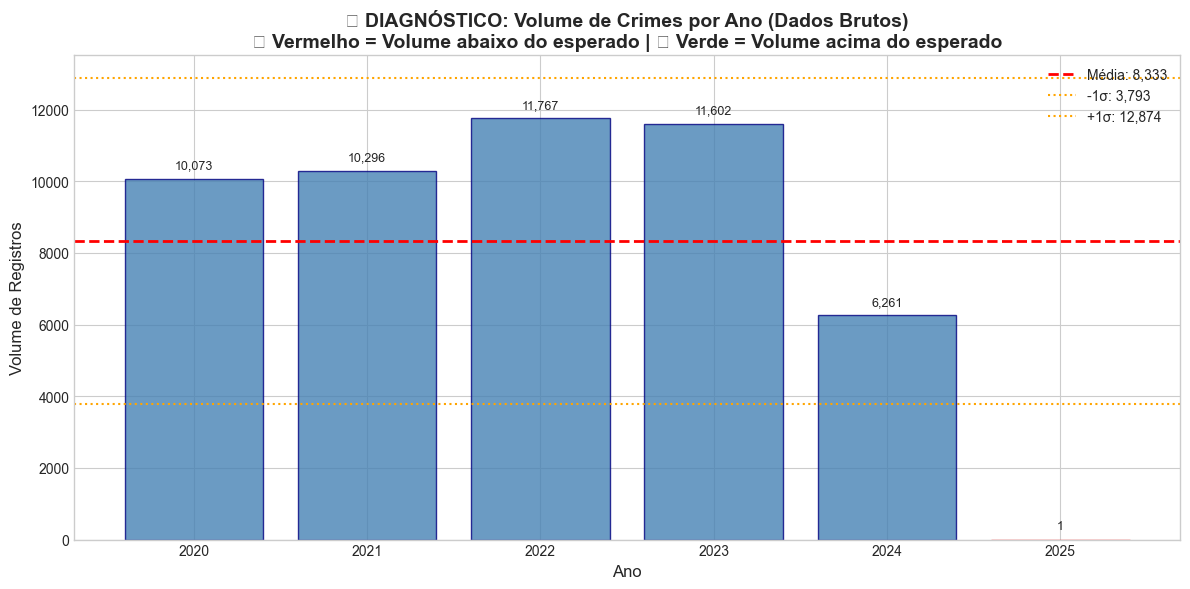


📋 Análise de Volume por Ano:
   Média: 8,333 registros/ano
   Desvio Padrão: 4,540
   Anos com possível problema de coleta: [2025]


In [ ]:
# 1.1 Volume de crimes por ano (dados brutos)
# Objetivo: detectar quedas ou picos inesperados causados por falhas de coleta

# Extrair ano da coluna DATE OCC
df_raw['DATE OCC'] = pd.to_datetime(df_raw['DATE OCC'], errors='coerce')
df_raw['Year'] = df_raw['DATE OCC'].dt.year

yearly_counts = df_raw['Year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(yearly_counts.index.astype(str), yearly_counts.values, 
              color='steelblue', edgecolor='navy', alpha=0.8)

# Destacar anos com volume anômalo
mean_vol = yearly_counts.mean()
std_vol = yearly_counts.std()
for i, (year, count) in enumerate(yearly_counts.items()):
    if count < mean_vol - std_vol:
        bars[i].set_color('red')
        bars[i].set_alpha(0.9)
    elif count > mean_vol + std_vol:
        bars[i].set_color('green')
        bars[i].set_alpha(0.9)

ax.axhline(y=mean_vol, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_vol:,.0f}')
ax.axhline(y=mean_vol - std_vol, color='orange', linestyle=':', label=f'-1σ: {mean_vol - std_vol:,.0f}')
ax.axhline(y=mean_vol + std_vol, color='orange', linestyle=':', label=f'+1σ: {mean_vol + std_vol:,.0f}')

ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Volume de Registros', fontsize=12)
ax.set_title('DIAGNÓSTICO: Volume de Crimes por Ano (Dados Brutos)\n'
             'Vermelho = Volume abaixo do esperado | Verde = Volume acima do esperado', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right')

for i, (year, count) in enumerate(yearly_counts.items()):
    ax.text(i, count + 200, f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nAnálise de Volume por Ano:")
print(f"   Média: {mean_vol:,.0f} registros/ano")
print(f"   Desvio Padrão: {std_vol:,.0f}")
print(f"   Anos com possível problema de coleta: {list(yearly_counts[yearly_counts < mean_vol - std_vol].index)}")

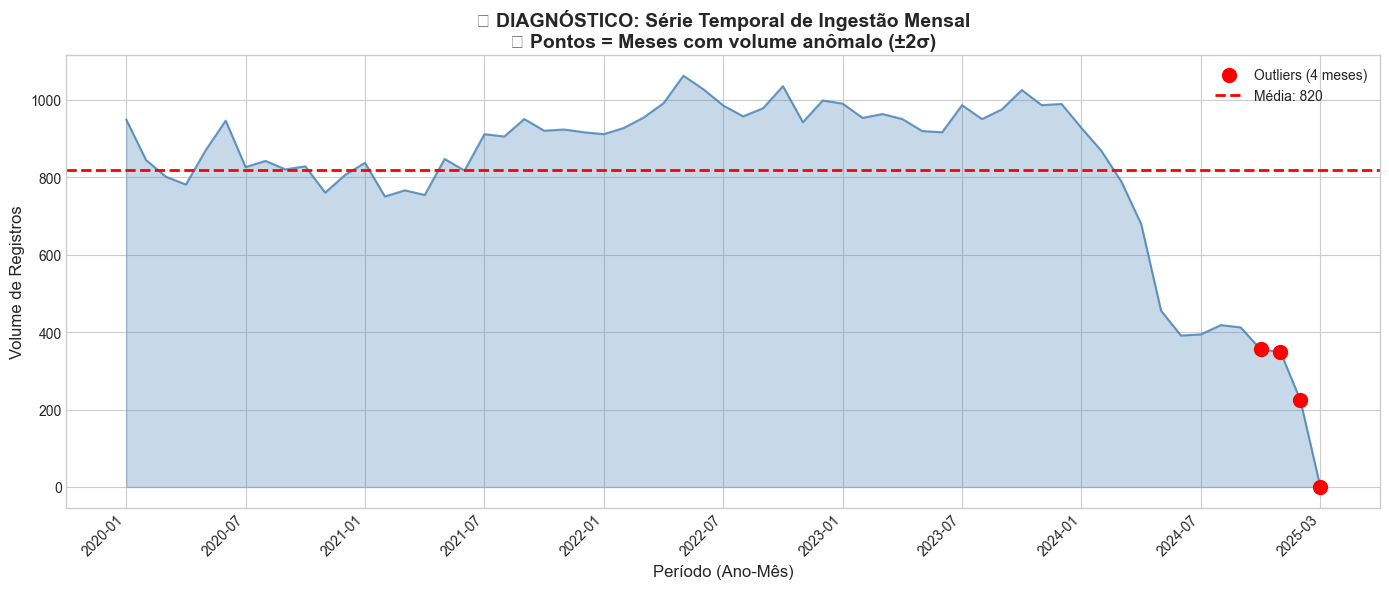


📋 Meses com volume anômalo: 4
   Detalhes:
   - 2024-10: 355 registros (BAIXO)
   - 2024-11: 349 registros (BAIXO)
   - 2024-12: 224 registros (BAIXO)
   - 2025-03: 1 registros (BAIXO)


In [ ]:
# 1.2 Volume de registros por mês (série temporal bruta)
# Objetivo: identificar gaps ou picos de ingestão

df_raw['YearMonth'] = df_raw['DATE OCC'].dt.to_period('M')
monthly_counts = df_raw['YearMonth'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(len(monthly_counts)), monthly_counts.values, 
        color='steelblue', linewidth=1.5, alpha=0.8)
ax.fill_between(range(len(monthly_counts)), monthly_counts.values, 
                alpha=0.3, color='steelblue')

# Marcar outliers
mean_monthly = monthly_counts.mean()
std_monthly = monthly_counts.std()
outliers = monthly_counts[(monthly_counts < mean_monthly - 2*std_monthly) | 
                          (monthly_counts > mean_monthly + 2*std_monthly)]

if len(outliers) > 0:
    outlier_idx = [list(monthly_counts.index).index(x) for x in outliers.index]
    ax.scatter(outlier_idx, outliers.values, color='red', s=100, zorder=5, 
               label=f'Outliers ({len(outliers)} meses)')

ax.axhline(y=mean_monthly, color='red', linestyle='--', linewidth=2, 
           label=f'Média: {mean_monthly:,.0f}')

# Labels do eixo X (apenas alguns)
tick_positions = range(0, len(monthly_counts), max(1, len(monthly_counts)//10))
tick_labels = [str(monthly_counts.index[i]) for i in tick_positions]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

ax.set_xlabel('Período (Ano-Mês)', fontsize=12)
ax.set_ylabel('Volume de Registros', fontsize=12)
ax.set_title('DIAGNÓSTICO: Série Temporal de Ingestão Mensal\n'
             'Pontos = Meses com volume anômalo (±2σ)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nMeses com volume anômalo: {len(outliers)}")
if len(outliers) > 0:
    print("   Detalhes:")
    for period, count in outliers.items():
        status = "BAIXO" if count < mean_monthly else "ALTO"
        print(f"   - {period}: {count:,} registros ({status})")

---
## 2. 🔍 Gráficos de Qualidade de Dados

Objetivo: Identificar campos críticos para tratamento e medir impacto de dados incompletos.

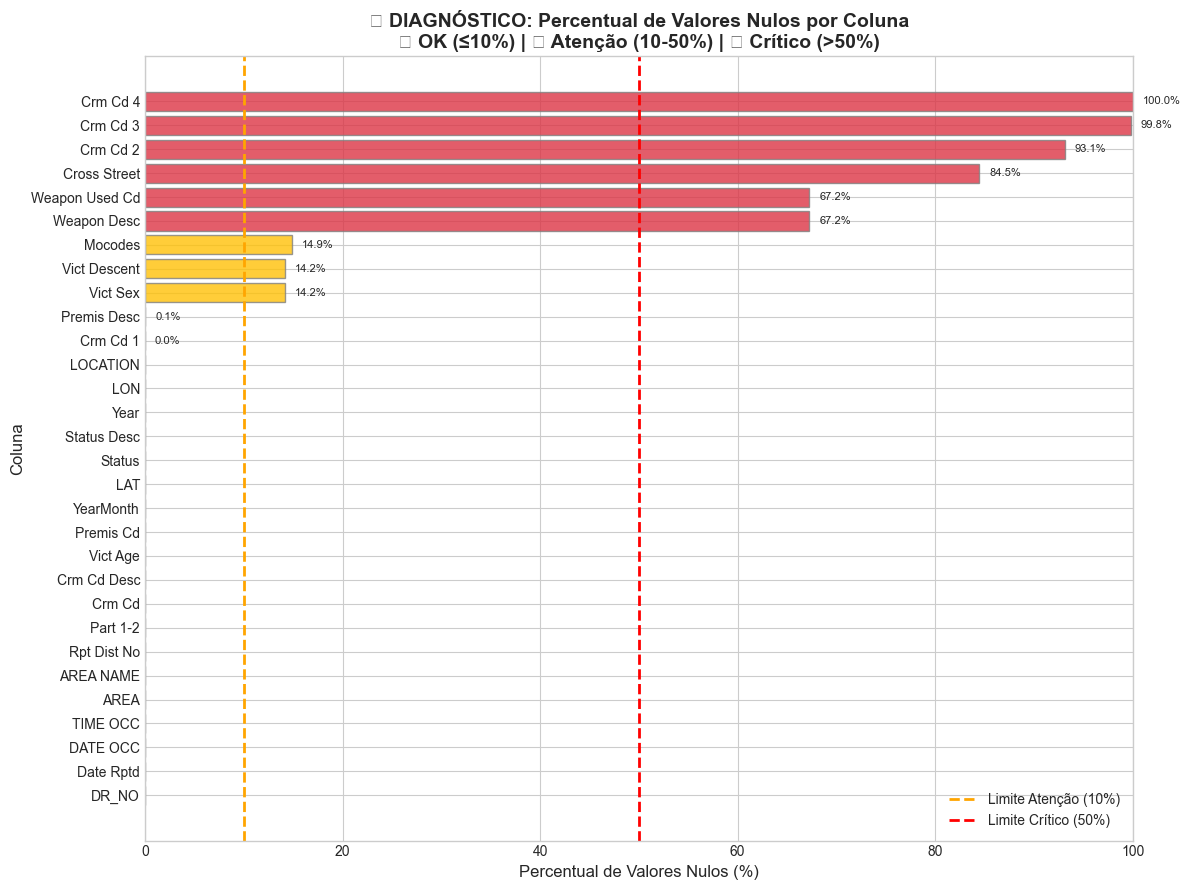


📋 Resumo de Qualidade:
   🔴 Colunas críticas (>50% nulos): 6
   🟡 Colunas atenção (10-50% nulos): 3
   🟢 Colunas OK (≤10% nulos): 21

   ⚠️ Colunas críticas: ['Weapon Desc', 'Weapon Used Cd', 'Cross Street', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4']


In [ ]:
# 2.1 Percentual de valores nulos por coluna
# Objetivo: identificar campos críticos para tratamento

null_pct = (df_raw.isnull().sum() / len(df_raw) * 100).sort_values(ascending=True)

# Separar por criticidade
critical = null_pct[null_pct > 50]
warning = null_pct[(null_pct > 10) & (null_pct <= 50)]
ok = null_pct[null_pct <= 10]

fig, ax = plt.subplots(figsize=(12, max(8, len(null_pct) * 0.3)))

colors = []
for col in null_pct.index:
    if null_pct[col] > 50:
        colors.append('#dc3545')  # Vermelho - crítico
    elif null_pct[col] > 10:
        colors.append('#ffc107')  # Amarelo - atenção
    else:
        colors.append('#28a745')  # Verde - ok

bars = ax.barh(null_pct.index, null_pct.values, color=colors, edgecolor='gray', alpha=0.8)

ax.axvline(x=10, color='orange', linestyle='--', linewidth=2, label='Limite Atenção (10%)')
ax.axvline(x=50, color='red', linestyle='--', linewidth=2, label='Limite Crítico (50%)')

ax.set_xlabel('Percentual de Valores Nulos (%)', fontsize=12)
ax.set_ylabel('Coluna', fontsize=12)
ax.set_title('DIAGNÓSTICO: Percentual de Valores Nulos por Coluna\n'
             'OK (≤10%) | Atenção (10-50%) | Crítico (>50%)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim(0, 100)

# Adicionar valores
for i, (col, pct) in enumerate(null_pct.items()):
    if pct > 0:
        ax.text(pct + 1, i, f'{pct:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\n📋 Resumo de Qualidade:")
print(f"   Colunas críticas (>50% nulos): {len(critical)}")
print(f"   Colunas atenção (10-50% nulos): {len(warning)}")
print(f"   Colunas OK (≤10% nulos): {len(ok)}")

if len(critical) > 0:
    print(f"\n   Colunas críticas: {list(critical.index)}")

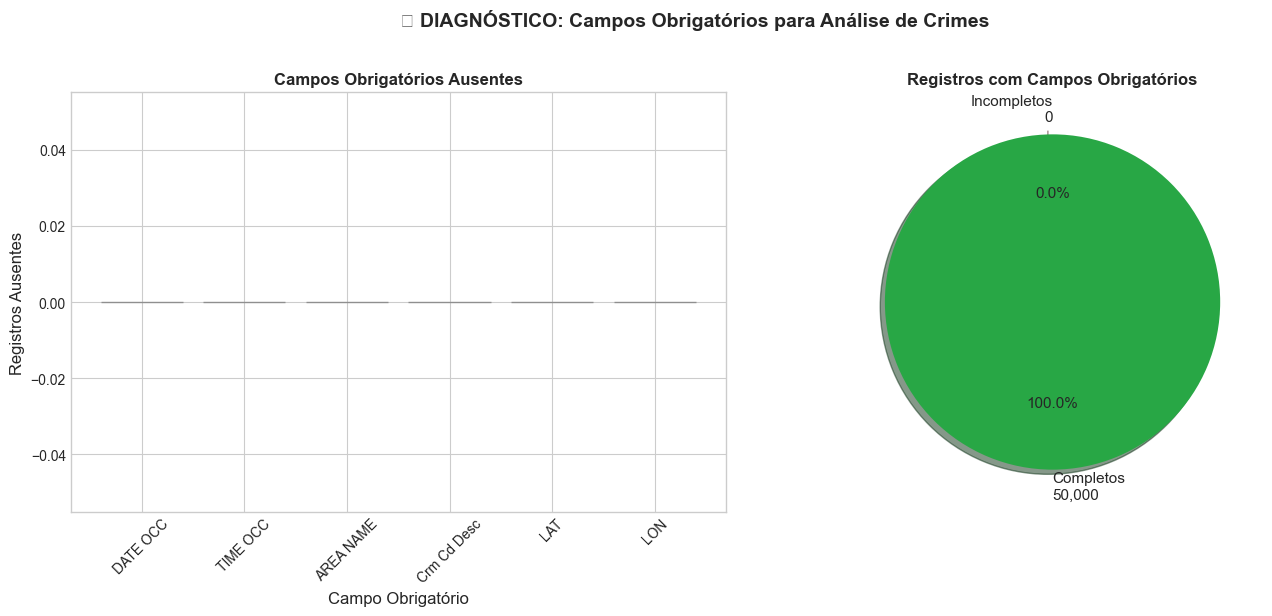


📋 Impacto dos Dados Incompletos:
   Total de registros: 50,000
   Registros completos: 50,000 (100.0%)
   Registros incompletos: 0 (0.0%)


In [ ]:
# 2.2 Distribuição de campos obrigatórios ausentes
# Objetivo: medir impacto de dados incompletos

# Campos obrigatórios para análise de crimes
mandatory_fields = ['DATE OCC', 'TIME OCC', 'AREA NAME', 'Crm Cd Desc', 'LAT', 'LON']
available_mandatory = [f for f in mandatory_fields if f in df_raw.columns]

missing_counts = {}
for field in available_mandatory:
    missing_counts[field] = df_raw[field].isnull().sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de barras
ax1 = axes[0]
fields = list(missing_counts.keys())
counts = list(missing_counts.values())
colors = ['#dc3545' if c > 0 else '#28a745' for c in counts]

bars = ax1.bar(fields, counts, color=colors, edgecolor='gray', alpha=0.8)
ax1.set_xlabel('Campo Obrigatório', fontsize=12)
ax1.set_ylabel('Registros Ausentes', fontsize=12)
ax1.set_title('Campos Obrigatórios Ausentes', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

for bar, count in zip(bars, counts):
    if count > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{count:,}', ha='center', va='bottom', fontsize=9)

# Gráfico de pizza - registros completos vs incompletos
ax2 = axes[1]
complete = len(df_raw.dropna(subset=available_mandatory))
incomplete = len(df_raw) - complete

sizes = [complete, incomplete]
labels = [f'Completos\n{complete:,}', f'Incompletos\n{incomplete:,}']
colors_pie = ['#28a745', '#dc3545']
explode = (0, 0.05)

ax2.pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 11})
ax2.set_title('Registros com Campos Obrigatórios', fontsize=12, fontweight='bold')

plt.suptitle('DIAGNÓSTICO: Campos Obrigatórios para Análise de Crimes', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nImpacto dos Dados Incompletos:")
print(f"   Total de registros: {len(df_raw):,}")
print(f"   Registros completos: {complete:,} ({complete/len(df_raw)*100:.1f}%)")
print(f"   Registros incompletos: {incomplete:,} ({incomplete/len(df_raw)*100:.1f}%)")

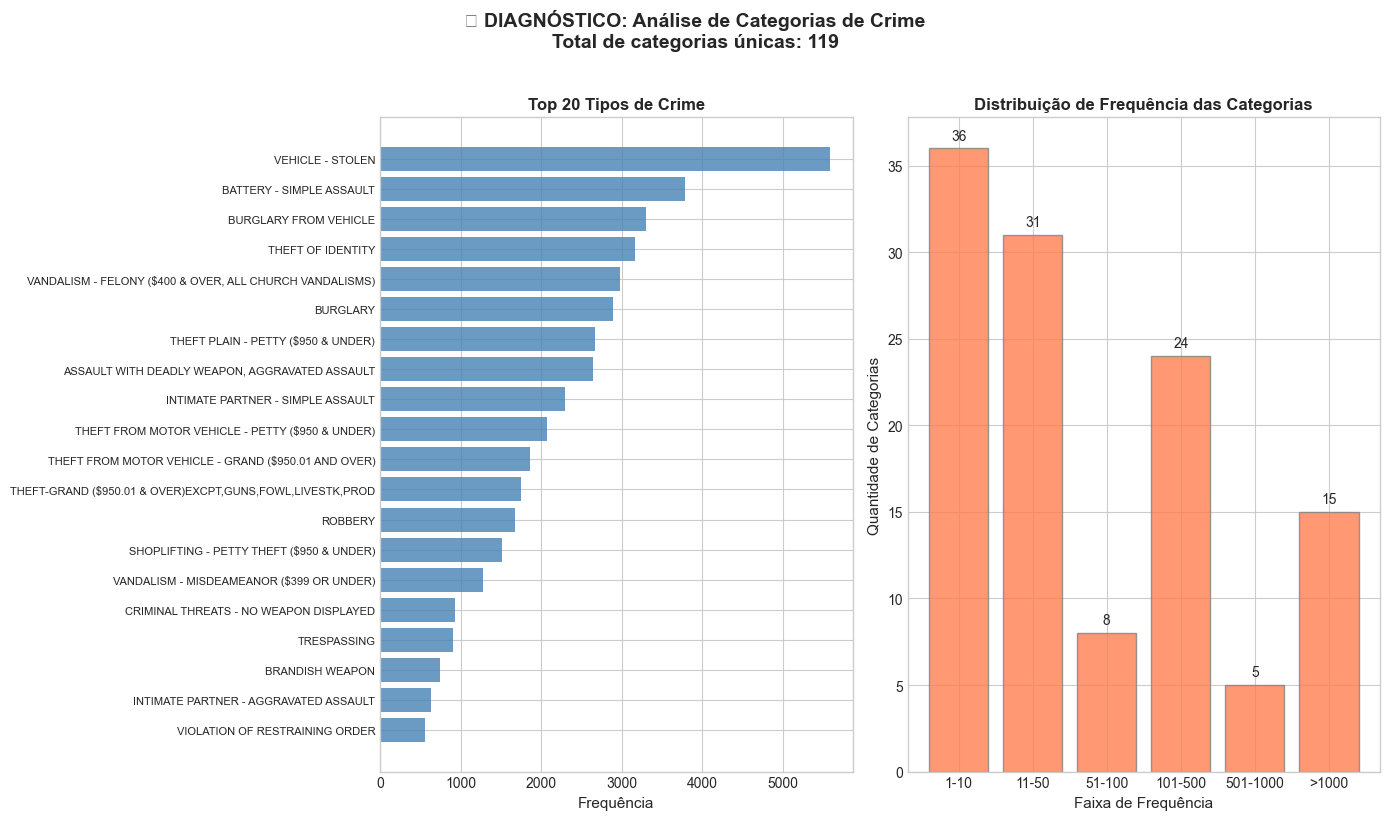


📋 Análise de Categorias:
   Total de categorias únicas: 119
   Categorias raras (≤10 ocorrências): 36
   Categorias frequentes (>1000 ocorrências): 15

   ⚠️ Categorias muito raras (≤5 ocorrências) - possível inconsistência:
      - 'ILLEGAL DUMPING': 5 ocorrências
      - 'PURSE SNATCHING': 5 ocorrências
      - 'DOCUMENT WORTHLESS ($200.01 & OVER)': 5 ocorrências
      - 'CONTRIBUTING': 5 ocorrências
      - 'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01': 4 ocorrências
      - 'KIDNAPPING - GRAND ATTEMPT': 4 ocorrências
      - 'LEWD/LASCIVIOUS ACTS WITH CHILD': 4 ocorrências
      - 'THEFT, COIN MACHINE - PETTY ($950 & UNDER)': 3 ocorrências
      - 'PURSE SNATCHING - ATTEMPT': 3 ocorrências
      - 'FALSE POLICE REPORT': 3 ocorrências


In [ ]:
# 2.3 Frequência de categorias inconsistentes em campos textuais
# Objetivo: justificar normalizações na Silver

# Analisar campo de tipo de crime
crime_types = df_raw['Crm Cd Desc'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Top 20 tipos de crime
ax1 = axes[0]
top_crimes = crime_types.head(20)
ax1.barh(range(len(top_crimes)), top_crimes.values, color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(top_crimes)))
ax1.set_yticklabels(top_crimes.index, fontsize=8)
ax1.invert_yaxis()
ax1.set_xlabel('Frequência', fontsize=11)
ax1.set_title('Top 20 Tipos de Crime', fontsize=12, fontweight='bold')

# Distribuição de frequência (quantos tipos aparecem X vezes)
ax2 = axes[1]
freq_dist = pd.cut(crime_types, bins=[0, 10, 50, 100, 500, 1000, crime_types.max()],
                   labels=['1-10', '11-50', '51-100', '101-500', '501-1000', '>1000'])
freq_counts = freq_dist.value_counts().sort_index()

ax2.bar(freq_counts.index, freq_counts.values, color='coral', alpha=0.8, edgecolor='gray')
ax2.set_xlabel('Faixa de Frequência', fontsize=11)
ax2.set_ylabel('Quantidade de Categorias', fontsize=11)
ax2.set_title('Distribuição de Frequência das Categorias', fontsize=12, fontweight='bold')

for i, v in enumerate(freq_counts.values):
    ax2.text(i, v + 0.5, str(v), ha='center', fontsize=10)

plt.suptitle('DIAGNÓSTICO: Análise de Categorias de Crime\n'
             f'Total de categorias únicas: {len(crime_types)}', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Detectar possíveis inconsistências
print("\nAnálise de Categorias:")
print(f"   Total de categorias únicas: {len(crime_types)}")
print(f"   Categorias raras (≤10 ocorrências): {len(crime_types[crime_types <= 10])}")
print(f"   Categorias frequentes (>1000 ocorrências): {len(crime_types[crime_types > 1000])}")

# Mostrar categorias que podem ser inconsistentes (muito raras)
rare_categories = crime_types[crime_types <= 5]
if len(rare_categories) > 0:
    print(f"\n   Categorias muito raras (≤5 ocorrências) - possível inconsistência:")
    for cat, count in rare_categories.head(10).items():
        print(f"      - '{cat}': {count} ocorrências")

---
## 3. 📐 Gráficos de Estrutura e Outliers

Objetivo: Identificar valores fora do intervalo esperado e dados inválidos.

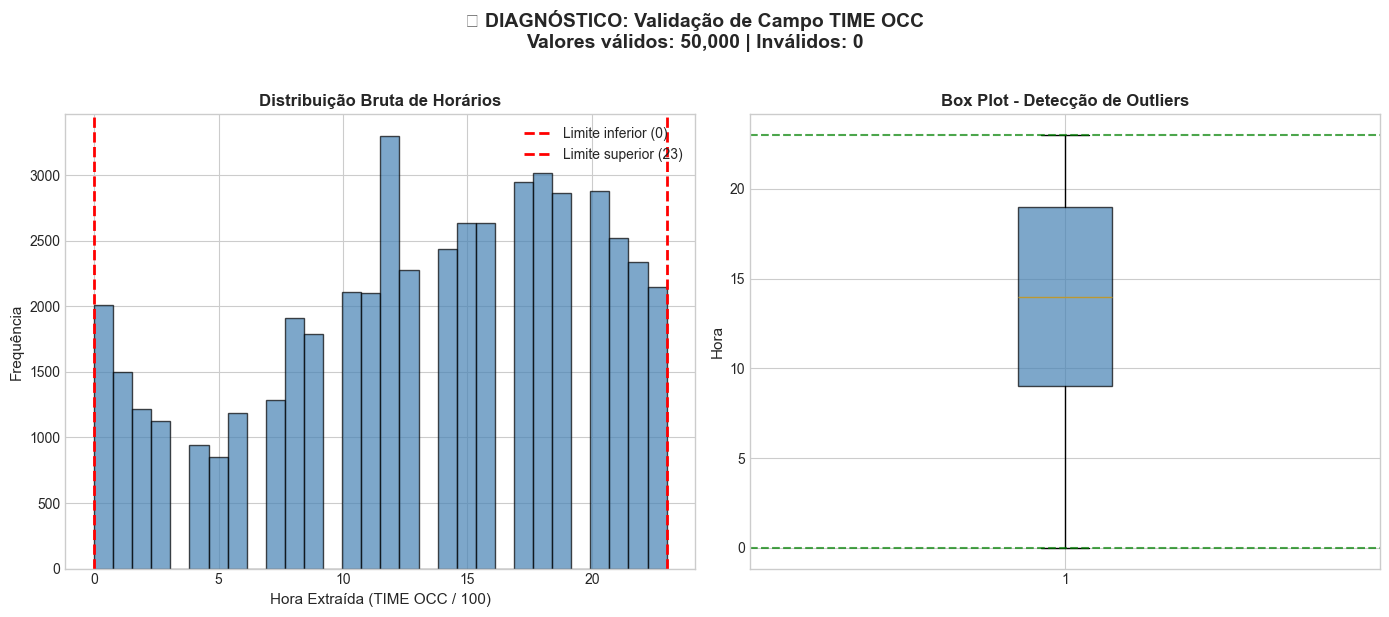


📋 Análise de Horários:
   Total com hora válida (0-23): 50,000 (100.00%)
   Total com hora inválida: 0 (0.00%)


In [ ]:
# 3.1 Distribuição bruta de horários dos crimes
# Objetivo: identificar valores fora do intervalo esperado (ex.: hora > 24)

# TIME OCC está no formato HHMM (ex: 1430 = 14:30)
df_raw['Hour'] = df_raw['TIME OCC'] // 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma da hora (incluindo outliers)
ax1 = axes[0]
hour_data = df_raw['Hour'].dropna()

# Contar outliers
valid_hours = hour_data[(hour_data >= 0) & (hour_data < 24)]
invalid_hours = hour_data[(hour_data < 0) | (hour_data >= 24)]

ax1.hist(hour_data, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Limite inferior (0)')
ax1.axvline(x=23, color='red', linestyle='--', linewidth=2, label='Limite superior (23)')
ax1.set_xlabel('Hora Extraída (TIME OCC / 100)', fontsize=11)
ax1.set_ylabel('Frequência', fontsize=11)
ax1.set_title('Distribuição Bruta de Horários', fontsize=12, fontweight='bold')
ax1.legend()

# Box plot para detectar outliers
ax2 = axes[1]
bp = ax2.boxplot(hour_data, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
ax2.set_ylabel('Hora', fontsize=11)
ax2.set_title('Box Plot - Detecção de Outliers', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='green', linestyle='--', alpha=0.7)
ax2.axhline(y=23, color='green', linestyle='--', alpha=0.7)

plt.suptitle('DIAGNÓSTICO: Validação de Campo TIME OCC\n'
             f'Valores válidos: {len(valid_hours):,} | Inválidos: {len(invalid_hours):,}', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nAnálise de Horários:")
print(f"   Total com hora válida (0-23): {len(valid_hours):,} ({len(valid_hours)/len(hour_data)*100:.2f}%)")
print(f"   Total com hora inválida: {len(invalid_hours):,} ({len(invalid_hours)/len(hour_data)*100:.2f}%)")
if len(invalid_hours) > 0:
    print(f"   Valores inválidos encontrados: min={invalid_hours.min()}, max={invalid_hours.max()}")

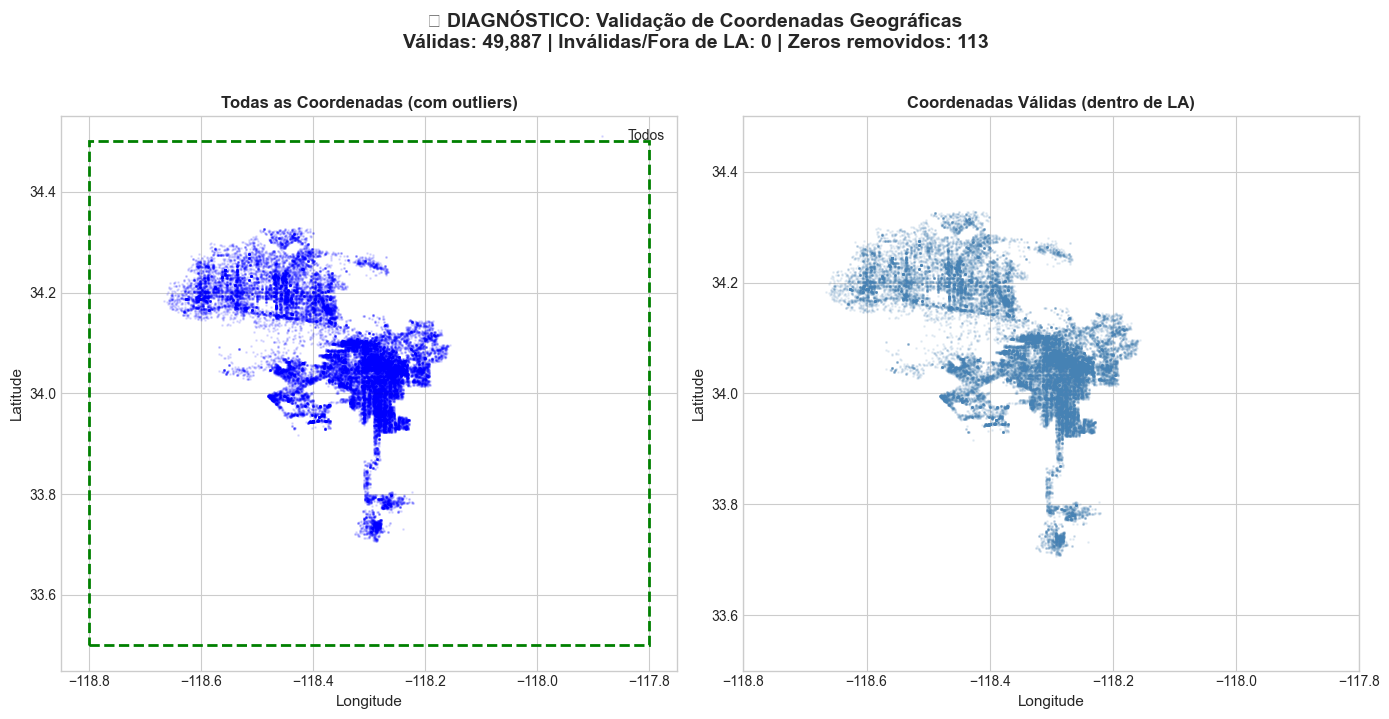


📋 Análise de Coordenadas:
   Total de registros: 50,000
   Com coordenadas (não-zero): 49,887 (99.8%)
   Dentro de LA: 49,887 (100.0%)
   Fora de LA: 0 (0.0%)
   Coordenadas zeradas: 113


In [ ]:
# 3.2 Distribuição geográfica bruta (scatter plot lat/long)
# Objetivo: identificar coordenadas inválidas ou fora da cidade de Los Angeles

# Limites aproximados de Los Angeles
LA_LAT_MIN, LA_LAT_MAX = 33.5, 34.5
LA_LON_MIN, LA_LON_MAX = -118.8, -117.8

# Filtrar dados com coordenadas
coords = df_raw[['LAT', 'LON']].dropna()
coords = coords[(coords['LAT'] != 0) & (coords['LON'] != 0)]  # Remover zeros

# Classificar coordenadas
valid_coords = coords[(coords['LAT'] >= LA_LAT_MIN) & (coords['LAT'] <= LA_LAT_MAX) &
                      (coords['LON'] >= LA_LON_MIN) & (coords['LON'] <= LA_LON_MAX)]
invalid_coords = coords[~coords.index.isin(valid_coords.index)]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Scatter plot completo
ax1 = axes[0]
ax1.scatter(coords['LON'], coords['LAT'], alpha=0.1, s=1, color='blue', label='Todos')
if len(invalid_coords) > 0:
    ax1.scatter(invalid_coords['LON'], invalid_coords['LAT'], 
                alpha=0.5, s=10, color='red', label=f'Fora de LA ({len(invalid_coords):,})')

# Desenhar retângulo de LA
rect = plt.Rectangle((LA_LON_MIN, LA_LAT_MIN), 
                      LA_LON_MAX - LA_LON_MIN, LA_LAT_MAX - LA_LAT_MIN,
                      fill=False, color='green', linewidth=2, linestyle='--')
ax1.add_patch(rect)

ax1.set_xlabel('Longitude', fontsize=11)
ax1.set_ylabel('Latitude', fontsize=11)
ax1.set_title('Todas as Coordenadas (com outliers)', fontsize=12, fontweight='bold')
ax1.legend()

# Scatter plot apenas LA
ax2 = axes[1]
ax2.scatter(valid_coords['LON'], valid_coords['LAT'], alpha=0.1, s=1, color='steelblue')
ax2.set_xlim(LA_LON_MIN, LA_LON_MAX)
ax2.set_ylim(LA_LAT_MIN, LA_LAT_MAX)
ax2.set_xlabel('Longitude', fontsize=11)
ax2.set_ylabel('Latitude', fontsize=11)
ax2.set_title('Coordenadas Válidas (dentro de LA)', fontsize=12, fontweight='bold')

plt.suptitle('DIAGNÓSTICO: Validação de Coordenadas Geográficas\n'
             f'Válidas: {len(valid_coords):,} | Inválidas/Fora de LA: {len(invalid_coords):,} | '
             f'Zeros removidos: {len(df_raw) - len(coords):,}', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nAnálise de Coordenadas:")
print(f"   Total de registros: {len(df_raw):,}")
print(f"   Com coordenadas (não-zero): {len(coords):,} ({len(coords)/len(df_raw)*100:.1f}%)")
print(f"   Dentro de LA: {len(valid_coords):,} ({len(valid_coords)/len(coords)*100:.1f}%)")
print(f"   Fora de LA: {len(invalid_coords):,} ({len(invalid_coords)/len(coords)*100:.1f}%)")
print(f"   Coordenadas zeradas: {len(df_raw) - len(coords):,}")

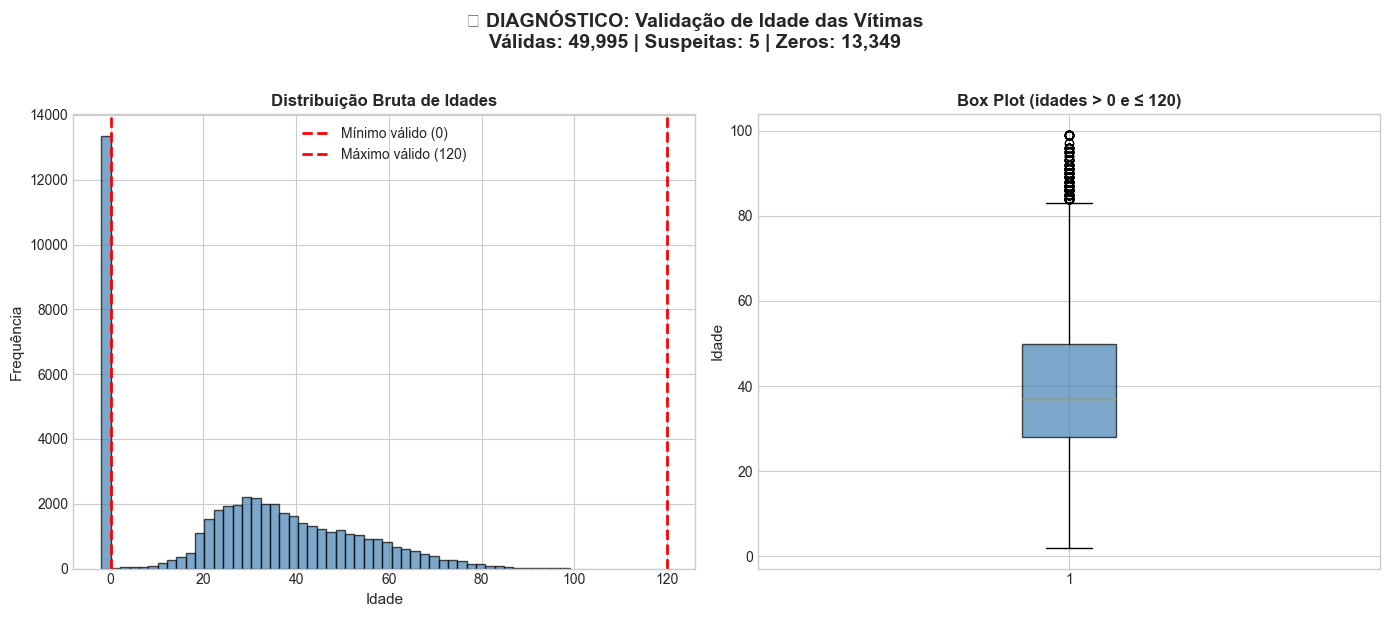


📋 Análise de Idades:
   Total com idade: 50,000
   Idades válidas (0-120): 49,995
   Idades = 0 (não informada?): 13,349
   Idades suspeitas (<0 ou >120): 5
   ⚠️ Valores suspeitos: min=-2, max=-1


In [ ]:
# 3.3 Análise de outliers em idade das vítimas
# Objetivo: identificar valores impossíveis

if 'Vict Age' in df_raw.columns:
    age_data = df_raw['Vict Age'].dropna()
    
    # Classificar idades
    valid_ages = age_data[(age_data >= 0) & (age_data <= 120)]
    suspicious_ages = age_data[(age_data < 0) | (age_data > 120)]
    zero_ages = age_data[age_data == 0]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Histograma
    ax1 = axes[0]
    ax1.hist(age_data, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Mínimo válido (0)')
    ax1.axvline(x=120, color='red', linestyle='--', linewidth=2, label='Máximo válido (120)')
    ax1.set_xlabel('Idade', fontsize=11)
    ax1.set_ylabel('Frequência', fontsize=11)
    ax1.set_title('Distribuição Bruta de Idades', fontsize=12, fontweight='bold')
    ax1.legend()
    
    # Box plot
    ax2 = axes[1]
    bp = ax2.boxplot(valid_ages[valid_ages > 0], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][0].set_alpha(0.7)
    ax2.set_ylabel('Idade', fontsize=11)
    ax2.set_title('Box Plot (idades > 0 e ≤ 120)', fontsize=12, fontweight='bold')
    
    plt.suptitle('DIAGNÓSTICO: Validação de Idade das Vítimas\n'
                 f'Válidas: {len(valid_ages):,} | Suspeitas: {len(suspicious_ages):,} | '
                 f'Zeros: {len(zero_ages):,}', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\nAnálise de Idades:")
    print(f"   Total com idade: {len(age_data):,}")
    print(f"   Idades válidas (0-120): {len(valid_ages):,}")
    print(f"   Idades = 0 (não informada?): {len(zero_ages):,}")
    print(f"   Idades suspeitas (<0 ou >120): {len(suspicious_ages):,}")
    if len(suspicious_ages) > 0:
        print(f"   Valores suspeitos: min={suspicious_ages.min()}, max={suspicious_ages.max()}")
else:
    print("Coluna 'Vict Age' não encontrada nos dados.")

---
## 📋 Resumo Diagnóstico da Camada RAW

Este notebook foi usado para:
- ✅ **Validação de ingestão:** Volume por ano/mês, detecção de gaps
- ✅ **Avaliação de qualidade:** Percentual de nulos, campos obrigatórios
- ✅ **Identificação de inconsistências:** Categorias raras, outliers em hora/coordenadas/idade

In [ ]:
# Resumo final
print("="*60)
print("RESUMO DIAGNÓSTICO - CAMADA RAW")
print("="*60)

print(f"\nArquivo: data_raw.csv")
print(f"Total de registros: {len(df_raw):,}")
print(f"Total de colunas: {len(df_raw.columns)}")

# Qualidade geral
total_nulls = df_raw.isnull().sum().sum()
total_cells = df_raw.shape[0] * df_raw.shape[1]
print(f"\nQUALIDADE GERAL:")
print(f"   Células nulas: {total_nulls:,} ({total_nulls/total_cells*100:.2f}%)")
print(f"   Células preenchidas: {total_cells - total_nulls:,} ({(total_cells - total_nulls)/total_cells*100:.2f}%)")

# Problemas identificados
print(f"\nPROBLEMAS IDENTIFICADOS:")
print(f"   1. Colunas com >50% nulos: {len(null_pct[null_pct > 50])}")
print(f"   2. Coordenadas zeradas: {len(df_raw[(df_raw['LAT'] == 0) | (df_raw['LON'] == 0)]):,}")
print(f"   3. Anos com volume anômalo: {len(yearly_counts[yearly_counts < mean_vol - std_vol])}")

print(f"\nRECOMENDAÇÕES PARA SILVER:")
print(f"   1. Remover ou imputar valores nulos críticos")
print(f"   2. Filtrar coordenadas inválidas")
print(f"   3. Padronizar categorias de crimes")
print(f"   4. Converter TIME OCC para formato de hora válido")
print("="*60)

📊 RESUMO DIAGNÓSTICO - CAMADA RAW

📁 Arquivo: data_raw.csv
📈 Total de registros: 50,000
📋 Total de colunas: 31

🔍 QUALIDADE GERAL:
   Células nulas: 277,587 (17.91%)
   Células preenchidas: 1,272,413 (82.09%)

⚠️ PROBLEMAS IDENTIFICADOS:
   1. Colunas com >50% nulos: 6
   2. Coordenadas zeradas: 113
   3. Anos com volume anômalo: 1

✅ RECOMENDAÇÕES PARA SILVER:
   1. Remover ou imputar valores nulos críticos
   2. Filtrar coordenadas inválidas
   3. Padronizar categorias de crimes
   4. Converter TIME OCC para formato de hora válido


# 📊 Análise Estatística de Dados de Crimes
## Crime Data from 2020 to Present - LAPD

Este notebook realiza análise estatística completa dos dados de crimes de Los Angeles, utilizando os módulos `mining.py` e `visualization.py`.

**Análises realizadas:**
1. Estatísticas Descritivas
2. Análise Temporal
3. Análise Geográfica
4. Perfil das Vítimas
5. Clustering e Padrões
6. Detecção de Anomalias

In [ ]:
# Configuração inicial
import sys
from pathlib import Path

# Configurar raiz do projeto
PROJECT_ROOT = Path.cwd().parent.parent  # Volta de Data Layer/raw para SBD2
RAW_PATH = PROJECT_ROOT / 'Data Layer' / 'raw' / 'data_raw.csv'
SILVER_PATH = PROJECT_ROOT / 'Data Layer' / 'silver' / 'data_silver.csv'

print(f"Projeto: {PROJECT_ROOT}")
print(f"Raw: {RAW_PATH}")
print(f"Silver: {SILVER_PATH}")

📁 Projeto: c:\Users\David\Documents\UnB\SBD2\SBD2
📥 Raw: c:\Users\David\Documents\UnB\SBD2\SBD2\Data Layer\raw\data_raw.csv
📤 Silver: c:\Users\David\Documents\UnB\SBD2\SBD2\Data Layer\silver\data_silver.csv


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Módulos do projeto
from src.mining import (
    perform_clustering, 
    find_optimal_clusters,
    detect_anomalies,
    apply_pca,
    temporal_pattern_analysis
)
from src.visualization import (
    plot_crime_distribution,
    plot_temporal_trends,
    plot_geographic_distribution,
    plot_victim_profile,
    plot_correlation_matrix,
    plot_cluster_analysis
)

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

print("Módulos carregados com sucesso!")

✅ Módulos carregados com sucesso!


## 1. Carregamento dos Dados

In [ ]:
# Carregar dados da camada Raw
RAW_PATH = PROJECT_ROOT / 'Data Layer' / 'raw'
SILVER_PATH = PROJECT_ROOT / 'Data Layer' / 'silver'

# Carregar dados Raw
df_raw = pd.read_csv(RAW_PATH / 'data_raw.csv')

# Converter colunas de data
date_cols = ['Date Rptd', 'DATE OCC']
for col in date_cols:
    if col in df_raw.columns:
        df_raw[col] = pd.to_datetime(df_raw[col], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Adicionar coluna de hora formatada
df_raw['HOUR'] = df_raw['TIME OCC'].astype(str).str.zfill(4).str[:2].astype(int)

print(f"Dados Raw carregados: {len(df_raw):,} registros")
print(f"Colunas: {len(df_raw.columns)}")
print(f"Período: {df_raw['DATE OCC'].min().strftime('%Y-%m-%d')} a {df_raw['DATE OCC'].max().strftime('%Y-%m-%d')}")

✅ Dados Raw carregados: 50,000 registros
📋 Colunas: 29
📅 Período: 2020-01-01 a 2025-03-06


In [ ]:
# Carregar dados Silver para análises mais detalhadas
df_silver = pd.read_csv(SILVER_PATH / 'data_silver.csv')

# Converter colunas de data no Silver
df_silver['date_occurred'] = pd.to_datetime(df_silver['date_occurred'], errors='coerce')
df_silver['date_reported'] = pd.to_datetime(df_silver['date_reported'], errors='coerce')

print(f"Dados Silver carregados: {len(df_silver):,} registros")
print(f"Colunas: {df_silver.columns.tolist()[:10]}...")
print(f"Redução Raw→Silver: {(1 - len(df_silver)/len(df_raw))*100:.1f}%")

✅ Dados Silver carregados: 38,405 registros
📋 Colunas: ['crime_id', 'date_reported', 'date_occurred', 'time_occurred', 'hour', 'day_of_week', 'day_name', 'period_of_day', 'area_code', 'area_name']...
📉 Redução Raw→Silver: 23.2%


## 2. Estatísticas Descritivas

In [38]:
# Estatísticas gerais
print("="*60)
print("ESTATÍSTICAS DESCRITIVAS - DADOS DE CRIMES")
print("="*60)

# Período dos dados
if 'date_occurred' in df_silver.columns:
    df_silver['date_occurred'] = pd.to_datetime(df_silver['date_occurred'])
    print(f"\nPeríodo: {df_silver['date_occurred'].min().date()} a {df_silver['date_occurred'].max().date()}")

# Total de registros
print(f"\nTotal de Crimes: {len(df_silver):,}")

# Crimes por tipo (top 10)
if 'crime_description' in df_silver.columns:
    print(f"\nTipos únicos de crime: {df_silver['crime_description'].nunique()}")
    print("\nTop 10 Tipos de Crime:")
    print(df_silver['crime_description'].value_counts().head(10))

# Crimes por área
if 'area_name' in df_silver.columns:
    print(f"\nÁreas: {df_silver['area_name'].nunique()}")

ESTATÍSTICAS DESCRITIVAS - DADOS DE CRIMES

Período: 2020-01-01 a 2024-12-30

Total de Crimes: 38,405

Tipos únicos de crime: 111

Top 10 Tipos de Crime:
crime_description
BATTERY - SIMPLE ASSAULT                                    3757
BURGLARY FROM VEHICLE                                       3223
THEFT OF IDENTITY                                           3130
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              2614
THEFT PLAIN - PETTY ($950 & UNDER)                          2454
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     2445
INTIMATE PARTNER - SIMPLE ASSAULT                           2276
BURGLARY                                                    2236
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)         1799
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    1501
Name: count, dtype: int64

Áreas: 21


In [39]:
# Estatísticas numéricas
print("\n" + "="*60)
print("ESTATÍSTICAS NUMÉRICAS")
print("="*60)

numeric_cols = df_silver.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nColunas numéricas: {numeric_cols}")

if 'victim_age' in df_silver.columns:
    valid_ages = df_silver[(df_silver['victim_age'] > 0) & (df_silver['victim_age'] < 120)]['victim_age']
    print(f"\nIdade das Vítimas:")
    print(f"   Média: {valid_ages.mean():.1f} anos")
    print(f"   Mediana: {valid_ages.median():.1f} anos")
    print(f"   Desvio Padrão: {valid_ages.std():.1f} anos")
    print(f"   Min-Max: {valid_ages.min():.0f} - {valid_ages.max():.0f} anos")

if 'latitude' in df_silver.columns and 'longitude' in df_silver.columns:
    valid_coords = df_silver[(df_silver['latitude'] != 0) & (df_silver['longitude'] != 0)]
    print(f"\nCoordenadas válidas: {len(valid_coords):,} ({100*len(valid_coords)/len(df_silver):.1f}%)")


ESTATÍSTICAS NUMÉRICAS

Colunas numéricas: ['crime_id', 'hour', 'day_of_week', 'area_code', 'district_code', 'crime_code', 'victim_age', 'premise_code', 'weapon_code', 'latitude', 'longitude', 'year', 'month', 'quarter']

Idade das Vítimas:
   Média: 39.5 anos
   Mediana: 37.0 anos
   Desvio Padrão: 15.5 anos
   Min-Max: 2 - 99 anos

Coordenadas válidas: 38,405 (100.0%)


## 3. Análise Temporal

In [40]:
# Análise temporal
if 'date_occurred' in df_silver.columns:
    df_silver['date_occurred'] = pd.to_datetime(df_silver['date_occurred'])
    df_silver['year'] = df_silver['date_occurred'].dt.year
    df_silver['month'] = df_silver['date_occurred'].dt.month
    df_silver['day_of_week'] = df_silver['date_occurred'].dt.day_name()
    
    print("="*60)
    print("ANÁLISE TEMPORAL")
    print("="*60)
    
    # Crimes por ano
    print("\nCrimes por Ano:")
    yearly = df_silver.groupby('year').size()
    for year, count in yearly.items():
        print(f"   {year}: {count:,}")
    
    # Tendência
    if len(yearly) > 1:
        trend = yearly.iloc[-1] - yearly.iloc[0]
        trend_pct = 100 * trend / yearly.iloc[0]
        print(f"\n   Tendência: {'+' if trend > 0 else ''}{trend:,} ({trend_pct:+.1f}%)")

ANÁLISE TEMPORAL

Crimes por Ano:
   2020.0: 6,180
   2021.0: 6,162
   2022.0: 7,206
   2023.0: 6,816
   2024.0: 3,100

   Tendência: -3,080 (-49.8%)


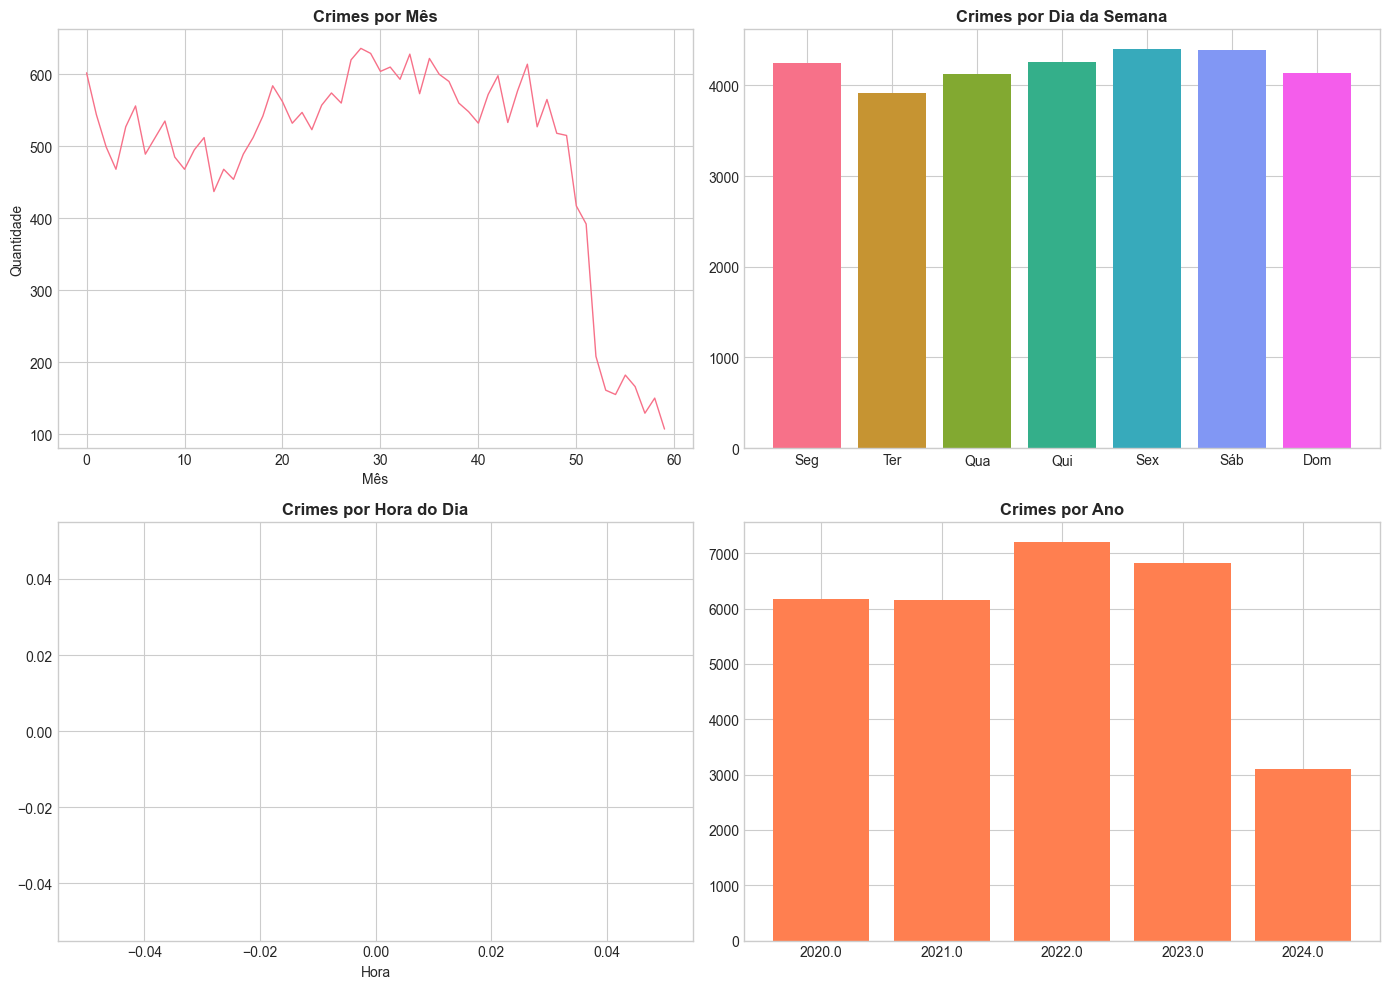


Gráficos temporais gerados!


In [41]:
# Visualização temporal
if 'date_occurred' in df_silver.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Crimes por mês
    monthly = df_silver.groupby(df_silver['date_occurred'].dt.to_period('M')).size()
    axes[0, 0].plot(range(len(monthly)), monthly.values, marker='', linewidth=1)
    axes[0, 0].set_title('Crimes por Mês', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Mês')
    axes[0, 0].set_ylabel('Quantidade')
    
    # Crimes por dia da semana
    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow = df_silver['day_of_week'].value_counts().reindex(dow_order)
    colors = sns.color_palette('husl', 7)
    axes[0, 1].bar(range(7), dow.values, color=colors)
    axes[0, 1].set_xticks(range(7))
    axes[0, 1].set_xticklabels(['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'])
    axes[0, 1].set_title('Crimes por Dia da Semana', fontsize=12, fontweight='bold')
    
    # Crimes por hora (se disponível)
    if 'time_occurred' in df_silver.columns:
        try:
            df_silver['hour'] = pd.to_datetime(df_silver['time_occurred'].astype(str).str.zfill(4), format='%H%M', errors='coerce').dt.hour
            hourly = df_silver.groupby('hour').size()
            axes[1, 0].bar(hourly.index, hourly.values, color='steelblue')
            axes[1, 0].set_title('Crimes por Hora do Dia', fontsize=12, fontweight='bold')
            axes[1, 0].set_xlabel('Hora')
        except:
            axes[1, 0].text(0.5, 0.5, 'Dados de hora não disponíveis', ha='center', va='center')
    
    # Crimes por ano
    yearly = df_silver.groupby('year').size()
    axes[1, 1].bar(yearly.index.astype(str), yearly.values, color='coral')
    axes[1, 1].set_title('Crimes por Ano', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nGráficos temporais gerados!")

## 4. Análise de Tipos de Crime

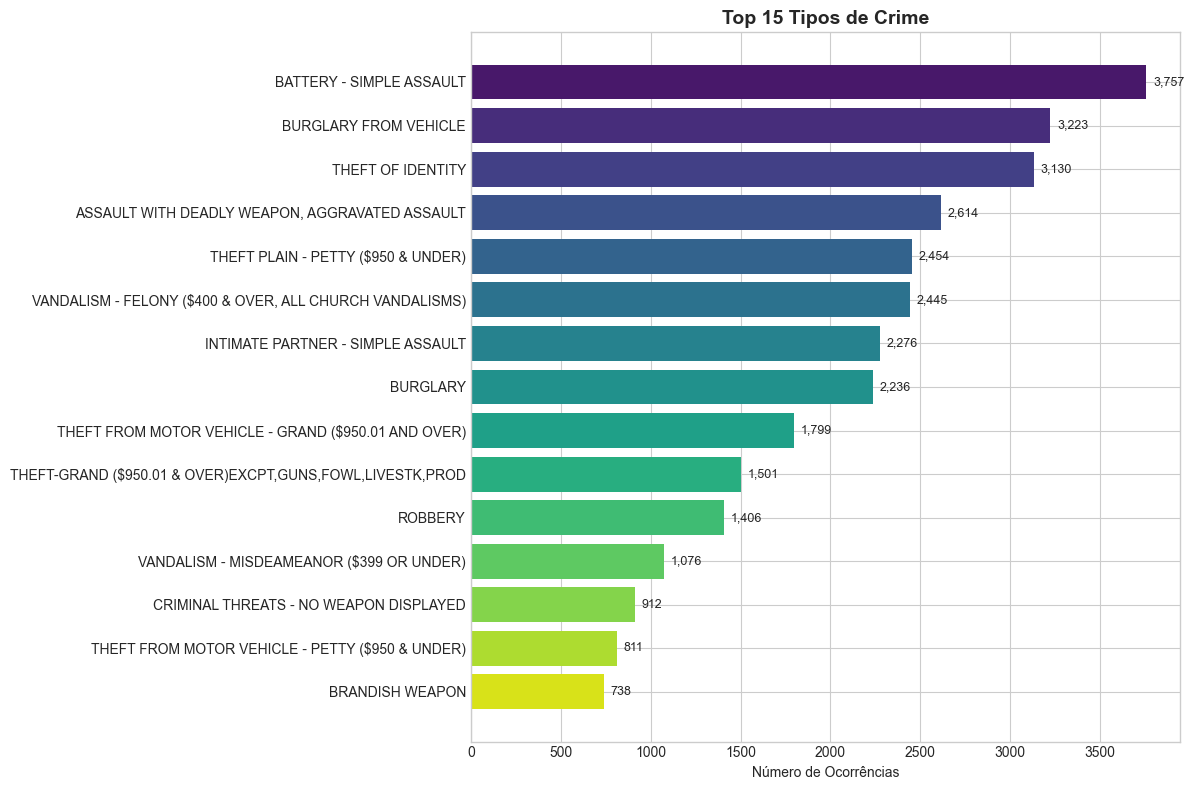


Concentração dos Crimes:
   Top 5 tipos: 39.5% dos crimes
   Top 10 tipos: 66.2% dos crimes


In [42]:
# Top 15 tipos de crime
if 'crime_description' in df_silver.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    top_crimes = df_silver['crime_description'].value_counts().head(15)
    
    bars = ax.barh(range(len(top_crimes)), top_crimes.values, color=sns.color_palette('viridis', 15))
    ax.set_yticks(range(len(top_crimes)))
    ax.set_yticklabels(top_crimes.index)
    ax.invert_yaxis()
    
    # Adicionar valores
    for i, (bar, val) in enumerate(zip(bars, top_crimes.values)):
        ax.text(val + max(top_crimes.values) * 0.01, i, f'{val:,}', va='center', fontsize=9)
    
    ax.set_xlabel('Número de Ocorrências')
    ax.set_title('Top 15 Tipos de Crime', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas
    print(f"\nConcentração dos Crimes:")
    total = len(df_silver)
    top5_pct = 100 * top_crimes.head(5).sum() / total
    top10_pct = 100 * top_crimes.head(10).sum() / total
    print(f"   Top 5 tipos: {top5_pct:.1f}% dos crimes")
    print(f"   Top 10 tipos: {top10_pct:.1f}% dos crimes")

## 5. Análise Geográfica

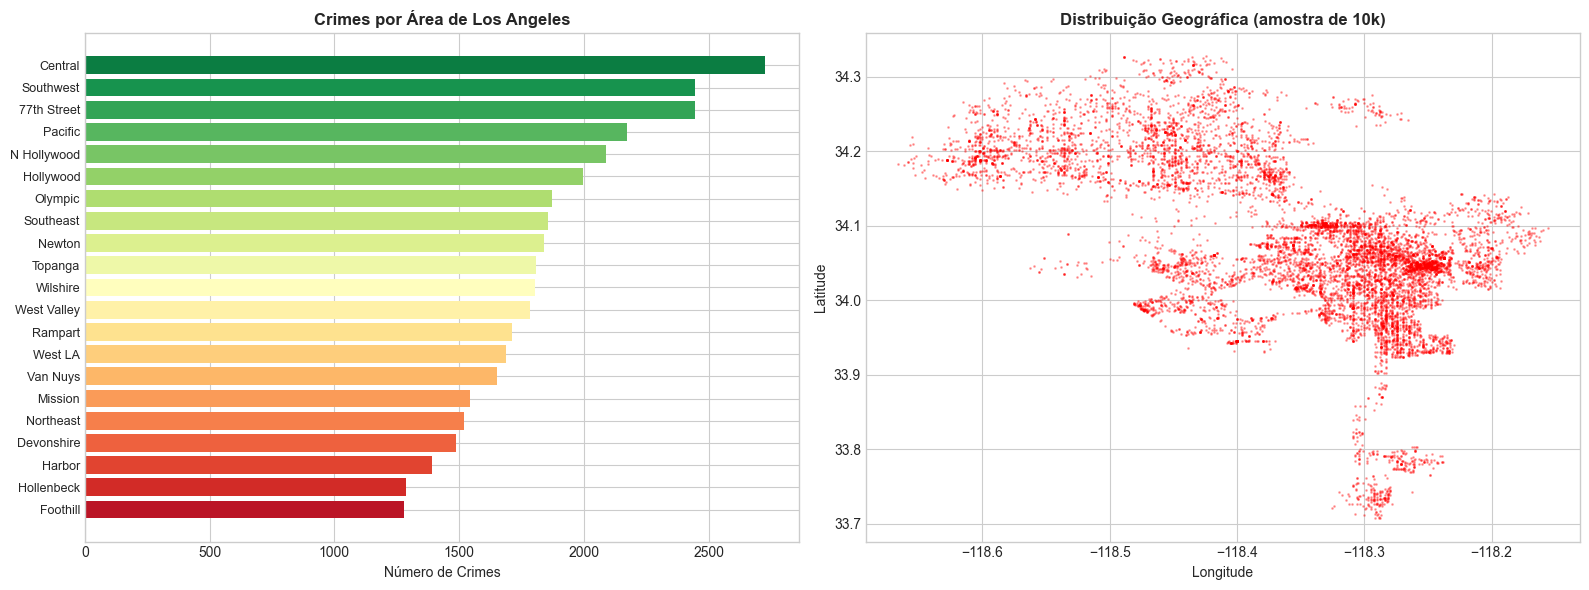


Top 5 Áreas com Mais Crimes:
   1. Central: 2,727 (7.1%)
   2. Southwest: 2,447 (6.4%)
   3. 77th Street: 2,445 (6.4%)
   4. Pacific: 2,174 (5.7%)
   5. N Hollywood: 2,090 (5.4%)


In [43]:
# Crimes por área
if 'area_name' in df_silver.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Barras
    area_counts = df_silver['area_name'].value_counts()
    colors = sns.color_palette('RdYlGn_r', len(area_counts))
    
    axes[0].barh(range(len(area_counts)), area_counts.values, color=colors)
    axes[0].set_yticks(range(len(area_counts)))
    axes[0].set_yticklabels(area_counts.index, fontsize=9)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Número de Crimes')
    axes[0].set_title('Crimes por Área de Los Angeles', fontsize=12, fontweight='bold')
    
    # Mapa de dispersão
    if 'latitude' in df_silver.columns and 'longitude' in df_silver.columns:
        valid = df_silver[(df_silver['latitude'] != 0) & (df_silver['longitude'] != 0)]
        sample = valid.sample(min(10000, len(valid)), random_state=42)
        
        axes[1].scatter(sample['longitude'], sample['latitude'], alpha=0.3, s=1, c='red')
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')
        axes[1].set_title('Distribuição Geográfica (amostra de 10k)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Top 5 áreas mais perigosas
    print("\nTop 5 Áreas com Mais Crimes:")
    for i, (area, count) in enumerate(area_counts.head(5).items(), 1):
        pct = 100 * count / len(df_silver)
        print(f"   {i}. {area}: {count:,} ({pct:.1f}%)")

## 6. Perfil das Vítimas

PERFIL DAS VÍTIMAS


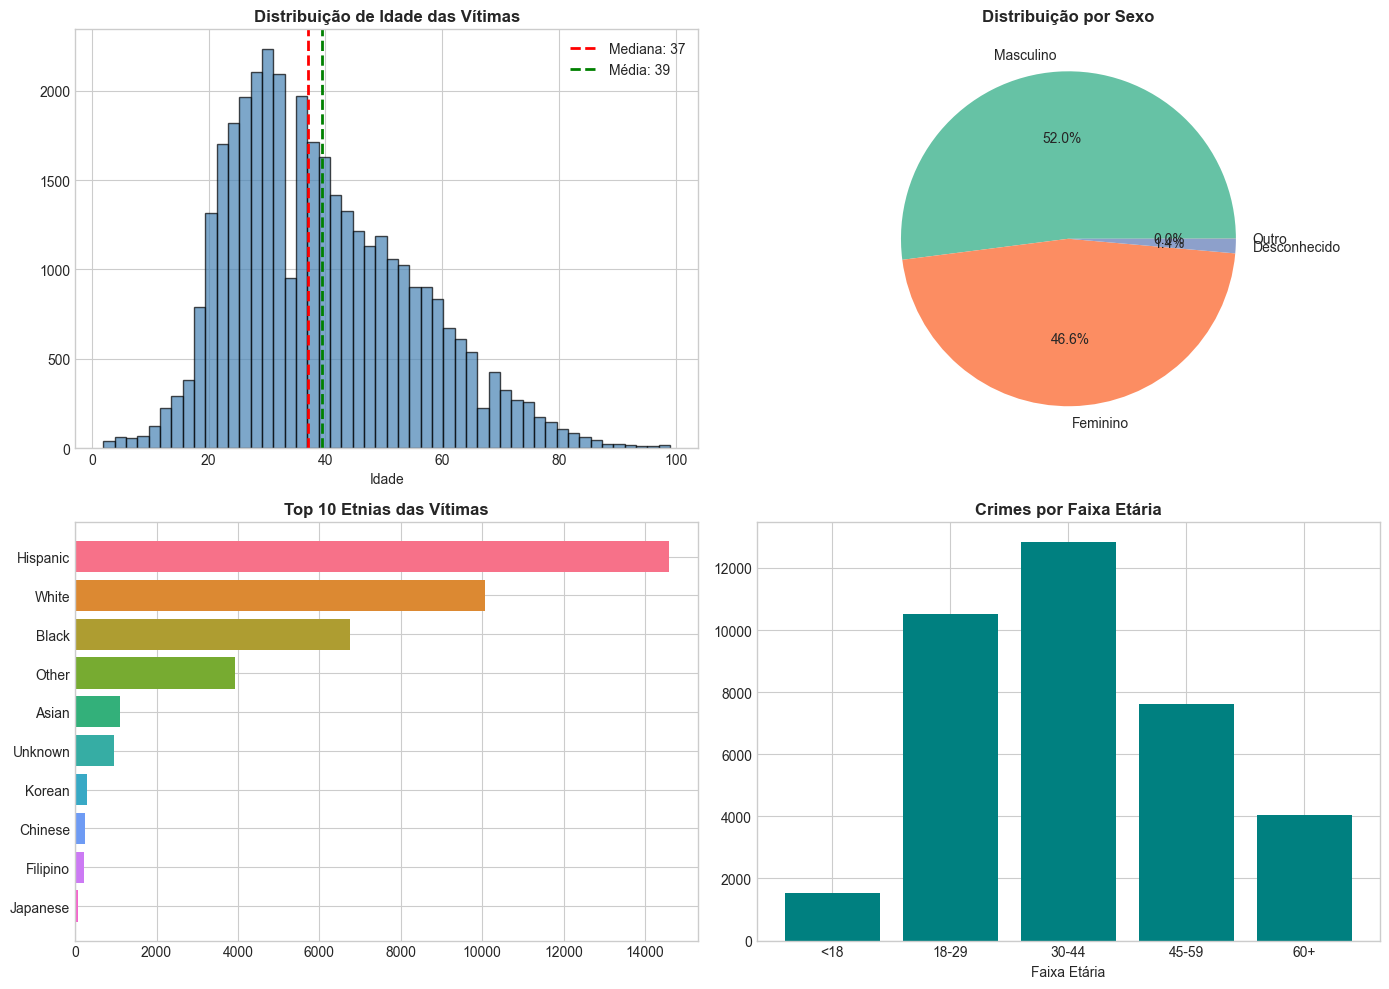

In [44]:
# Análise de vítimas
print("="*60)
print("PERFIL DAS VÍTIMAS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Idade
if 'victim_age' in df_silver.columns:
    valid_ages = df_silver[(df_silver['victim_age'] > 0) & (df_silver['victim_age'] < 120)]['victim_age']
    axes[0, 0].hist(valid_ages, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].axvline(valid_ages.median(), color='red', linestyle='--', linewidth=2, label=f'Mediana: {valid_ages.median():.0f}')
    axes[0, 0].axvline(valid_ages.mean(), color='green', linestyle='--', linewidth=2, label=f'Média: {valid_ages.mean():.0f}')
    axes[0, 0].set_title('Distribuição de Idade das Vítimas', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Idade')
    axes[0, 0].legend()

# Sexo
if 'victim_sex' in df_silver.columns:
    sex_counts = df_silver['victim_sex'].value_counts()
    sex_labels = {'M': 'Masculino', 'F': 'Feminino', 'X': 'Desconhecido', 'H': 'Outro'}
    labels = [sex_labels.get(s, s) for s in sex_counts.index]
    axes[0, 1].pie(sex_counts.values, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
    axes[0, 1].set_title('Distribuição por Sexo', fontsize=12, fontweight='bold')

# Descendência
if 'victim_descent' in df_silver.columns:
    descent_counts = df_silver['victim_descent'].value_counts().head(10)
    descent_labels = {
        'H': 'Hispanic', 'W': 'White', 'B': 'Black', 'O': 'Other',
        'A': 'Asian', 'X': 'Unknown', 'K': 'Korean', 'F': 'Filipino',
        'C': 'Chinese', 'J': 'Japanese', 'V': 'Vietnamese'
    }
    labels = [descent_labels.get(d, d) for d in descent_counts.index]
    axes[1, 0].barh(range(len(descent_counts)), descent_counts.values, color=sns.color_palette('husl', 10))
    axes[1, 0].set_yticks(range(len(descent_counts)))
    axes[1, 0].set_yticklabels(labels)
    axes[1, 0].invert_yaxis()
    axes[1, 0].set_title('Top 10 Etnias das Vítimas', fontsize=12, fontweight='bold')

# Faixa etária
if 'victim_age' in df_silver.columns:
    bins = [0, 18, 30, 45, 60, 120]
    labels = ['<18', '18-29', '30-44', '45-59', '60+']
    df_silver['age_group'] = pd.cut(df_silver['victim_age'], bins=bins, labels=labels)
    age_group = df_silver['age_group'].value_counts().sort_index()
    axes[1, 1].bar(age_group.index.astype(str), age_group.values, color='teal')
    axes[1, 1].set_title('Crimes por Faixa Etária', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Faixa Etária')

plt.tight_layout()
plt.show()

## 7. Clustering e Padrões

In [45]:
# Preparar dados para clustering
print("="*60)
print("ANÁLISE DE CLUSTERING")
print("="*60)

# Selecionar features numéricas para clustering
cluster_features = []
if 'latitude' in df_silver.columns:
    cluster_features.append('latitude')
if 'longitude' in df_silver.columns:
    cluster_features.append('longitude')
if 'victim_age' in df_silver.columns:
    cluster_features.append('victim_age')

if len(cluster_features) >= 2:
    # Filtrar dados válidos
    df_cluster = df_silver.copy()
    if 'latitude' in cluster_features:
        df_cluster = df_cluster[(df_cluster['latitude'] != 0) & (df_cluster['longitude'] != 0)]
    if 'victim_age' in cluster_features:
        df_cluster = df_cluster[(df_cluster['victim_age'] > 0) & (df_cluster['victim_age'] < 120)]
    
    # Amostrar para performance
    sample_size = min(10000, len(df_cluster))
    df_sample = df_cluster.sample(sample_size, random_state=42)
    
    print(f"\n Features para clustering: {cluster_features}")
    print(f"   Amostra: {sample_size:,} registros")
    
    # Aplicar clustering
    df_clustered, model = perform_clustering(
        df_sample, 
        features=cluster_features,
        n_clusters=5,
        method='kmeans'
    )
    
    print(f"\n Distribuição dos Clusters:")
    cluster_dist = df_clustered['Cluster'].value_counts().sort_index()
    for cluster, count in cluster_dist.items():
        print(f"   Cluster {int(cluster)}: {count:,} ({100*count/len(df_clustered):.1f}%)")
else:
    print("\n Não há features numéricas suficientes para clustering")

ANÁLISE DE CLUSTERING

 Features para clustering: ['latitude', 'longitude', 'victim_age']
   Amostra: 10,000 registros
Silhouette Score: 0.356

 Distribuição dos Clusters:
   Cluster 0: 1,891 (18.9%)
   Cluster 1: 4,403 (44.0%)
   Cluster 2: 1,109 (11.1%)
   Cluster 3: 346 (3.5%)
   Cluster 4: 2,251 (22.5%)


Variância explicada: 86.07%


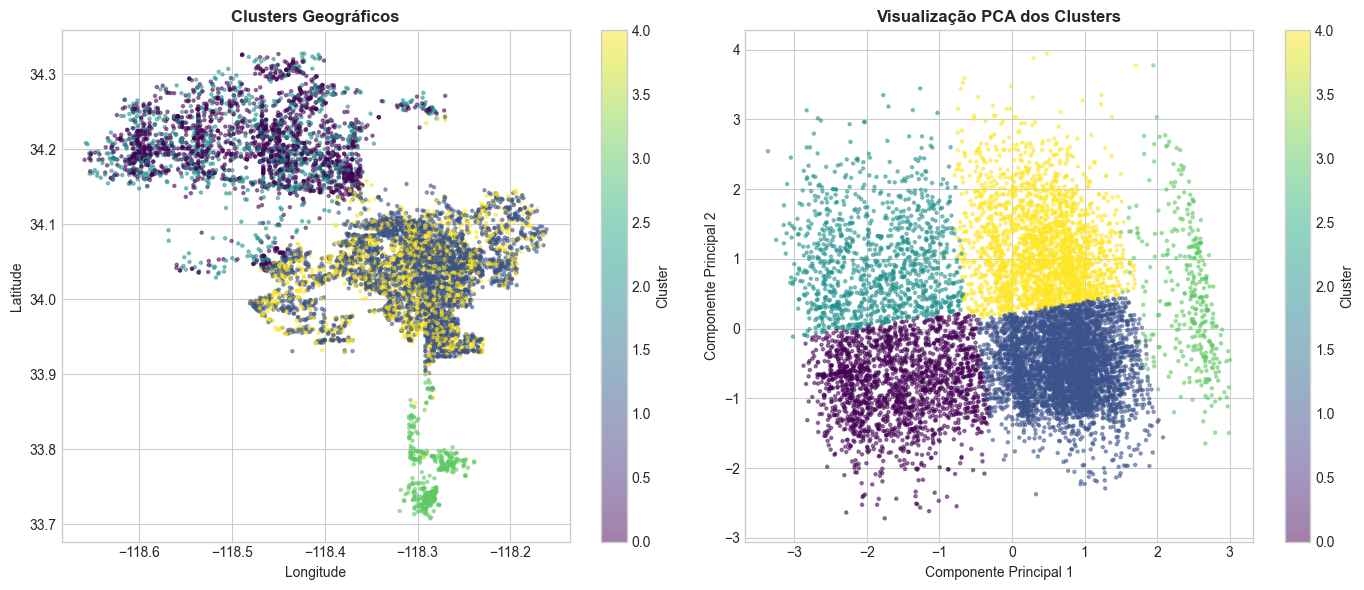

In [46]:
# Visualização dos clusters
if 'df_clustered' in dir() and 'Cluster' in df_clustered.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Clusters no espaço geográfico
    if 'latitude' in cluster_features and 'longitude' in cluster_features:
        scatter = axes[0].scatter(
            df_clustered['longitude'], 
            df_clustered['latitude'],
            c=df_clustered['Cluster'],
            cmap='viridis',
            alpha=0.5,
            s=5
        )
        plt.colorbar(scatter, ax=axes[0], label='Cluster')
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')
        axes[0].set_title('Clusters Geográficos', fontsize=12, fontweight='bold')
    
    # PCA
    X_pca, pca = apply_pca(df_clustered, features=cluster_features, n_components=2)
    scatter2 = axes[1].scatter(
        X_pca[:, 0], 
        X_pca[:, 1],
        c=df_clustered['Cluster'].dropna(),
        cmap='viridis',
        alpha=0.5,
        s=5
    )
    plt.colorbar(scatter2, ax=axes[1], label='Cluster')
    axes[1].set_xlabel('Componente Principal 1')
    axes[1].set_ylabel('Componente Principal 2')
    axes[1].set_title('Visualização PCA dos Clusters', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 8. Detecção de Anomalias

DETECÇÃO DE ANOMALIAS
Anomalias detectadas: 500 (5.00%)


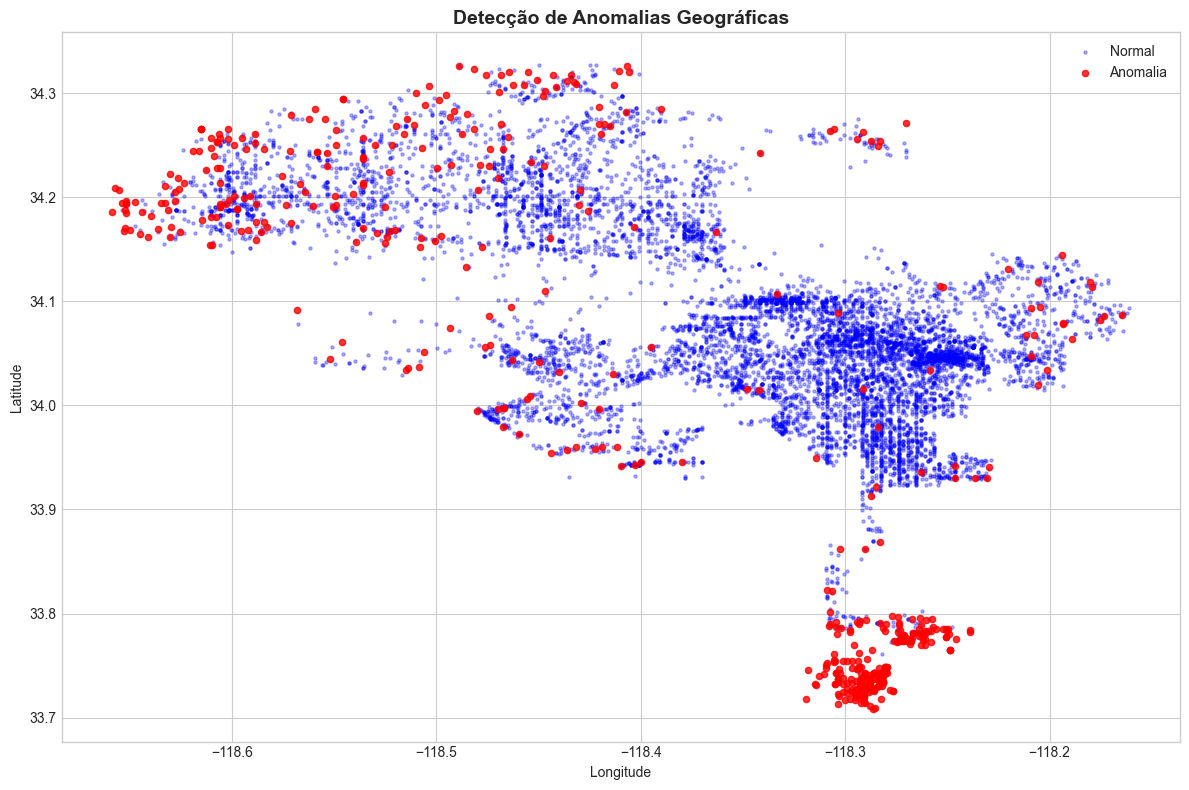

In [47]:
# Detecção de anomalias
print("="*60)
print("DETECÇÃO DE ANOMALIAS")
print("="*60)

if len(cluster_features) >= 2 and 'df_sample' in dir():
    df_anomalies = detect_anomalies(
        df_sample,
        features=cluster_features,
        contamination=0.05
    )
    
    # Visualizar anomalias
    if 'latitude' in cluster_features and 'longitude' in cluster_features:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        normal = df_anomalies[df_anomalies['Is_Anomaly'] == 0]
        anomalies = df_anomalies[df_anomalies['Is_Anomaly'] == 1]
        
        ax.scatter(normal['longitude'], normal['latitude'], alpha=0.3, s=5, c='blue', label='Normal')
        ax.scatter(anomalies['longitude'], anomalies['latitude'], alpha=0.8, s=20, c='red', label='Anomalia')
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Detecção de Anomalias Geográficas', fontsize=14, fontweight='bold')
        ax.legend()
        
        plt.tight_layout()
        plt.show()
else:
    print("\n Dados insuficientes para detecção de anomalias")

## 9. Correlações

ANÁLISE DE CORRELAÇÕES


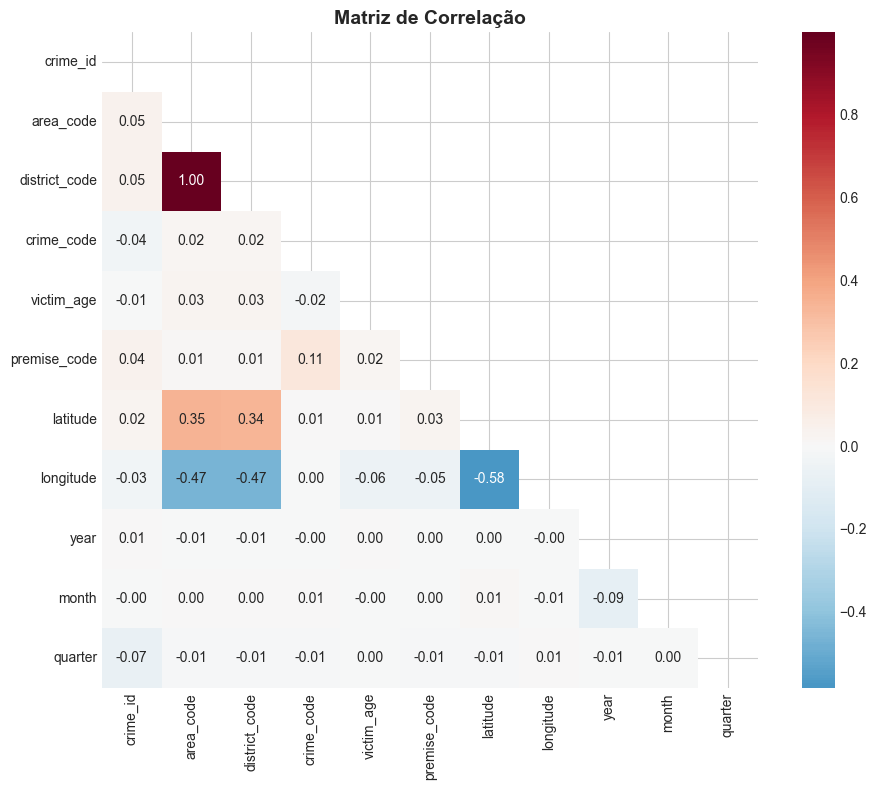


 Correlações Mais Fortes (excluindo diagonal):
   area_code ↔ district_code: 0.999
   latitude ↔ longitude: -0.584
   district_code ↔ longitude: -0.466
   area_code ↔ longitude: -0.465
   area_code ↔ latitude: 0.345


In [48]:
# Matriz de correlação
print("="*60)
print("ANÁLISE DE CORRELAÇÕES")
print("="*60)

numeric_df = df_silver.select_dtypes(include=[np.number])

if len(numeric_df.columns) >= 2:
    # Remover colunas com muitos NaN
    valid_cols = numeric_df.columns[numeric_df.notna().mean() > 0.5]
    numeric_df = numeric_df[valid_cols]
    
    if len(numeric_df.columns) >= 2:
        corr_matrix = numeric_df.corr()
        
        fig, ax = plt.subplots(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, 
                    annot=True, fmt='.2f', ax=ax, square=True)
        ax.set_title('Matriz de Correlação', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Correlações mais fortes
        print("\n Correlações Mais Fortes (excluindo diagonal):")
        corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
        
        corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
        for col1, col2, corr in corr_pairs[:5]:
            print(f"   {col1} ↔ {col2}: {corr:.3f}")

## 10. Resumo Estatístico

In [49]:
# Resumo final
print("\n" + "="*60)
print("RESUMO DA ANÁLISE ESTATÍSTICA")
print("="*60)

print(f"\nDataset: Crime Data from 2020 to Present - LAPD")
print(f"Total de registros analisados: {len(df_silver):,}")

if 'date_occurred' in df_silver.columns:
    print(f"Período: {df_silver['date_occurred'].min().date()} a {df_silver['date_occurred'].max().date()}")

if 'crime_description' in df_silver.columns:
    print(f" Tipos de crime: {df_silver['crime_description'].nunique()}")
    print(f"   Mais comum: {df_silver['crime_description'].mode().iloc[0]}")

if 'area_name' in df_silver.columns:
    print(f" Áreas: {df_silver['area_name'].nunique()}")
    print(f"   Mais crimes: {df_silver['area_name'].mode().iloc[0]}")

if 'victim_age' in df_silver.columns:
    valid_ages = df_silver[(df_silver['victim_age'] > 0) & (df_silver['victim_age'] < 120)]['victim_age']
    print(f" Idade média das vítimas: {valid_ages.mean():.1f} anos")

print("\nAnálise estatística concluída com sucesso!")
print("="*60)


RESUMO DA ANÁLISE ESTATÍSTICA

Dataset: Crime Data from 2020 to Present - LAPD
Total de registros analisados: 38,405
Período: 2020-01-01 a 2024-12-30
 Tipos de crime: 111
   Mais comum: BATTERY - SIMPLE ASSAULT
 Áreas: 21
   Mais crimes: Central
 Idade média das vítimas: 39.5 anos

Análise estatística concluída com sucesso!


---
# 📈 ANÁLISE EXPLORATÓRIA AVANÇADA (EDA)

Análises detalhadas da evolução da criminalidade, padrões temporais e distribuição por tipo de crime.

In [50]:
# Carregar dados completos do CSV original para análise multi-ano
import os

# Verificar se há mais dados disponíveis
RAW_PATH = PROJECT_ROOT / "Crime_Data_from_2020_to_Present.csv"

if RAW_PATH.exists():
    print(f"📂 Carregando dados completos de: {RAW_PATH}")
    df_full = pd.read_csv(RAW_PATH, low_memory=False)
    
    # Converter datas
    df_full['DATE OCC'] = pd.to_datetime(df_full['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    df_full['Date Rptd'] = pd.to_datetime(df_full['Date Rptd'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    
    # Extrair componentes temporais
    df_full['year'] = df_full['DATE OCC'].dt.year
    df_full['month'] = df_full['DATE OCC'].dt.month
    df_full['day'] = df_full['DATE OCC'].dt.day
    df_full['hour'] = df_full['TIME OCC'] // 100
    df_full['day_of_week'] = df_full['DATE OCC'].dt.dayofweek
    df_full['day_name'] = df_full['DATE OCC'].dt.day_name()
    df_full['week_of_year'] = df_full['DATE OCC'].dt.isocalendar().week
    df_full['quarter'] = df_full['DATE OCC'].dt.quarter
    
    # Definir estações do ano
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Inverno'
        elif month in [3, 4, 5]:
            return 'Primavera'
        elif month in [6, 7, 8]:
            return 'Verão'
        else:
            return 'Outono'
    
    df_full['season'] = df_full['month'].apply(get_season)
    
    # Período do dia
    def get_period(hour):
        if 5 <= hour < 12:
            return 'Manhã'
        elif 12 <= hour < 18:
            return 'Tarde'
        elif 18 <= hour < 22:
            return 'Noite'
        else:
            return 'Madrugada'
    
    df_full['period_of_day'] = df_full['hour'].apply(get_period)
    
    # Fim de semana
    df_full['is_weekend'] = df_full['day_of_week'].isin([5, 6]).astype(int)
    
    print(f"\n Dados carregados: {len(df_full):,} registros")
    print(f" Período: {df_full['DATE OCC'].min().date()} a {df_full['DATE OCC'].max().date()}")
    print(f" Anos disponíveis: {sorted(df_full['year'].dropna().unique().astype(int))}")
else:
    print(" Usando apenas dados da camada Silver (amostra)")
    df_full = df_silver.copy()
    df_full['DATE OCC'] = df_full['date_occurred']
    df_full['year'] = df_full['DATE OCC'].dt.year
    df_full['Crm Cd Desc'] = df_full['crime_description']
    df_full['AREA NAME'] = df_full['area_name']
    df_full['LAT'] = df_full['latitude']
    df_full['LON'] = df_full['longitude']
    df_full['Vict Age'] = df_full['victim_age']
    df_full['TIME OCC'] = df_full['time_occurred']
    df_full['hour'] = df_full['hour_occurred']

📂 Carregando dados completos de: c:\Users\David\Documents\UnB\SBD2\SBD2\Crime_Data_from_2020_to_Present.csv

 Dados carregados: 1,004,991 registros
 Período: 2020-01-01 a 2025-05-29
 Anos disponíveis: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


EVOLUÇÃO DA CRIMINALIDADE - ANÁLISE TEMPORAL MULTI-ANO

Variação Anual:
   2020 → 2021: +5.0%
   2021 → 2022: +12.1%
   2022 → 2023: -1.2%
   2023 → 2024: -45.1%
   2024 → 2025: -99.9%


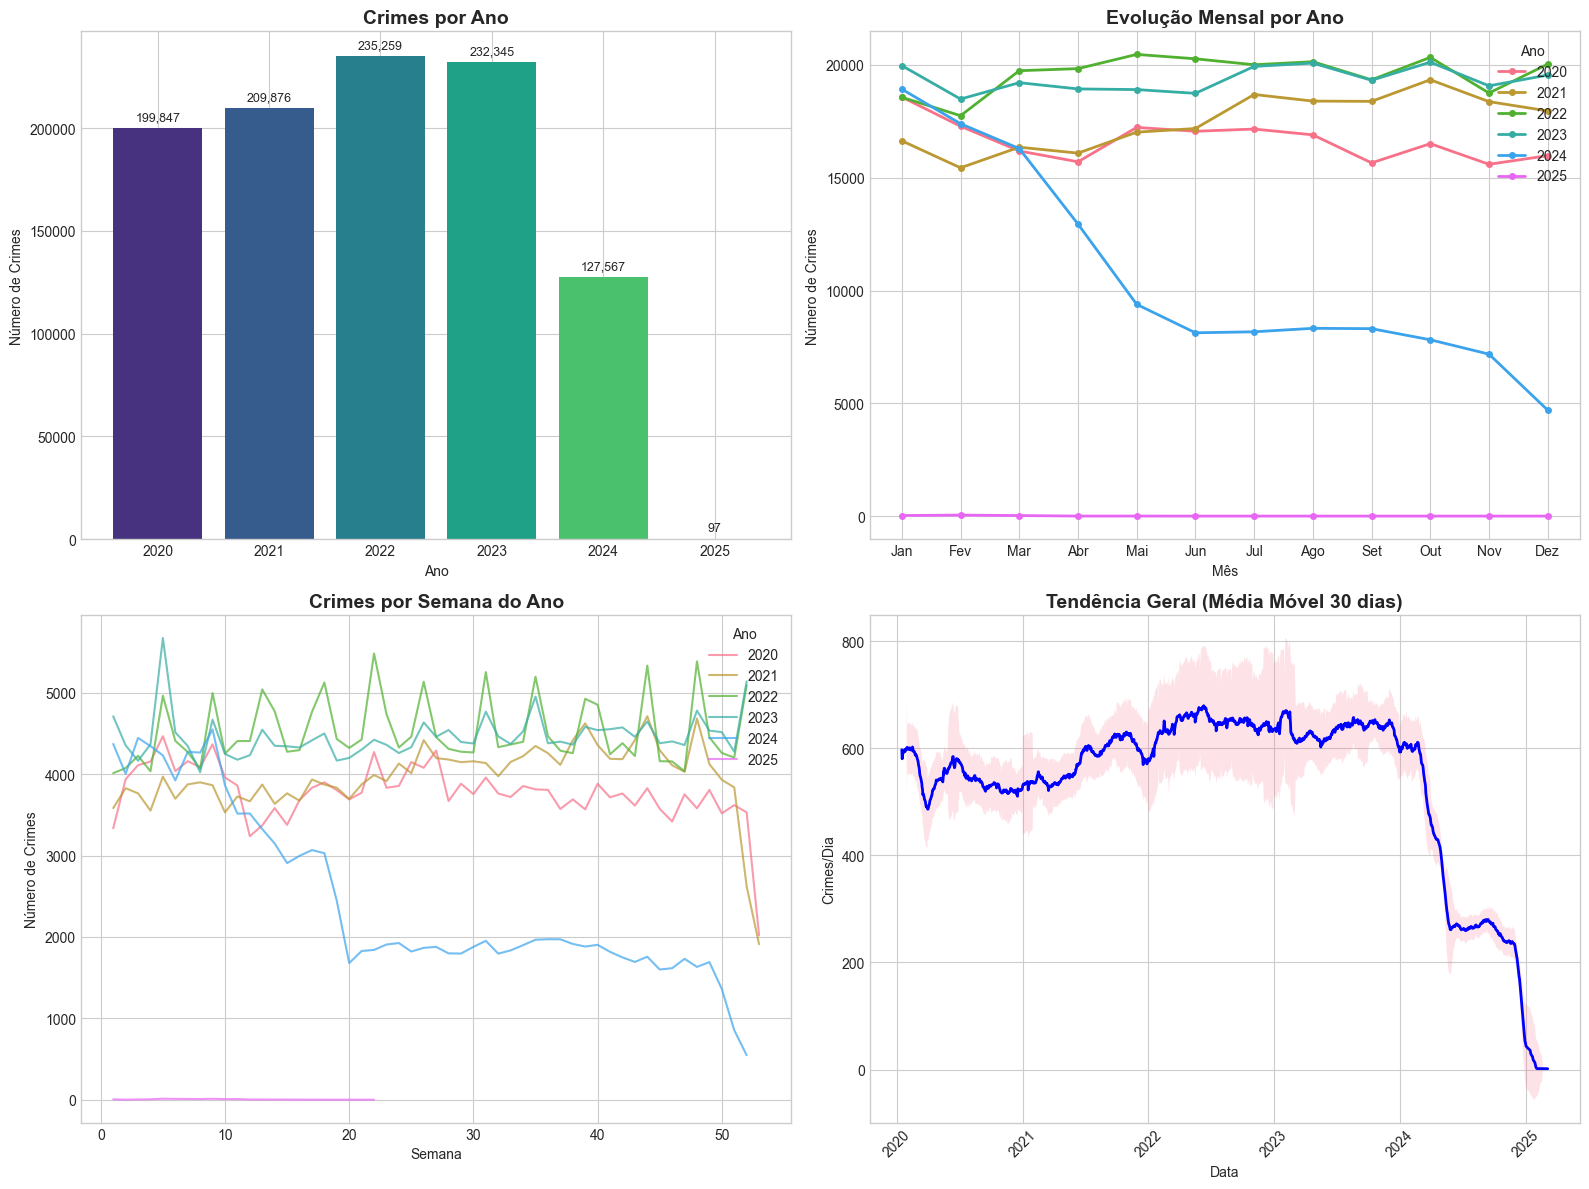


Tendência de Longo Prazo:
   2020 → 2025: -100.0%


In [51]:
# 11.1 Evolução da Criminalidade ao Longo do Tempo
print("="*70)
print("EVOLUÇÃO DA CRIMINALIDADE - ANÁLISE TEMPORAL MULTI-ANO")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Crimes por ano
yearly_crimes = df_full.groupby('year').size()
ax1 = axes[0, 0]
bars = ax1.bar(yearly_crimes.index.astype(int).astype(str), yearly_crimes.values, 
               color=sns.color_palette('viridis', len(yearly_crimes)))
ax1.set_title('Crimes por Ano', fontsize=14, fontweight='bold')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Crimes')
for bar, val in zip(bars, yearly_crimes.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + max(yearly_crimes)*0.01, 
             f'{val:,}', ha='center', va='bottom', fontsize=9)

# Calcular variação percentual
if len(yearly_crimes) > 1:
    pct_changes = yearly_crimes.pct_change() * 100
    print("\nVariação Anual:")
    for yr, pct in pct_changes.dropna().items():
        print(f"   {int(yr-1)} → {int(yr)}: {pct:+.1f}%")

# Crimes por mês (todas os anos)
monthly_crimes = df_full.groupby([df_full['year'], df_full['month']]).size().unstack(fill_value=0)
ax2 = axes[0, 1]
for year in monthly_crimes.index:
    ax2.plot(monthly_crimes.columns, monthly_crimes.loc[year], marker='o', 
             label=str(int(year)), linewidth=2, markersize=4)
ax2.set_title('Evolução Mensal por Ano', fontsize=14, fontweight='bold')
ax2.set_xlabel('Mês')
ax2.set_ylabel('Número de Crimes')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
                     'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax2.legend(title='Ano', loc='upper right')

# Crimes por semana do ano
weekly = df_full.groupby(['year', 'week_of_year']).size().reset_index(name='count')
ax3 = axes[1, 0]
for year in weekly['year'].unique():
    data = weekly[weekly['year'] == year]
    ax3.plot(data['week_of_year'], data['count'], alpha=0.7, label=str(int(year)))
ax3.set_title('Crimes por Semana do Ano', fontsize=14, fontweight='bold')
ax3.set_xlabel('Semana')
ax3.set_ylabel('Número de Crimes')
ax3.legend(title='Ano', loc='upper right')

# Tendência geral (média móvel)
ax4 = axes[1, 1]
daily = df_full.groupby(df_full['DATE OCC'].dt.date).size()
daily_series = pd.Series(daily.values, index=pd.to_datetime(daily.index))
ma_30 = daily_series.rolling(window=30, center=True).mean()
ax4.plot(daily_series.index, ma_30, color='blue', linewidth=2, label='Média Móvel 30 dias')
ax4.fill_between(daily_series.index, ma_30 - daily_series.rolling(30).std(), 
                  ma_30 + daily_series.rolling(30).std(), alpha=0.2)
ax4.set_title('Tendência Geral (Média Móvel 30 dias)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Data')
ax4.set_ylabel('Crimes/Dia')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Estatísticas de tendência
print(f"\nTendência de Longo Prazo:")
first_year = yearly_crimes.iloc[0]
last_year = yearly_crimes.iloc[-1]
total_change = ((last_year - first_year) / first_year) * 100
print(f"   {int(yearly_crimes.index[0])} → {int(yearly_crimes.index[-1])}: {total_change:+.1f}%")

HEATMAP: HORA DO DIA × DIA DA SEMANA


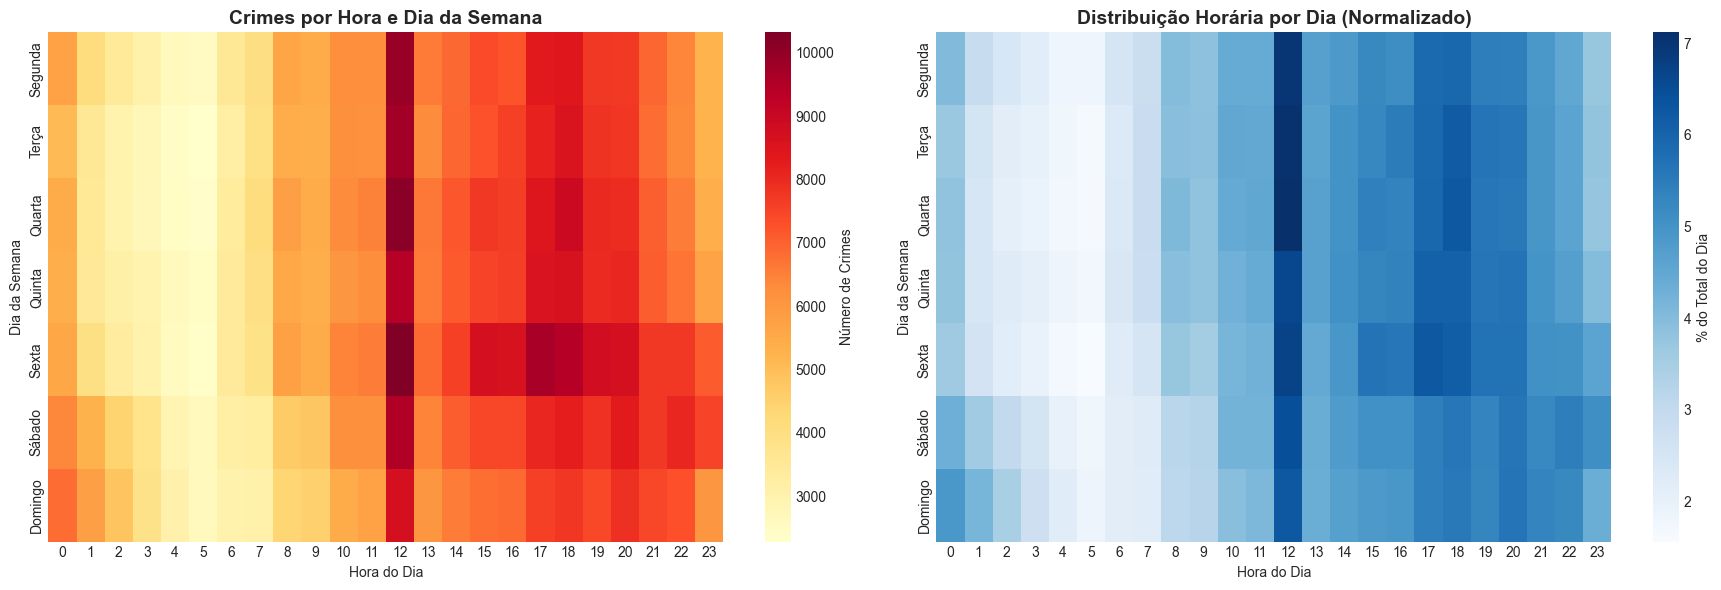


Análise de Padrões:
   Madrugada (00h-05h): 153,681 (15.3%)
   Manhã (06h-11h): 209,918 (20.9%)
   Tarde (12h-17h): 327,312 (32.6%)
   Noite (18h-23h): 314,080 (31.3%)

Comparação Dias Úteis vs Fim de Semana:
   Média diária (dias úteis): 143,577 crimes
   Média diária (fim de semana): 143,554 crimes
   Diferença: -0.0%


In [52]:
# 11.2 Heatmap Hora x Dia da Semana
print("="*70)
print("HEATMAP: HORA DO DIA × DIA DA SEMANA")
print("="*70)

# Criar pivot table
heatmap_data = df_full.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Reordenar dias
day_order = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
heatmap_data.index = day_order

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap geral
ax1 = axes[0]
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, fmt='d', ax=ax1,
            cbar_kws={'label': 'Número de Crimes'})
ax1.set_title('Crimes por Hora e Dia da Semana', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hora do Dia')
ax1.set_ylabel('Dia da Semana')

# Heatmap normalizado por dia
heatmap_norm = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100
ax2 = axes[1]
sns.heatmap(heatmap_norm, cmap='Blues', annot=False, fmt='.1f', ax=ax2,
            cbar_kws={'label': '% do Total do Dia'})
ax2.set_title('Distribuição Horária por Dia (Normalizado)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hora do Dia')
ax2.set_ylabel('Dia da Semana')

plt.tight_layout()
plt.show()

# Análise de padrões
print("\nAnálise de Padrões:")
madrugada = df_full[df_full['hour'].between(0, 5)].shape[0]
manha = df_full[df_full['hour'].between(6, 11)].shape[0]
tarde = df_full[df_full['hour'].between(12, 17)].shape[0]
noite = df_full[df_full['hour'].between(18, 23)].shape[0]
total = len(df_full)

print(f"   Madrugada (00h-05h): {madrugada:,} ({100*madrugada/total:.1f}%)")
print(f"   Manhã (06h-11h): {manha:,} ({100*manha/total:.1f}%)")
print(f"   Tarde (12h-17h): {tarde:,} ({100*tarde/total:.1f}%)")
print(f"   Noite (18h-23h): {noite:,} ({100*noite/total:.1f}%)")

# Diferença fim de semana vs dias úteis
weekday_crimes = df_full[df_full['is_weekend'] == 0].shape[0]
weekend_crimes = df_full[df_full['is_weekend'] == 1].shape[0]
weekday_avg = weekday_crimes / 5
weekend_avg = weekend_crimes / 2

print(f"\nComparação Dias Úteis vs Fim de Semana:")
print(f"   Média diária (dias úteis): {weekday_avg:,.0f} crimes")
print(f"   Média diária (fim de semana): {weekend_avg:,.0f} crimes")
print(f"   Diferença: {((weekend_avg/weekday_avg)-1)*100:+.1f}%")

ANÁLISE DE TIPOS DE CRIME


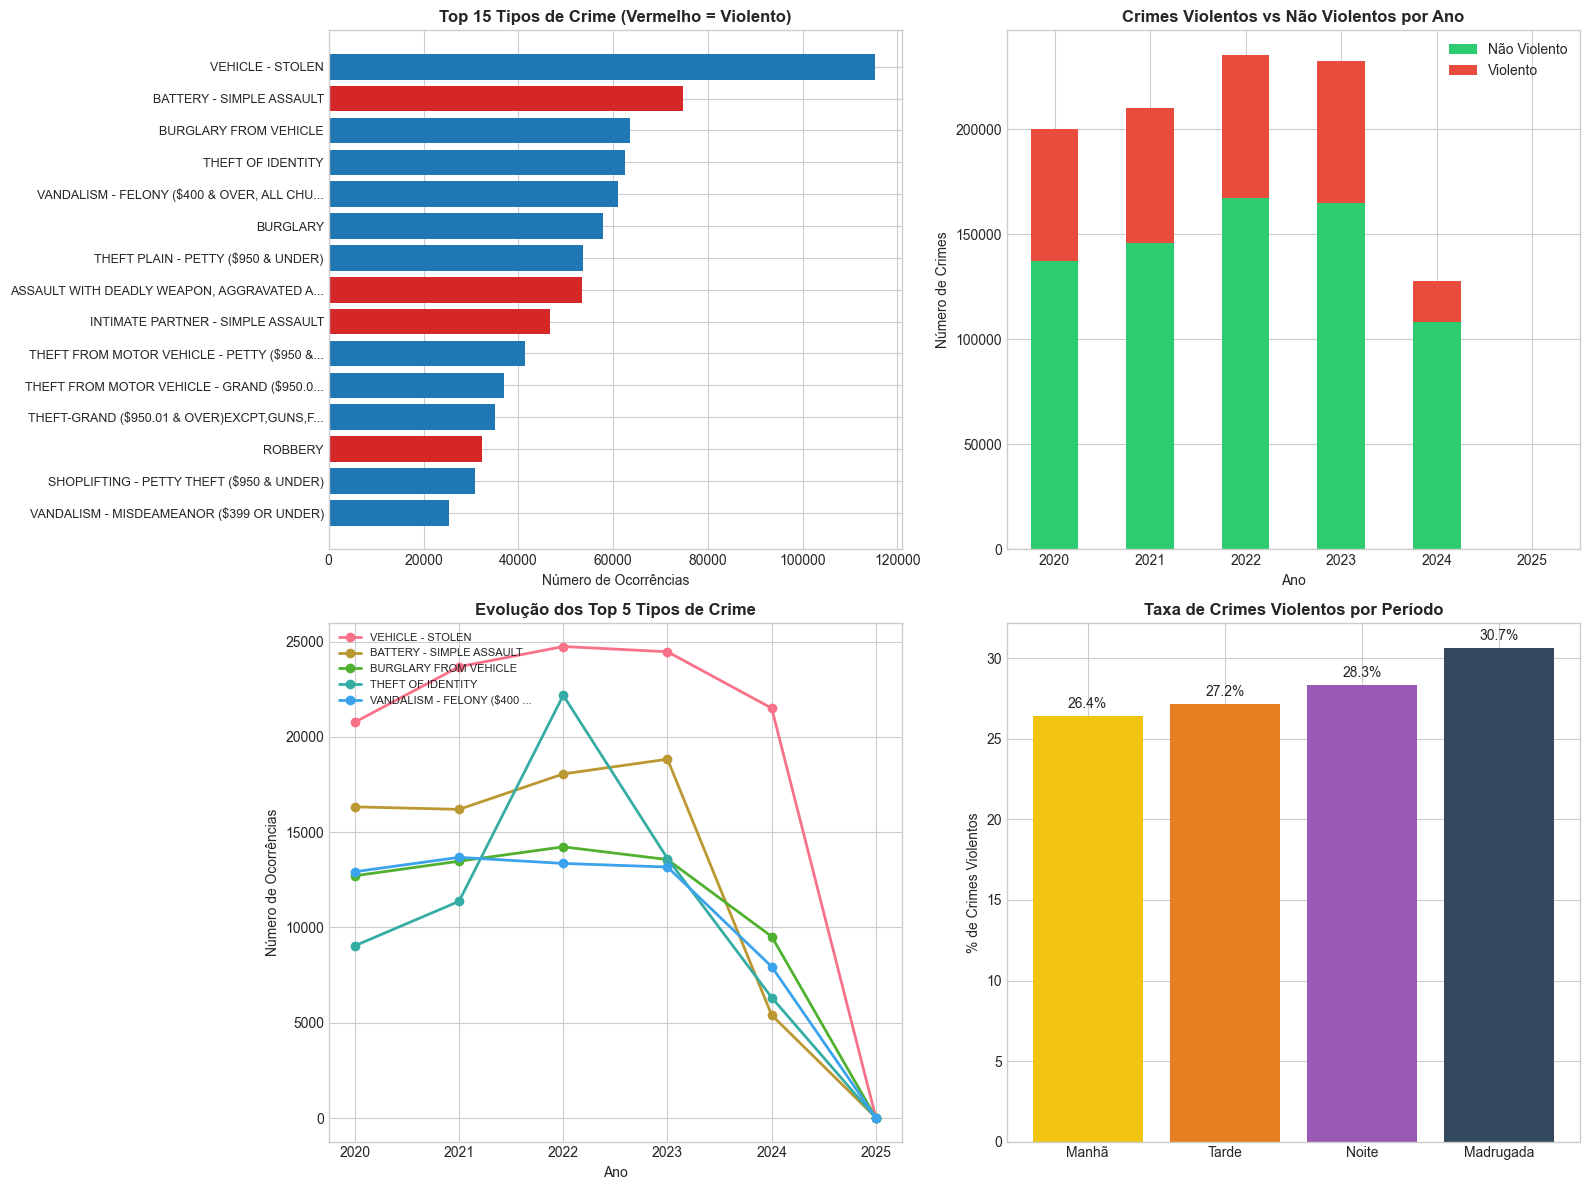


Estatísticas de Crimes Violentos:
   Total violentos: 281,922 (28.1%)
   Total não violentos: 723,069 (71.9%)


In [53]:
# 11.3 Tipos de Crime - Evolução e Violentos vs Não Violentos
print("="*70)
print("ANÁLISE DE TIPOS DE CRIME")
print("="*70)

# Definir crimes violentos (baseado em códigos Part 1)
violent_keywords = ['ASSAULT', 'ROBBERY', 'HOMICIDE', 'RAPE', 'MURDER', 'KIDNAPPING', 
                    'BATTERY', 'WEAPON', 'SHOOTING', 'MANSLAUGHTER']

# Criar coluna de crime violento
crime_col = 'Crm Cd Desc' if 'Crm Cd Desc' in df_full.columns else 'crime_description'
df_full['is_violent'] = df_full[crime_col].fillna('').apply(
    lambda x: any(v in str(x).upper() for v in violent_keywords)
).astype(int)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top 15 tipos de crime
ax1 = axes[0, 0]
top_crimes = df_full[crime_col].value_counts().head(15)
colors = ['#d62728' if any(v in str(c).upper() for v in violent_keywords) else '#1f77b4' 
          for c in top_crimes.index]
bars = ax1.barh(range(len(top_crimes)), top_crimes.values, color=colors)
ax1.set_yticks(range(len(top_crimes)))
ax1.set_yticklabels([c[:40] + '...' if len(c) > 40 else c for c in top_crimes.index], fontsize=9)
ax1.invert_yaxis()
ax1.set_xlabel('Número de Ocorrências')
ax1.set_title('Top 15 Tipos de Crime (Vermelho = Violento)', fontsize=12, fontweight='bold')

# Proporção violentos vs não violentos por ano
ax2 = axes[0, 1]
violent_by_year = df_full.groupby(['year', 'is_violent']).size().unstack(fill_value=0)
violent_by_year.columns = ['Não Violento', 'Violento']
violent_by_year.plot(kind='bar', stacked=True, ax=ax2, color=['#2ecc71', '#e74c3c'])
ax2.set_title('Crimes Violentos vs Não Violentos por Ano', fontsize=12, fontweight='bold')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Crimes')
ax2.tick_params(axis='x', rotation=0)
ax2.legend(loc='upper right')

# Evolução dos top 5 crimes ao longo do tempo
ax3 = axes[1, 0]
top5_crimes = df_full[crime_col].value_counts().head(5).index
for crime in top5_crimes:
    crime_evolution = df_full[df_full[crime_col] == crime].groupby('year').size()
    label = crime[:25] + '...' if len(crime) > 25 else crime
    ax3.plot(crime_evolution.index, crime_evolution.values, marker='o', label=label, linewidth=2)
ax3.set_title('Evolução dos Top 5 Tipos de Crime', fontsize=12, fontweight='bold')
ax3.set_xlabel('Ano')
ax3.set_ylabel('Número de Ocorrências')
ax3.legend(loc='upper left', fontsize=8)

# Taxa de crimes violentos por período do dia
ax4 = axes[1, 1]
violent_by_period = df_full.groupby('period_of_day')['is_violent'].agg(['sum', 'count'])
violent_by_period['rate'] = violent_by_period['sum'] / violent_by_period['count'] * 100
order = ['Manhã', 'Tarde', 'Noite', 'Madrugada']
violent_by_period = violent_by_period.reindex(order)
bars = ax4.bar(violent_by_period.index, violent_by_period['rate'], 
               color=['#f1c40f', '#e67e22', '#9b59b6', '#34495e'])
ax4.set_title('Taxa de Crimes Violentos por Período', fontsize=12, fontweight='bold')
ax4.set_ylabel('% de Crimes Violentos')
for bar, val in zip(bars, violent_by_period['rate']):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.1f}%', 
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Estatísticas
violent_total = df_full['is_violent'].sum()
print(f"\nEstatísticas de Crimes Violentos:")
print(f"   Total violentos: {violent_total:,} ({100*violent_total/len(df_full):.1f}%)")
print(f"   Total não violentos: {len(df_full)-violent_total:,} ({100*(len(df_full)-violent_total)/len(df_full):.1f}%)")

### 11.4 Análise Detalhada de Crimes Graves (Homicídio, Estupro, Sequestro)

In [54]:
# Análise detalhada de crimes graves: Homicídio, Estupro e Sequestro
print("="*70)
print("ANÁLISE DE CRIMES GRAVES")
print("="*70)

# Definir categorias de crimes graves
crime_col = 'Crm Cd Desc' if 'Crm Cd Desc' in df_full.columns else 'crime_description'

# Criar filtros para cada categoria
df_full['crime_category'] = 'Outros'

# Homicídios
homicide_mask = df_full[crime_col].str.contains('HOMICIDE|MANSLAUGHTER', case=False, na=False)
df_full.loc[homicide_mask, 'crime_category'] = 'Homicídio'

# Estupro e Crimes Sexuais Graves
rape_mask = df_full[crime_col].str.contains('RAPE|SEXUAL PENETRATION|SODOMY', case=False, na=False)
df_full.loc[rape_mask, 'crime_category'] = 'Estupro/Crime Sexual Grave'

# Sequestro
kidnap_mask = df_full[crime_col].str.contains('KIDNAP', case=False, na=False)
df_full.loc[kidnap_mask, 'crime_category'] = 'Sequestro'

# Filtrar apenas crimes graves
df_graves = df_full[df_full['crime_category'] != 'Outros'].copy()

print(f"\nRESUMO DE CRIMES GRAVES (2020-2025):")
print("-" * 50)
grave_counts = df_graves['crime_category'].value_counts()
for cat, count in grave_counts.items():
    pct = 100 * count / len(df_full)
    print(f"   {cat}: {count:,} ({pct:.3f}%)")
print(f"\n   TOTAL CRIMES GRAVES: {len(df_graves):,} ({100*len(df_graves)/len(df_full):.2f}%)")

# Detalhamento por tipo específico
print(f"\nDETALHAMENTO POR TIPO DE CRIME:")
print("-" * 50)
for cat in ['Homicídio', 'Estupro/Crime Sexual Grave', 'Sequestro']:
    print(f"\n🔸 {cat.upper()}:")
    subset = df_full[df_full['crime_category'] == cat]
    for crime, count in subset[crime_col].value_counts().items():
        print(f"   - {crime}: {count:,}")

ANÁLISE DE CRIMES GRAVES

RESUMO DE CRIMES GRAVES (2020-2025):
--------------------------------------------------
   Estupro/Crime Sexual Grave: 5,927 (0.590%)
   Homicídio: 1,577 (0.157%)
   Sequestro: 1,044 (0.104%)

   TOTAL CRIMES GRAVES: 8,548 (0.85%)

DETALHAMENTO POR TIPO DE CRIME:
--------------------------------------------------

🔸 HOMICÍDIO:
   - CRIMINAL HOMICIDE: 1,568
   - MANSLAUGHTER, NEGLIGENT: 9

🔸 ESTUPRO/CRIME SEXUAL GRAVE:
   - RAPE, FORCIBLE: 3,756
   - SEXUAL PENETRATION W/FOREIGN OBJECT: 1,321
   - SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH: 531
   - RAPE, ATTEMPTED: 319

🔸 SEQUESTRO:
   - KIDNAPPING: 812
   - KIDNAPPING - GRAND ATTEMPT: 232


EVOLUÇÃO ANUAL DE CRIMES GRAVES


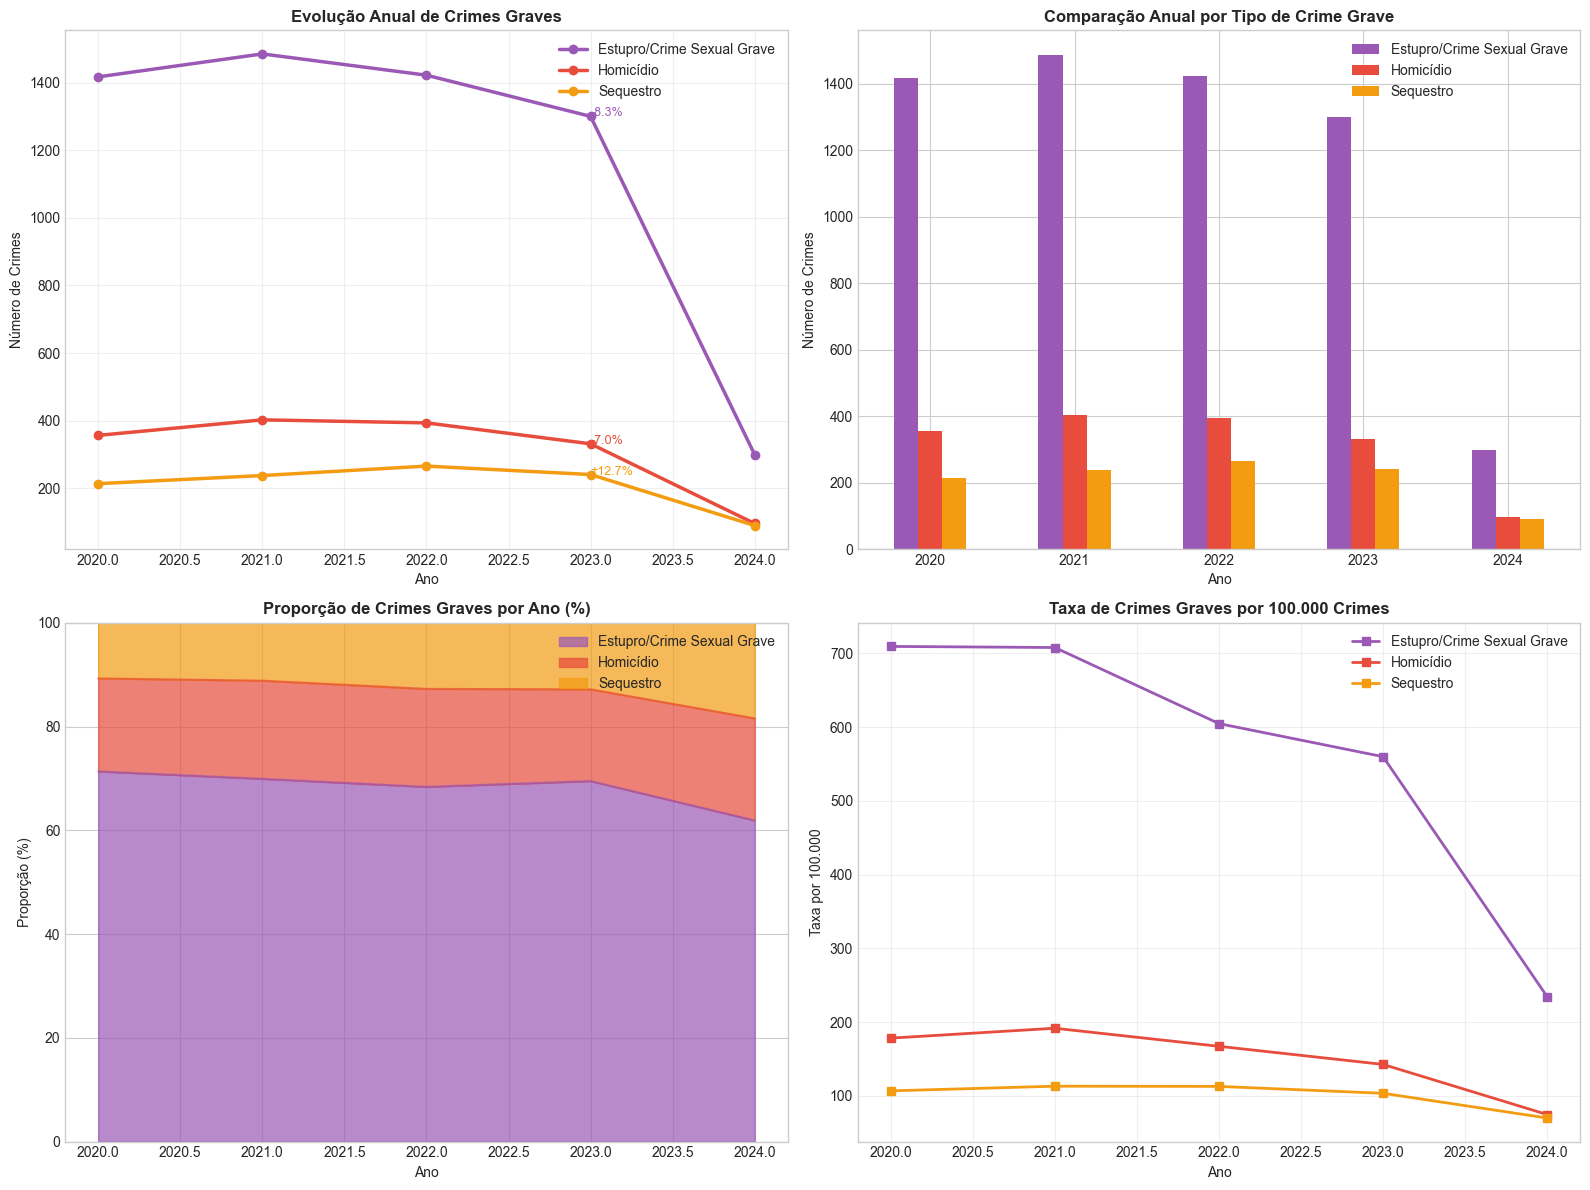


VARIAÇÃO ANUAL:

   Estupro/Crime Sexual Grave:
      2020 → 2021: +4.8%
      2021 → 2022: -4.2%
      2022 → 2023: -8.6%
      2023 → 2024: -77.0%

   Homicídio:
      2020 → 2021: +12.9%
      2021 → 2022: -2.2%
      2022 → 2023: -15.8%
      2023 → 2024: -71.3%

   Sequestro:
      2020 → 2021: +11.3%
      2021 → 2022: +11.8%
      2022 → 2023: -9.4%
      2023 → 2024: -62.9%


In [55]:
# Evolução anual dos crimes graves
print("="*70)
print("EVOLUÇÃO ANUAL DE CRIMES GRAVES")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Evolução anual por categoria
ax1 = axes[0, 0]
grave_by_year = df_graves.groupby(['year', 'crime_category']).size().unstack(fill_value=0)
colors_graves = {'Homicídio': '#e74c3c', 'Estupro/Crime Sexual Grave': '#9b59b6', 'Sequestro': '#f39c12'}
for cat in grave_by_year.columns:
    ax1.plot(grave_by_year.index, grave_by_year[cat], marker='o', linewidth=2.5, 
             label=cat, color=colors_graves.get(cat, '#333'))
ax1.set_title('Evolução Anual de Crimes Graves', fontsize=12, fontweight='bold')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Crimes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Adicionar anotações de variação
for cat in grave_by_year.columns:
    if len(grave_by_year) >= 2:
        first_val = grave_by_year[cat].iloc[0]
        last_complete = grave_by_year[cat].iloc[-2] if len(grave_by_year) > 2 else grave_by_year[cat].iloc[-1]
        if first_val > 0:
            var = ((last_complete - first_val) / first_val) * 100
            ax1.annotate(f'{var:+.1f}%', xy=(grave_by_year.index[-2], last_complete),
                        fontsize=9, color=colors_graves.get(cat, '#333'))

# 2. Comparação ano a ano (barras agrupadas)
ax2 = axes[0, 1]
grave_by_year.plot(kind='bar', ax=ax2, color=[colors_graves.get(c, '#333') for c in grave_by_year.columns])
ax2.set_title('Comparação Anual por Tipo de Crime Grave', fontsize=12, fontweight='bold')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Crimes')
ax2.tick_params(axis='x', rotation=0)
ax2.legend(loc='upper right')

# 3. Proporção de cada crime grave por ano
ax3 = axes[1, 0]
grave_pct = grave_by_year.div(grave_by_year.sum(axis=1), axis=0) * 100
grave_pct.plot(kind='area', stacked=True, ax=ax3, alpha=0.7,
               color=[colors_graves.get(c, '#333') for c in grave_pct.columns])
ax3.set_title('Proporção de Crimes Graves por Ano (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Ano')
ax3.set_ylabel('Proporção (%)')
ax3.legend(loc='upper right')
ax3.set_ylim(0, 100)

# 4. Taxa por 100.000 crimes (normalizado)
ax4 = axes[1, 1]
total_by_year = df_full.groupby('year').size()
rate_per_100k = (grave_by_year.div(total_by_year, axis=0) * 100000).dropna()
rate_per_100k.plot(kind='line', ax=ax4, marker='s', linewidth=2,
                   color=[colors_graves.get(c, '#333') for c in rate_per_100k.columns])
ax4.set_title('Taxa de Crimes Graves por 100.000 Crimes', fontsize=12, fontweight='bold')
ax4.set_xlabel('Ano')
ax4.set_ylabel('Taxa por 100.000')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas de variação
print("\nVARIAÇÃO ANUAL:")
for cat in grave_by_year.columns:
    yearly_vals = grave_by_year[cat]
    if len(yearly_vals) >= 2:
        pct_change = yearly_vals.pct_change().dropna() * 100
        print(f"\n   {cat}:")
        for year, change in pct_change.items():
            print(f"      {int(year-1)} → {int(year)}: {change:+.1f}%")

DISTRIBUIÇÃO GEOGRÁFICA DE CRIMES GRAVES


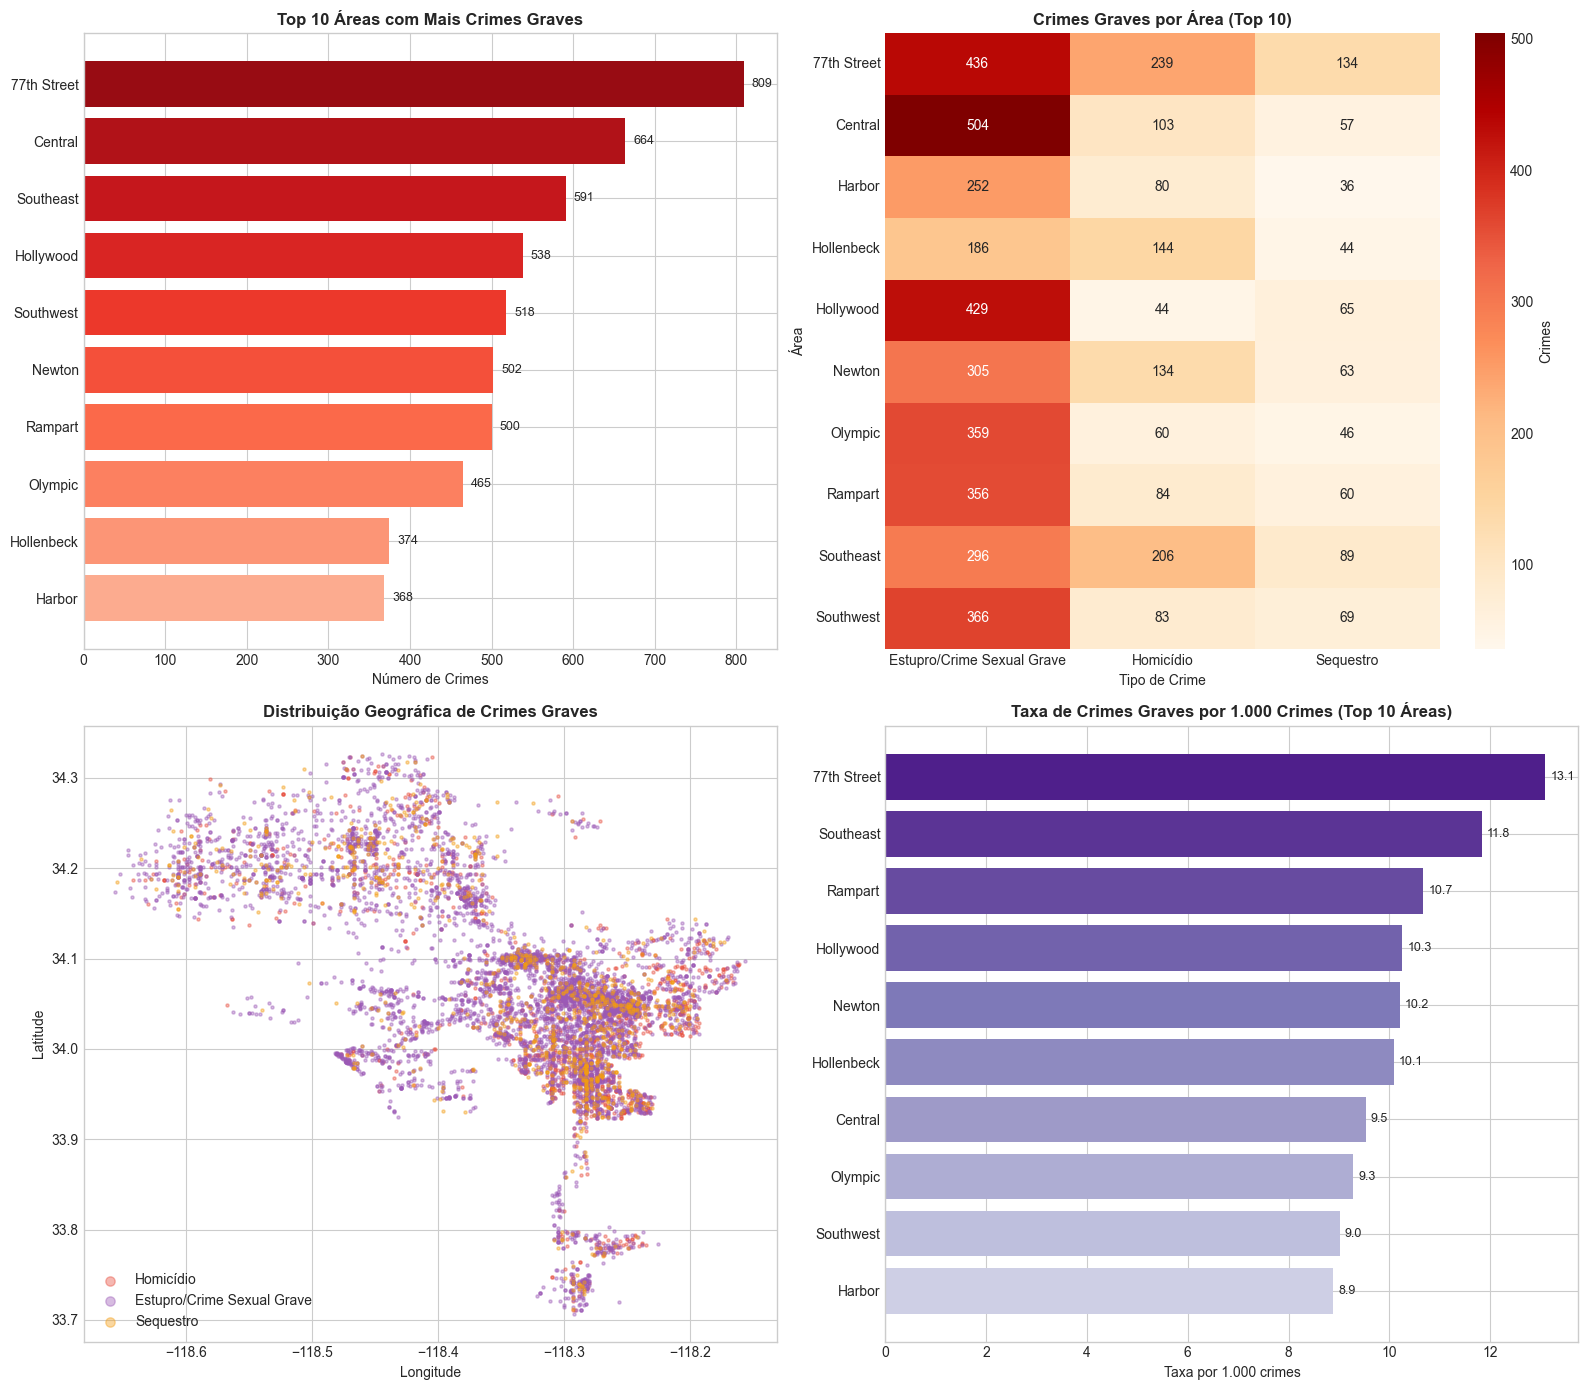


CONCENTRAÇÃO GEOGRÁFICA:
   Top 3 áreas concentram 2,064 crimes (24.1% do total)
      - 77th Street: 809
      - Central: 664
      - Southeast: 591


In [56]:
# Distribuição Geográfica de Crimes Graves
print("="*70)
print("DISTRIBUIÇÃO GEOGRÁFICA DE CRIMES GRAVES")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

area_col = 'AREA NAME' if 'AREA NAME' in df_graves.columns else 'area_name'

# 1. Top 10 áreas por total de crimes graves
ax1 = axes[0, 0]
area_graves = df_graves.groupby(area_col).size().sort_values(ascending=True).tail(10)
colors_area = plt.cm.Reds(np.linspace(0.3, 0.9, len(area_graves)))
bars = ax1.barh(area_graves.index, area_graves.values, color=colors_area)
ax1.set_title('Top 10 Áreas com Mais Crimes Graves', fontsize=12, fontweight='bold')
ax1.set_xlabel('Número de Crimes')
for bar, val in zip(bars, area_graves.values):
    ax1.text(val + 10, bar.get_y() + bar.get_height()/2, f'{val:,}', 
             va='center', fontsize=9)

# 2. Heatmap: Área × Tipo de Crime Grave
ax2 = axes[0, 1]
area_crime = df_graves.groupby([area_col, 'crime_category']).size().unstack(fill_value=0)
top_areas = df_graves[area_col].value_counts().head(10).index
area_crime_top = area_crime.loc[area_crime.index.isin(top_areas)]
sns.heatmap(area_crime_top, annot=True, fmt='d', cmap='OrRd', ax=ax2, cbar_kws={'label': 'Crimes'})
ax2.set_title('Crimes Graves por Área (Top 10)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Tipo de Crime')
ax2.set_ylabel('Área')

# 3. Mapa de calor geográfico (scatter)
ax3 = axes[1, 0]
lat_col = 'LAT' if 'LAT' in df_graves.columns else 'latitude'
lon_col = 'LON' if 'LON' in df_graves.columns else 'longitude'

valid_graves = df_graves[(df_graves[lat_col] != 0) & (df_graves[lon_col] != 0)].copy()

for cat, color in colors_graves.items():
    subset = valid_graves[valid_graves['crime_category'] == cat]
    ax3.scatter(subset[lon_col], subset[lat_col], c=color, alpha=0.4, s=5, label=cat)

ax3.set_title('Distribuição Geográfica de Crimes Graves', fontsize=12, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.legend(markerscale=3)

# 4. Taxa de crimes graves por área (normalizado)
ax4 = axes[1, 1]
total_by_area = df_full.groupby(area_col).size()
graves_by_area = df_graves.groupby(area_col).size()
rate_by_area = (graves_by_area / total_by_area * 1000).sort_values(ascending=True).tail(10)

colors_rate = plt.cm.Purples(np.linspace(0.3, 0.9, len(rate_by_area)))
bars = ax4.barh(rate_by_area.index, rate_by_area.values, color=colors_rate)
ax4.set_title('Taxa de Crimes Graves por 1.000 Crimes (Top 10 Áreas)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Taxa por 1.000 crimes')
for bar, val in zip(bars, rate_by_area.values):
    ax4.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.1f}', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Estatísticas geográficas
print("\nCONCENTRAÇÃO GEOGRÁFICA:")
top3_areas = df_graves[area_col].value_counts().head(3)
total_top3 = top3_areas.sum()
print(f"   Top 3 áreas concentram {total_top3:,} crimes ({100*total_top3/len(df_graves):.1f}% do total)")
for area, count in top3_areas.items():
    print(f"      - {area}: {count:,}")

PERFIL DAS VÍTIMAS DE CRIMES GRAVES


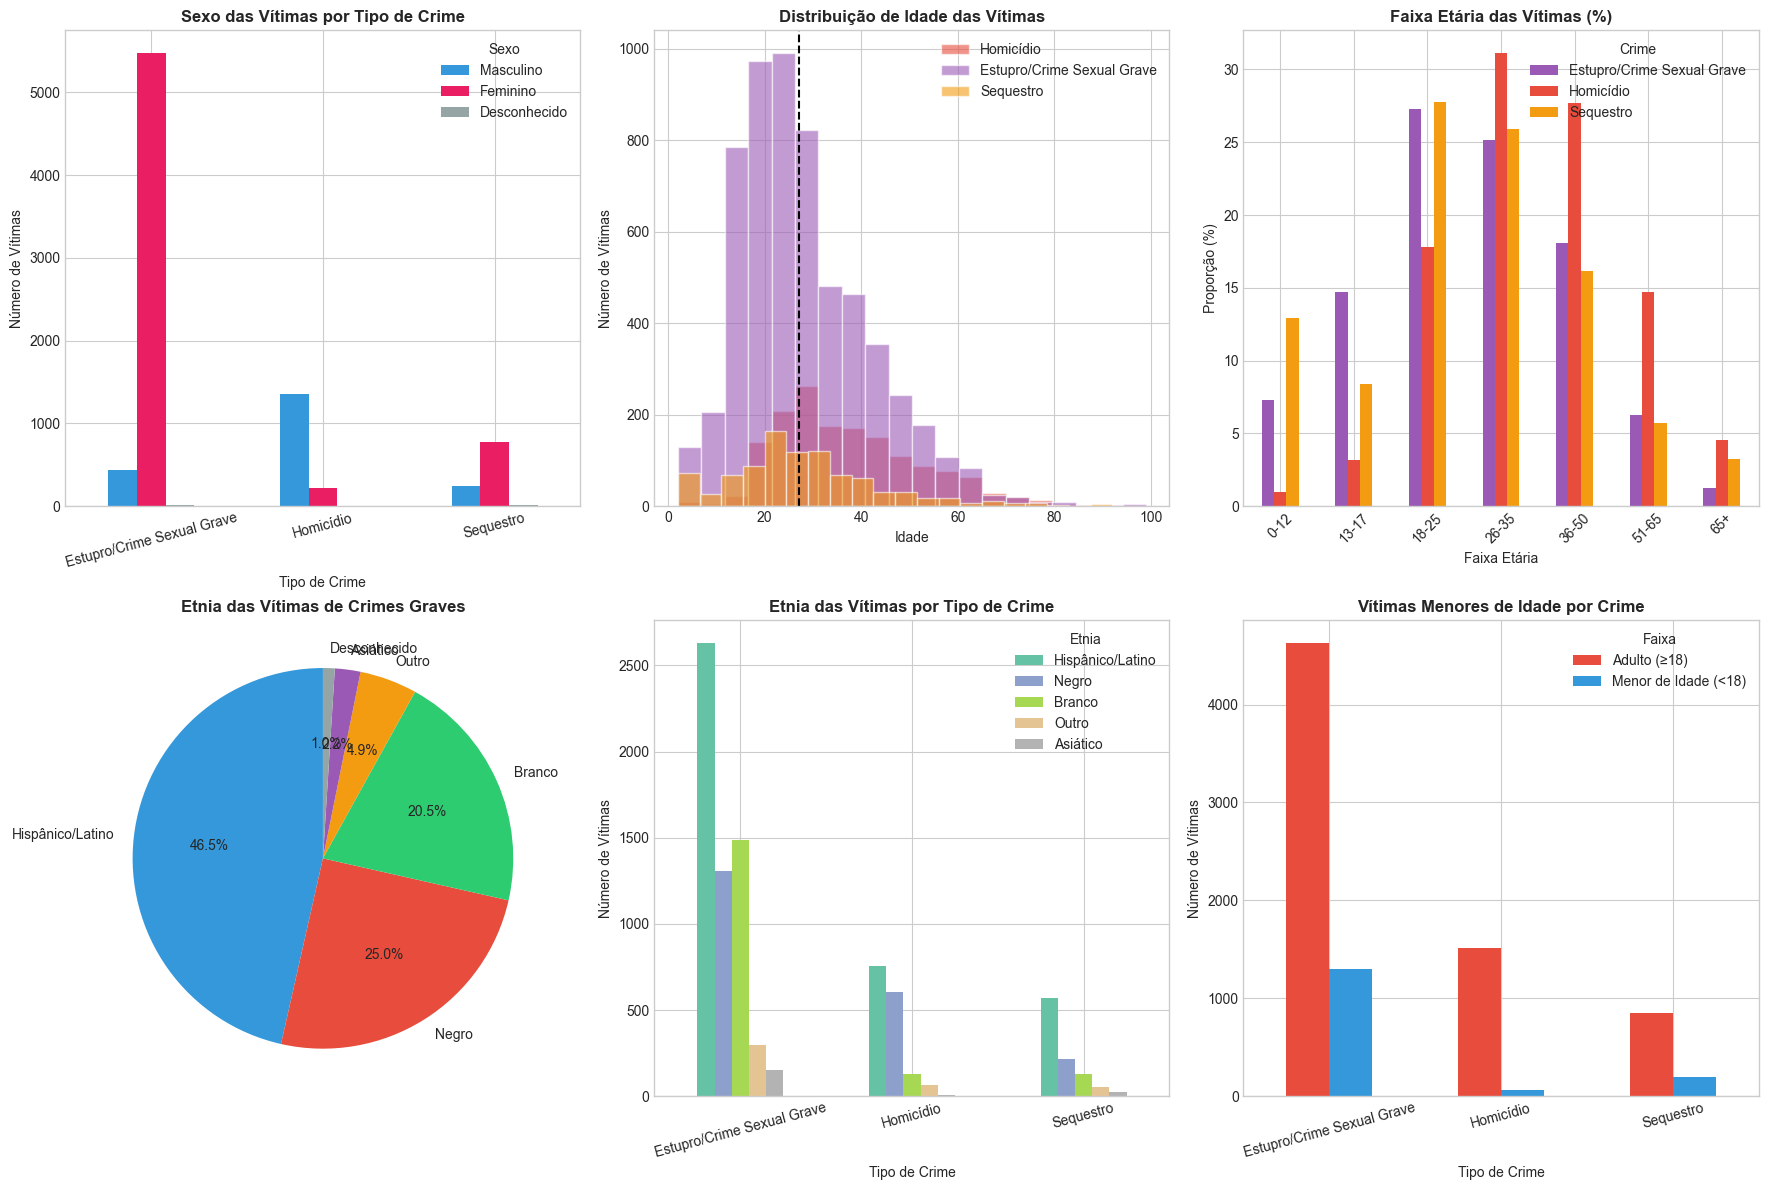


ESTATÍSTICAS DO PERFIL DAS VÍTIMAS:
--------------------------------------------------

🔸 Homicídio:
   Total de vítimas: 1,577
   Sexo: 86.1% Masculino, 13.7% Feminino
   Idade média: 37.4 anos
   Idade mediana: 34 anos
   Menores de idade: 64 (4.1%)
   Etnia mais afetada: Hispânico/Latino (755)

🔸 Estupro/Crime Sexual Grave:
   Total de vítimas: 5,927
   Sexo: 7.4% Masculino, 92.4% Feminino
   Idade média: 28.3 anos
   Idade mediana: 26 anos
   Menores de idade: 1,300 (22.0%)
   Etnia mais afetada: Hispânico/Latino (2,629)

🔸 Sequestro:
   Total de vítimas: 1,044
   Sexo: 23.7% Masculino, 75.0% Feminino
   Idade média: 28.0 anos
   Idade mediana: 26 anos
   Menores de idade: 198 (21.3%)
   Etnia mais afetada: Hispânico/Latino (572)


In [57]:
# Perfil das Vítimas de Crimes Graves
print("="*70)
print("PERFIL DAS VÍTIMAS DE CRIMES GRAVES")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Colunas de vítima
sex_col = 'Vict Sex' if 'Vict Sex' in df_graves.columns else 'victim_sex'
age_col = 'Vict Age' if 'Vict Age' in df_graves.columns else 'victim_age'
descent_col = 'Vict Descent' if 'Vict Descent' in df_graves.columns else 'victim_descent'

# Mapeamento de etnia
descent_labels = {
    'H': 'Hispânico/Latino', 'W': 'Branco', 'B': 'Negro', 'A': 'Asiático',
    'O': 'Outro', 'X': 'Desconhecido', '-': 'Desconhecido', 'K': 'Coreano',
    'F': 'Filipino', 'C': 'Chinês', 'J': 'Japonês', 'V': 'Vietnamita',
    'I': 'Indígena Americano', 'P': 'Ilhas do Pacífico', 'U': 'Havaiano',
    'Z': 'Indiano Asiático', 'S': 'Samoano', 'G': 'Guamense', 'L': 'Laosiano'
}

# 1. Sexo das vítimas por tipo de crime
ax1 = axes[0, 0]
sex_by_crime = df_graves.groupby(['crime_category', sex_col]).size().unstack(fill_value=0)
sex_labels_map = {'M': 'Masculino', 'F': 'Feminino', 'X': 'Desconhecido', 'H': 'Desconhecido'}
sex_by_crime.columns = [sex_labels_map.get(c, c) for c in sex_by_crime.columns]
sex_by_crime = sex_by_crime[[c for c in ['Masculino', 'Feminino', 'Desconhecido'] if c in sex_by_crime.columns]]
sex_by_crime.plot(kind='bar', ax=ax1, color=['#3498db', '#e91e63', '#95a5a6'])
ax1.set_title('Sexo das Vítimas por Tipo de Crime', fontsize=12, fontweight='bold')
ax1.set_xlabel('Tipo de Crime')
ax1.set_ylabel('Número de Vítimas')
ax1.tick_params(axis='x', rotation=15)
ax1.legend(title='Sexo')

# 2. Distribuição de idade das vítimas
ax2 = axes[0, 1]
valid_ages = df_graves[(df_graves[age_col] > 0) & (df_graves[age_col] < 100)]
for cat, color in colors_graves.items():
    subset = valid_ages[valid_ages['crime_category'] == cat][age_col]
    ax2.hist(subset, bins=20, alpha=0.6, label=cat, color=color, edgecolor='white')
ax2.set_title('Distribuição de Idade das Vítimas', fontsize=12, fontweight='bold')
ax2.set_xlabel('Idade')
ax2.set_ylabel('Número de Vítimas')
ax2.legend()
ax2.axvline(valid_ages[age_col].median(), color='black', linestyle='--', label=f'Mediana: {valid_ages[age_col].median():.0f}')

# 3. Faixa etária por tipo de crime
ax3 = axes[0, 2]
df_graves['age_group'] = pd.cut(df_graves[age_col], 
                                 bins=[0, 12, 17, 25, 35, 50, 65, 100],
                                 labels=['0-12', '13-17', '18-25', '26-35', '36-50', '51-65', '65+'])
age_crime = df_graves.groupby(['crime_category', 'age_group']).size().unstack(fill_value=0)
age_crime_pct = age_crime.div(age_crime.sum(axis=1), axis=0) * 100
age_crime_pct.T.plot(kind='bar', ax=ax3, color=[colors_graves.get(c, '#333') for c in age_crime_pct.index])
ax3.set_title('Faixa Etária das Vítimas (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Faixa Etária')
ax3.set_ylabel('Proporção (%)')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='Crime', loc='upper right')

# 4. Etnia das vítimas
ax4 = axes[1, 0]
df_graves['descent_label'] = df_graves[descent_col].map(descent_labels).fillna('Outro')
descent_counts = df_graves['descent_label'].value_counts().head(6)
colors_pie = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#95a5a6']
ax4.pie(descent_counts.values, labels=descent_counts.index, autopct='%1.1f%%', 
        colors=colors_pie, startangle=90)
ax4.set_title('Etnia das Vítimas de Crimes Graves', fontsize=12, fontweight='bold')

# 5. Etnia × Tipo de crime
ax5 = axes[1, 1]
descent_crime = df_graves.groupby(['crime_category', 'descent_label']).size().unstack(fill_value=0)
top_descents = df_graves['descent_label'].value_counts().head(5).index
descent_crime_top = descent_crime[top_descents]
descent_crime_top.plot(kind='bar', ax=ax5, colormap='Set2')
ax5.set_title('Etnia das Vítimas por Tipo de Crime', fontsize=12, fontweight='bold')
ax5.set_xlabel('Tipo de Crime')
ax5.set_ylabel('Número de Vítimas')
ax5.tick_params(axis='x', rotation=15)
ax5.legend(title='Etnia', loc='upper right')

# 6. Menores de idade vítimas
ax6 = axes[1, 2]
df_graves['is_minor'] = df_graves[age_col].apply(lambda x: 'Menor de Idade (<18)' if 0 < x < 18 else 'Adulto (≥18)')
minor_by_crime = df_graves.groupby(['crime_category', 'is_minor']).size().unstack(fill_value=0)
minor_by_crime.plot(kind='bar', ax=ax6, color=['#e74c3c', '#3498db'])
ax6.set_title('Vítimas Menores de Idade por Crime', fontsize=12, fontweight='bold')
ax6.set_xlabel('Tipo de Crime')
ax6.set_ylabel('Número de Vítimas')
ax6.tick_params(axis='x', rotation=15)
ax6.legend(title='Faixa')

plt.tight_layout()
plt.show()

# Estatísticas do perfil
print("\nESTATÍSTICAS DO PERFIL DAS VÍTIMAS:")
print("-" * 50)

# Por tipo de crime
for cat in ['Homicídio', 'Estupro/Crime Sexual Grave', 'Sequestro']:
    subset = df_graves[df_graves['crime_category'] == cat]
    valid = subset[(subset[age_col] > 0) & (subset[age_col] < 100)]
    
    print(f"\n🔸 {cat}:")
    print(f"   Total de vítimas: {len(subset):,}")
    
    # Sexo
    sex_dist = subset[sex_col].value_counts(normalize=True) * 100
    sex_m = sex_dist.get('M', 0)
    sex_f = sex_dist.get('F', 0)
    print(f"   Sexo: {sex_m:.1f}% Masculino, {sex_f:.1f}% Feminino")
    
    # Idade
    if len(valid) > 0:
        print(f"   Idade média: {valid[age_col].mean():.1f} anos")
        print(f"   Idade mediana: {valid[age_col].median():.0f} anos")
        minors = len(valid[(valid[age_col] > 0) & (valid[age_col] < 18)])
        print(f"   Menores de idade: {minors:,} ({100*minors/len(valid):.1f}%)")
    
    # Etnia mais afetada
    top_descent = subset['descent_label'].value_counts().head(1)
    if len(top_descent) > 0:
        print(f"   Etnia mais afetada: {top_descent.index[0]} ({top_descent.values[0]:,})")

---
# 🗺️ ANÁLISE ESPACIAL (GEOANÁLISE)

Identificação de hotspots de criminalidade, distribuição geográfica e análise por distrito/área.

ANÁLISE ESPACIAL - HOTSPOTS DE CRIMINALIDADE
📍 Registros com coordenadas válidas: 1,002,751 (99.8%)


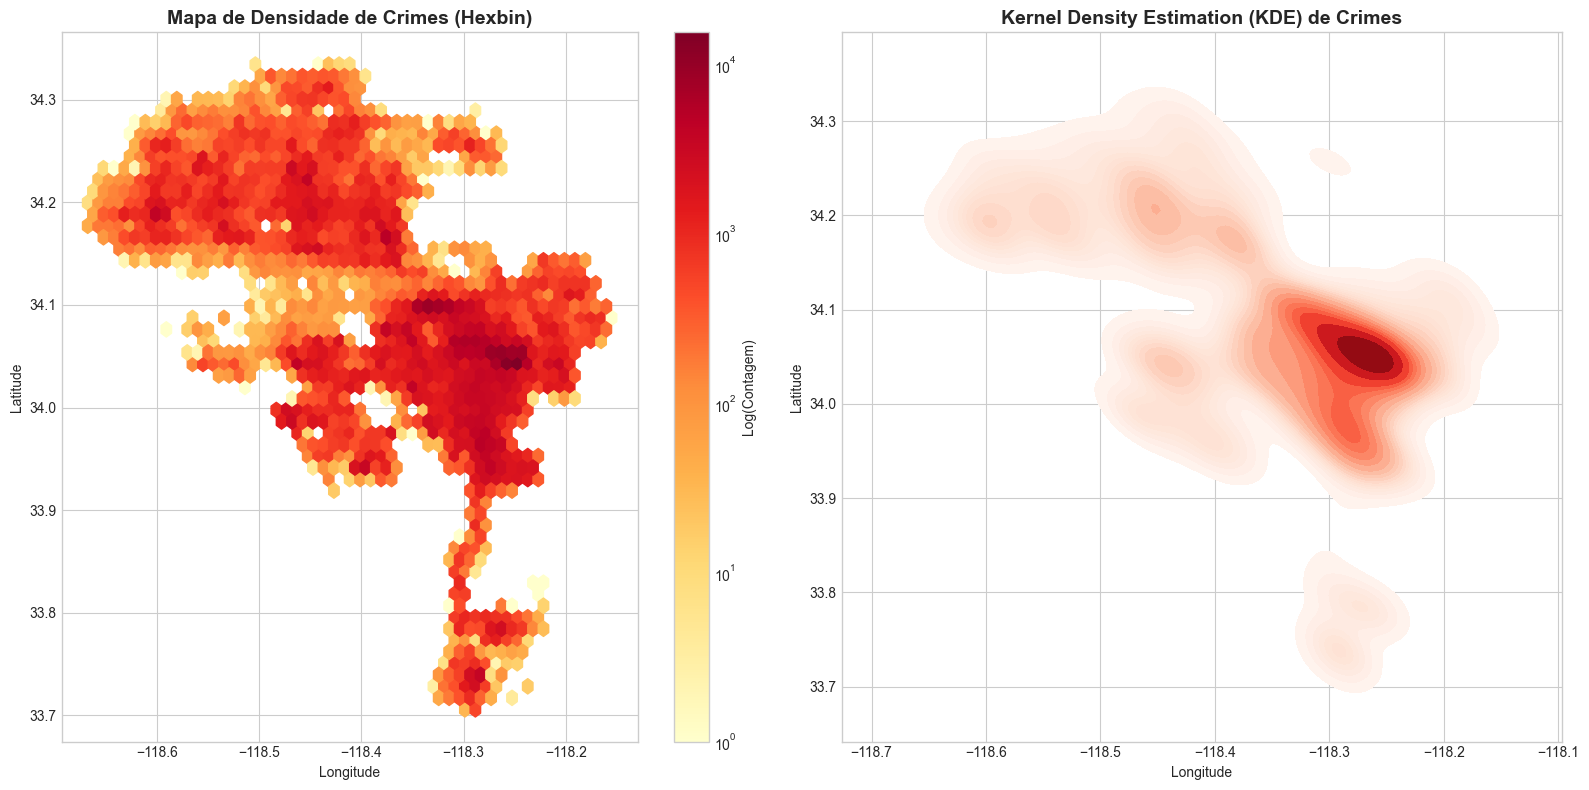


Identificando Hotspots com DBSCAN...
   Hotspots identificados: 5
   Pontos em hotspots: 49,097 (98.2%)


In [58]:
# 12.1 Mapa de Calor 2D - Hotspots de Criminalidade
print("="*70)
print("ANÁLISE ESPACIAL - HOTSPOTS DE CRIMINALIDADE")
print("="*70)

# Filtrar coordenadas válidas
lat_col = 'LAT' if 'LAT' in df_full.columns else 'latitude'
lon_col = 'LON' if 'LON' in df_full.columns else 'longitude'
df_geo = df_full[(df_full[lat_col] != 0) & (df_full[lon_col] != 0) & 
                  df_full[lat_col].notna() & df_full[lon_col].notna()].copy()

print(f"📍 Registros com coordenadas válidas: {len(df_geo):,} ({100*len(df_geo)/len(df_full):.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Mapa de densidade 2D (hexbin)
ax1 = axes[0]
hb = ax1.hexbin(df_geo[lon_col], df_geo[lat_col], gridsize=50, cmap='YlOrRd', 
                mincnt=1, bins='log')
cb = plt.colorbar(hb, ax=ax1)
cb.set_label('Log(Contagem)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Mapa de Densidade de Crimes (Hexbin)', fontsize=14, fontweight='bold')

# KDE 2D
ax2 = axes[1]
# Usar amostra para KDE (computacionalmente intensivo)
sample_size = min(20000, len(df_geo))
df_sample = df_geo.sample(sample_size, random_state=42)
sns.kdeplot(data=df_sample, x=lon_col, y=lat_col, cmap='Reds', 
            fill=True, levels=20, thresh=0.05, ax=ax2)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Kernel Density Estimation (KDE) de Crimes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Identificar hotspots usando clustering
from sklearn.cluster import DBSCAN

print("\nIdentificando Hotspots com DBSCAN...")
coords = df_geo[[lat_col, lon_col]].sample(min(50000, len(df_geo)), random_state=42).values

# DBSCAN para encontrar clusters de alta densidade
db = DBSCAN(eps=0.01, min_samples=50)
clusters = db.fit_predict(coords)

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"   Hotspots identificados: {n_clusters}")
print(f"   Pontos em hotspots: {(clusters != -1).sum():,} ({100*(clusters != -1).sum()/len(clusters):.1f}%)")

COMPARAÇÃO ESPACIAL POR ANO


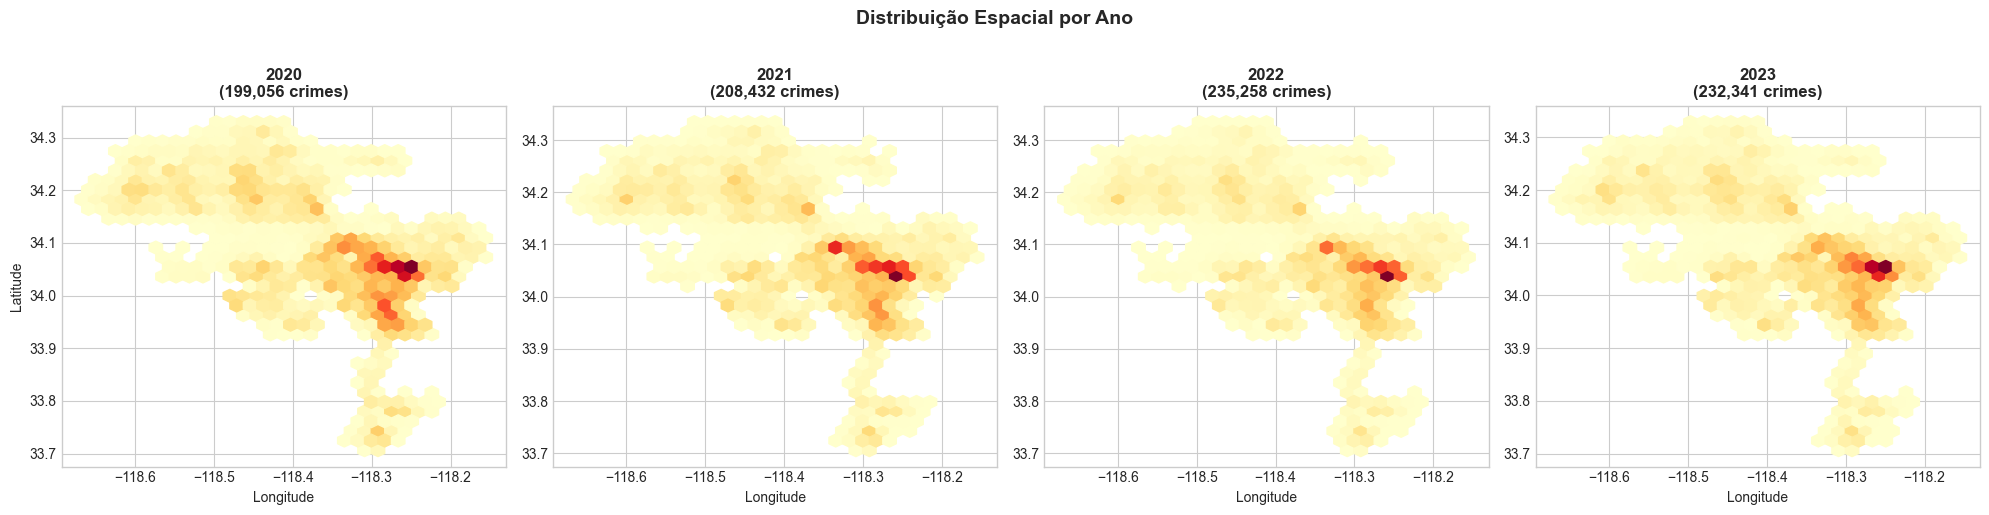


📍 Criminalidade por Área/Distrito:


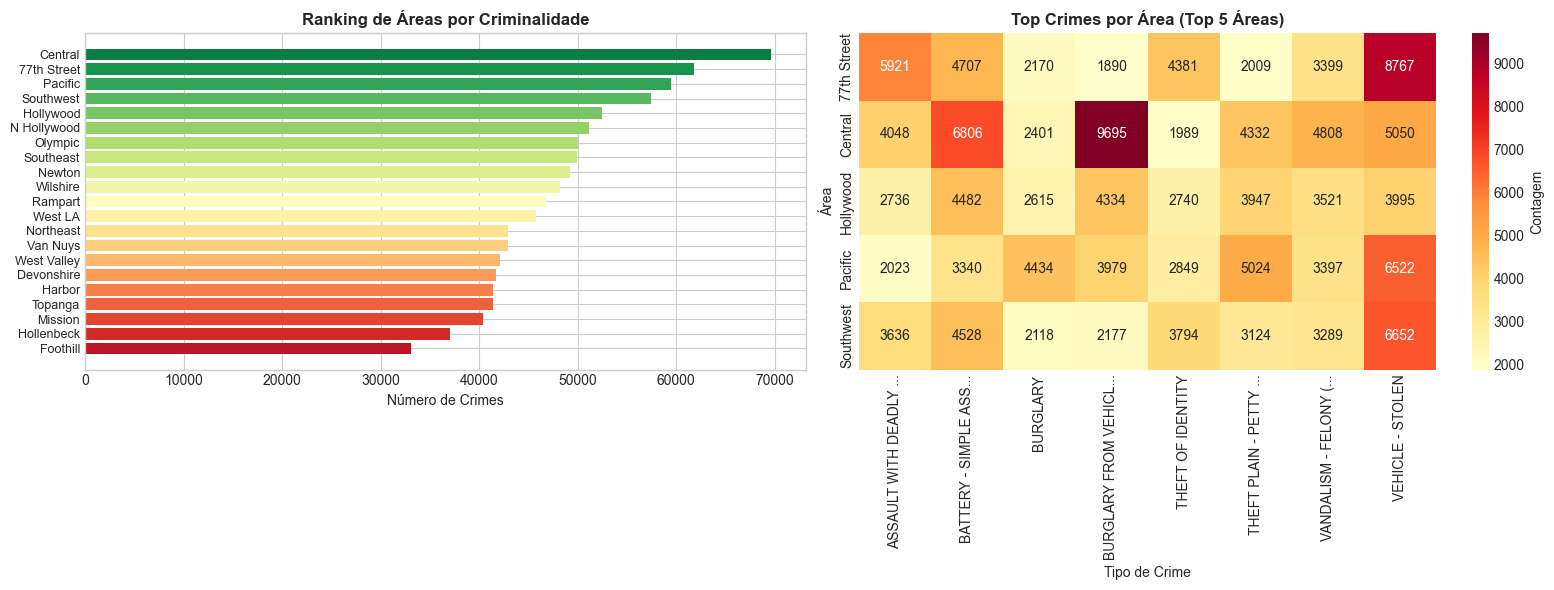

In [59]:
# 12.2 Comparação Espacial por Ano
print("="*70)
print("COMPARAÇÃO ESPACIAL POR ANO")
print("="*70)

years = sorted(df_geo['year'].dropna().unique().astype(int))
n_years = min(4, len(years))  # Máximo 4 subplots

if n_years > 1:
    fig, axes = plt.subplots(1, n_years, figsize=(5*n_years, 5))
    
    for idx, year in enumerate(years[:n_years]):
        ax = axes[idx] if n_years > 1 else axes
        df_year = df_geo[df_geo['year'] == year]
        
        hb = ax.hexbin(df_year[lon_col], df_year[lat_col], gridsize=30, 
                       cmap='YlOrRd', mincnt=1)
        ax.set_title(f'{year}\n({len(df_year):,} crimes)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Longitude')
        if idx == 0:
            ax.set_ylabel('Latitude')
    
    plt.suptitle('Distribuição Espacial por Ano', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Apenas um ano disponível para comparação")

# Análise por área/distrito
area_col = 'AREA NAME' if 'AREA NAME' in df_full.columns else 'area_name'
if area_col in df_full.columns:
    print("\n📍 Criminalidade por Área/Distrito:")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Ranking por área
    ax1 = axes[0]
    area_counts = df_full[area_col].value_counts()
    colors = sns.color_palette('RdYlGn_r', len(area_counts))
    bars = ax1.barh(range(len(area_counts)), area_counts.values, color=colors)
    ax1.set_yticks(range(len(area_counts)))
    ax1.set_yticklabels(area_counts.index, fontsize=9)
    ax1.invert_yaxis()
    ax1.set_xlabel('Número de Crimes')
    ax1.set_title('Ranking de Áreas por Criminalidade', fontsize=12, fontweight='bold')
    
    # Tipo predominante por área (top 5 áreas)
    ax2 = axes[1]
    top5_areas = area_counts.head(5).index
    area_crime_type = df_full[df_full[area_col].isin(top5_areas)].groupby(
        [area_col, crime_col]).size().reset_index(name='count')
    
    # Pivot para heatmap
    top3_crimes = df_full[crime_col].value_counts().head(8).index
    pivot = area_crime_type[area_crime_type[crime_col].isin(top3_crimes)].pivot_table(
        index=area_col, columns=crime_col, values='count', fill_value=0)
    pivot.columns = [c[:20] + '...' if len(c) > 20 else c for c in pivot.columns]
    
    sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.0f', ax=ax2, cbar_kws={'label': 'Contagem'})
    ax2.set_title('Top Crimes por Área (Top 5 Áreas)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Tipo de Crime')
    ax2.set_ylabel('Área')
    
    plt.tight_layout()
    plt.show()

VISUALIZAÇÃO 3D DE HOTSPOTS


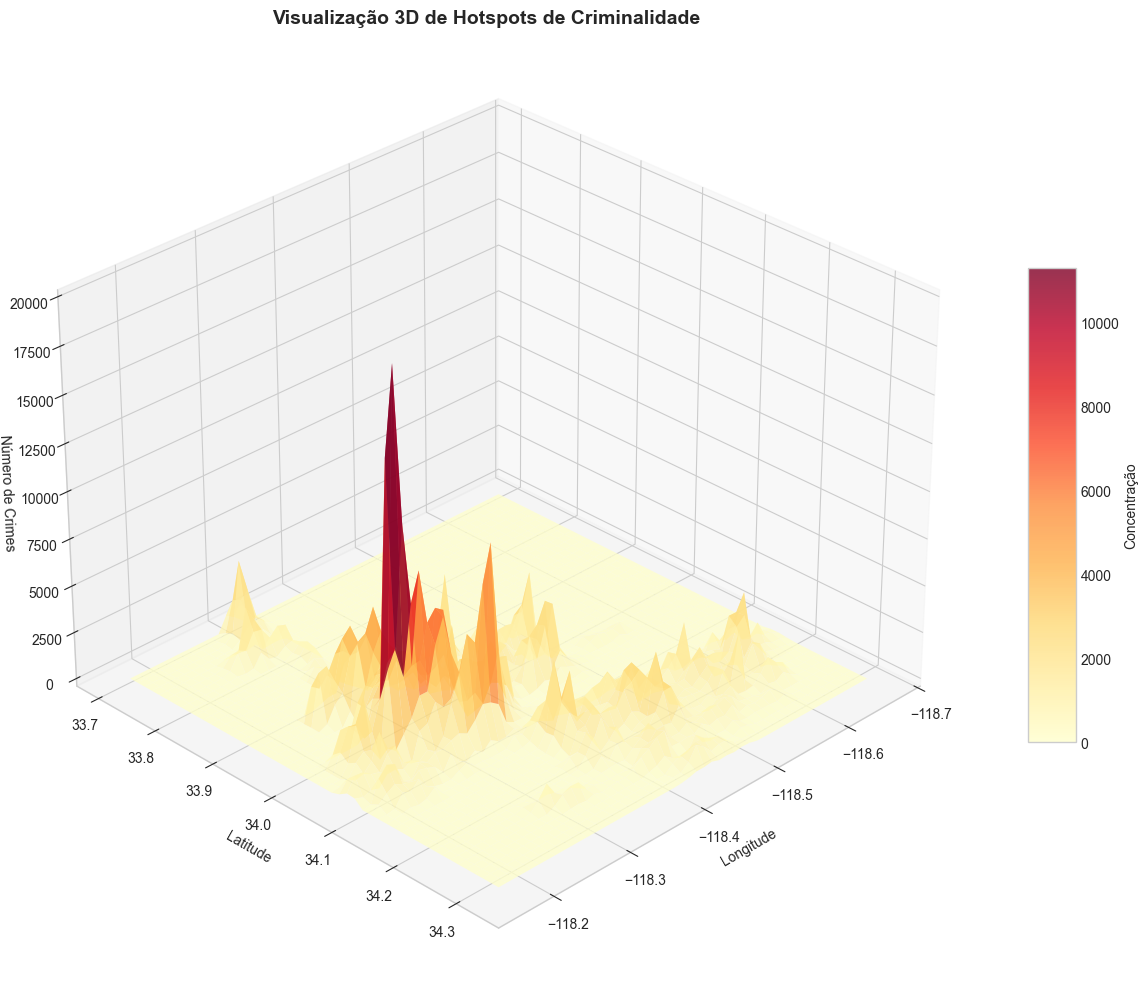


Pico de Criminalidade:
   Localização: Lon=-118.2599, Lat=34.0393
   Concentração: 19930 crimes


In [60]:
# 12.3 Visualização 3D de Hotspots
print("="*70)
print("VISUALIZAÇÃO 3D DE HOTSPOTS")
print("="*70)

from mpl_toolkits.mplot3d import Axes3D

# Criar grid para density
x_bins = np.linspace(df_geo[lon_col].min(), df_geo[lon_col].max(), 50)
y_bins = np.linspace(df_geo[lat_col].min(), df_geo[lat_col].max(), 50)

# Histograma 2D para obter intensidade
H, xedges, yedges = np.histogram2d(df_geo[lon_col], df_geo[lat_col], bins=[x_bins, y_bins])

# Criar meshgrid
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotar superfície 3D
surf = ax.plot_surface(X, Y, H.T, cmap='YlOrRd', edgecolor='none', alpha=0.8)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Número de Crimes')
ax.set_title('Visualização 3D de Hotspots de Criminalidade', fontsize=14, fontweight='bold')

# Adicionar colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Concentração')

# Ajustar ângulo de visualização
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Mostrar os picos
peak_idx = np.unravel_index(H.argmax(), H.shape)
print(f"\nPico de Criminalidade:")
print(f"   Localização: Lon={xedges[peak_idx[0]]:.4f}, Lat={yedges[peak_idx[1]]:.4f}")
print(f"   Concentração: {H.max():.0f} crimes")

---
# 📊 ANÁLISES COMPARATIVAS E CONTEXTUAIS

Impacto da pandemia COVID-19, comparação de períodos e mudanças no local do crime.

ANÁLISE DO IMPACTO DA PANDEMIA COVID-19

Crimes por Período:
   1. Pré-Pandemia (Jan-Mar 2020): 52,048
   2. Lockdown (Abr-Jun 2020): 49,996
   3. Pós-Lockdown 2020 (Jul-Dez): 97,803
   4. Recuperação 2021: 209,876
   5. Pós-Pandemia 2022: 235,259
   6. 2023: 232,345
   6. 2024: 127,567
   6. 2025: 97


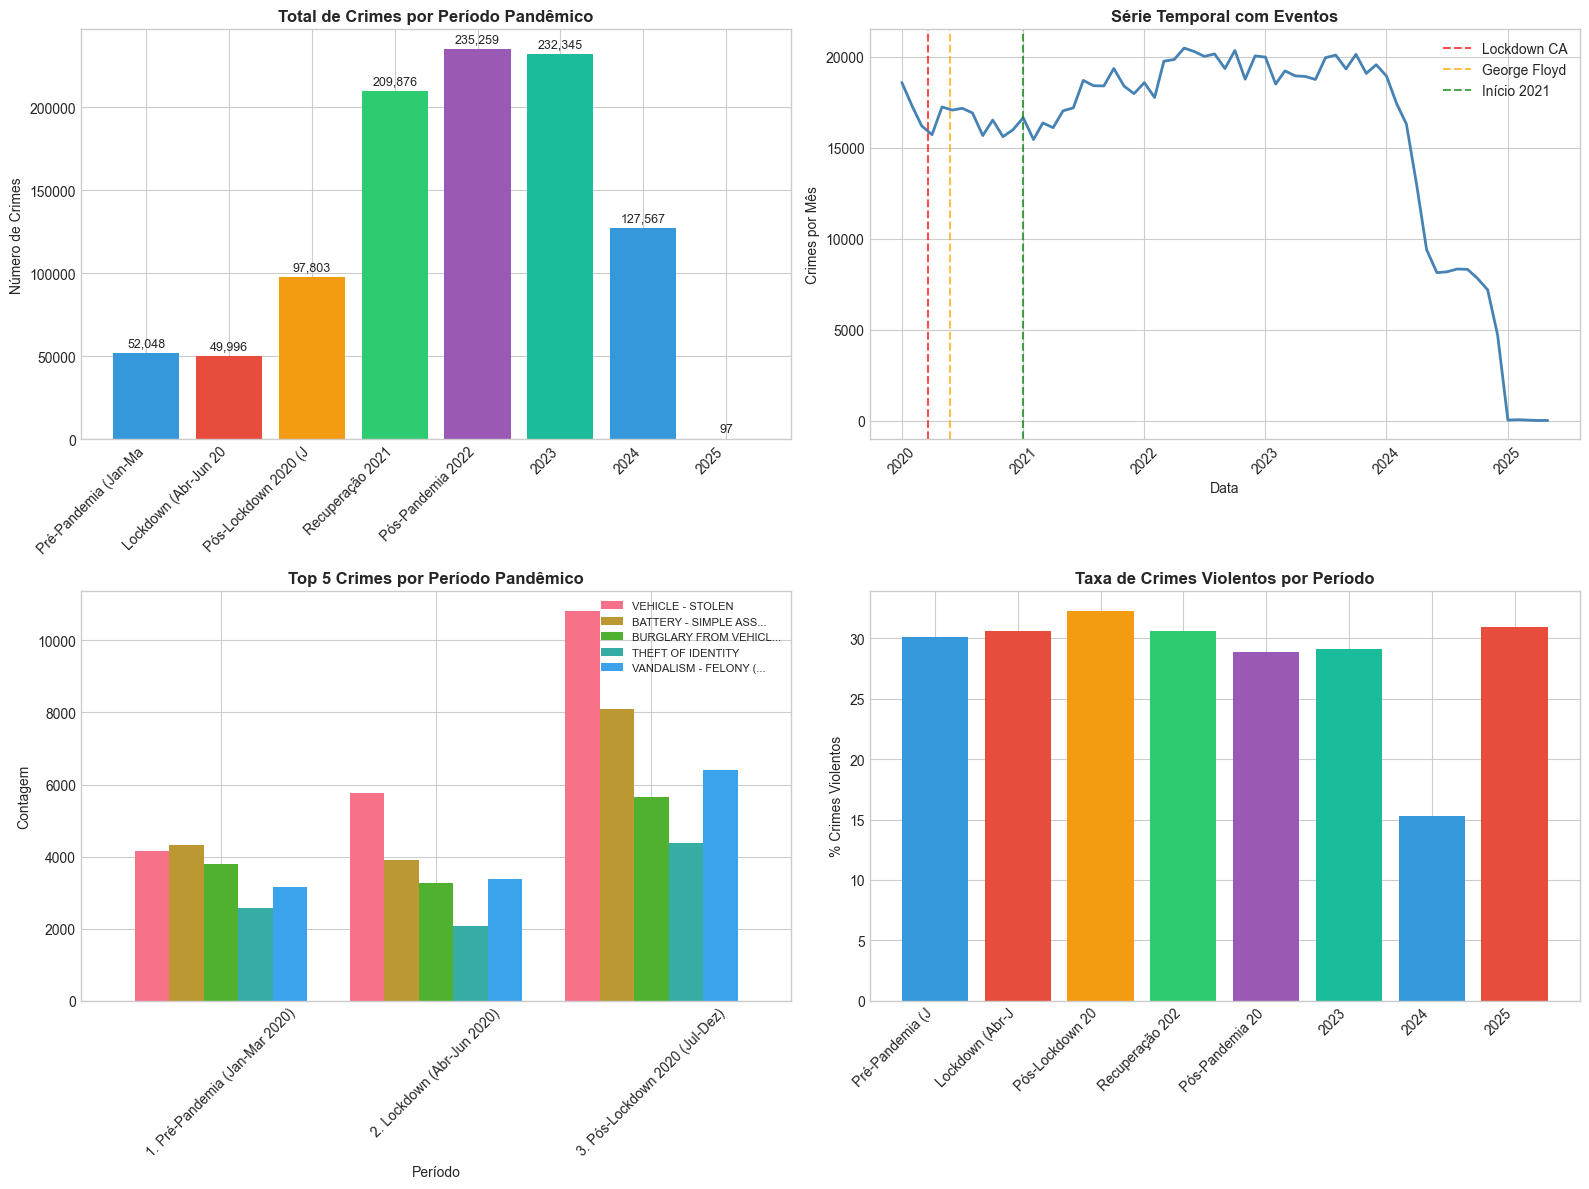

In [61]:
# 13.1 Impacto da Pandemia COVID-19
print("="*70)
print("ANÁLISE DO IMPACTO DA PANDEMIA COVID-19")
print("="*70)

# Definir períodos da pandemia
# Pré-pandemia: Jan 2020 - Mar 2020
# Lockdown: Abr 2020 - Jun 2020
# Pós-lockdown inicial: Jul 2020 - Dez 2020
# Recuperação: 2021+

def classify_pandemic_period(row):
    year = row['year']
    month = row['month']
    
    if pd.isna(year) or pd.isna(month):
        return 'Desconhecido'
    
    year, month = int(year), int(month)
    
    if year < 2020:
        return 'Pré-2020'
    elif year == 2020 and month <= 3:
        return '1. Pré-Pandemia (Jan-Mar 2020)'
    elif year == 2020 and month <= 6:
        return '2. Lockdown (Abr-Jun 2020)'
    elif year == 2020 and month <= 12:
        return '3. Pós-Lockdown 2020 (Jul-Dez)'
    elif year == 2021:
        return '4. Recuperação 2021'
    elif year == 2022:
        return '5. Pós-Pandemia 2022'
    else:
        return f'6. {int(year)}'

df_full['pandemic_period'] = df_full.apply(classify_pandemic_period, axis=1)

# Crimes por período
period_counts = df_full['pandemic_period'].value_counts().sort_index()
print("\nCrimes por Período:")
for period, count in period_counts.items():
    print(f"   {period}: {count:,}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico de barras por período
ax1 = axes[0, 0]
colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71', '#9b59b6', '#1abc9c']
bars = ax1.bar(range(len(period_counts)), period_counts.values, color=colors[:len(period_counts)])
ax1.set_xticks(range(len(period_counts)))
ax1.set_xticklabels([p.split('.')[-1].strip()[:20] for p in period_counts.index], rotation=45, ha='right')
ax1.set_ylabel('Número de Crimes')
ax1.set_title('Total de Crimes por Período Pandêmico', fontsize=12, fontweight='bold')
for bar, val in zip(bars, period_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + max(period_counts)*0.01, 
             f'{val:,}', ha='center', va='bottom', fontsize=9)

# Série temporal com marcação de eventos
ax2 = axes[0, 1]
monthly_ts = df_full.groupby(df_full['DATE OCC'].dt.to_period('M')).size()
monthly_ts.index = monthly_ts.index.to_timestamp()
ax2.plot(monthly_ts.index, monthly_ts.values, linewidth=2, color='steelblue')

# Marcar eventos importantes
events = [
    ('2020-03-19', 'Lockdown CA', 'red'),
    ('2020-05-25', 'George Floyd', 'orange'),
    ('2021-01-01', 'Início 2021', 'green'),
]
for date, label, color in events:
    try:
        event_date = pd.to_datetime(date)
        if event_date >= monthly_ts.index.min() and event_date <= monthly_ts.index.max():
            ax2.axvline(event_date, color=color, linestyle='--', alpha=0.7, label=label)
    except:
        pass

ax2.set_title('Série Temporal com Eventos', fontsize=12, fontweight='bold')
ax2.set_xlabel('Data')
ax2.set_ylabel('Crimes por Mês')
ax2.legend(loc='upper right')
ax2.tick_params(axis='x', rotation=45)

# Variação por tipo de crime entre períodos
ax3 = axes[1, 0]
main_periods = ['1. Pré-Pandemia (Jan-Mar 2020)', '2. Lockdown (Abr-Jun 2020)', 
                '3. Pós-Lockdown 2020 (Jul-Dez)']
existing_periods = [p for p in main_periods if p in df_full['pandemic_period'].values]

if len(existing_periods) >= 2:
    top5_crimes = df_full[crime_col].value_counts().head(5).index
    period_crime = df_full[df_full['pandemic_period'].isin(existing_periods)].groupby(
        ['pandemic_period', crime_col]).size().unstack(fill_value=0)
    period_crime = period_crime[top5_crimes]
    period_crime.columns = [c[:20] + '...' if len(c) > 20 else c for c in period_crime.columns]
    period_crime.plot(kind='bar', ax=ax3, width=0.8)
    ax3.set_title('Top 5 Crimes por Período Pandêmico', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Período')
    ax3.set_ylabel('Contagem')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.tick_params(axis='x', rotation=45)

# Taxa de crimes violentos por período
ax4 = axes[1, 1]
violent_by_period = df_full.groupby('pandemic_period')['is_violent'].agg(['sum', 'count'])
violent_by_period['rate'] = violent_by_period['sum'] / violent_by_period['count'] * 100
violent_by_period = violent_by_period.sort_index()
ax4.bar(range(len(violent_by_period)), violent_by_period['rate'], color=colors[:len(violent_by_period)])
ax4.set_xticks(range(len(violent_by_period)))
ax4.set_xticklabels([p.split('.')[-1].strip()[:15] for p in violent_by_period.index], rotation=45, ha='right')
ax4.set_ylabel('% Crimes Violentos')
ax4.set_title('Taxa de Crimes Violentos por Período', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

🏠 ANÁLISE DE LOCAL DO CRIME (PREMISE)


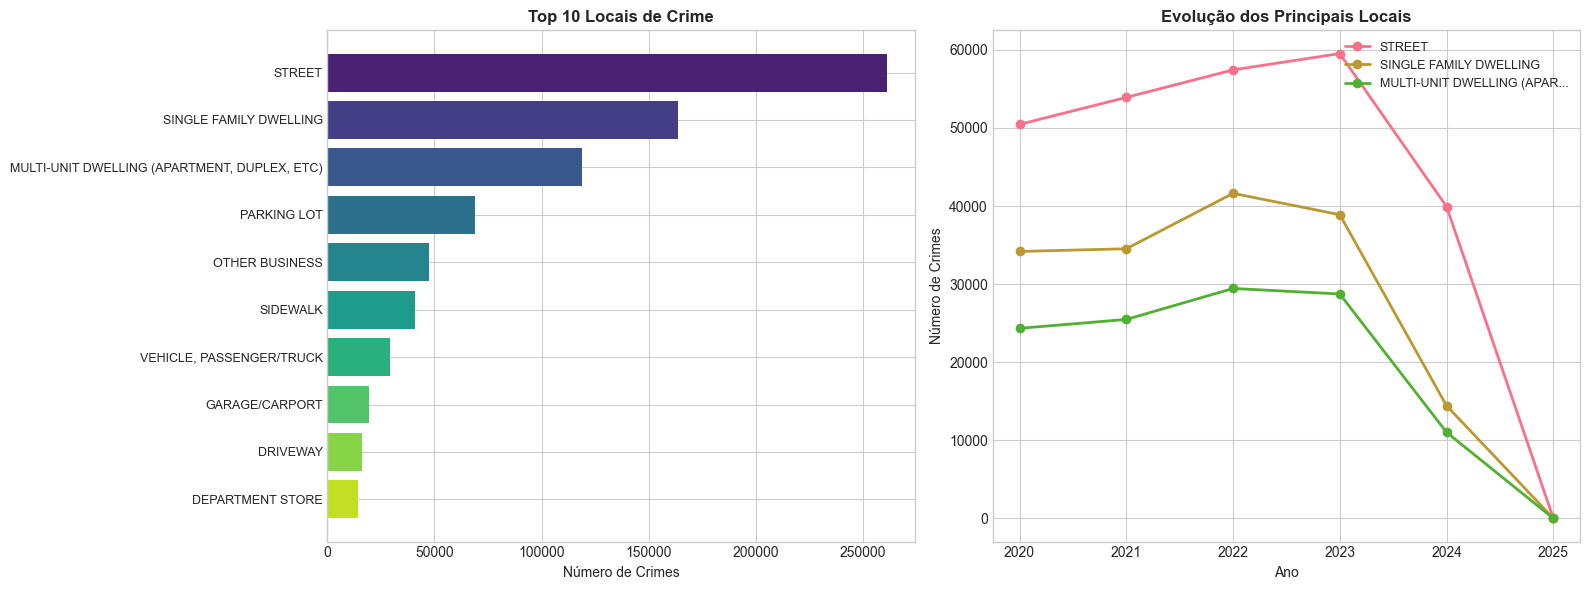


🏢 Categorias de Local:
   Via Pública: 387,325 (38.5%)
   Residência: 299,463 (29.8%)
   Outros: 130,767 (13.0%)
   Estabelecimento Comercial: 120,793 (12.0%)
   Veículo: 56,375 (5.6%)
   Instituição de Ensino: 9,680 (1.0%)
   Desconhecido: 588 (0.1%)


In [62]:
# 13.2 Mudanças no Local do Crime
print("="*70)
print("🏠 ANÁLISE DE LOCAL DO CRIME (PREMISE)")
print("="*70)

premise_col = 'Premis Desc' if 'Premis Desc' in df_full.columns else 'premise_description'

if premise_col in df_full.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top 10 locais
    ax1 = axes[0]
    top_premises = df_full[premise_col].value_counts().head(10)
    ax1.barh(range(len(top_premises)), top_premises.values, color=sns.color_palette('viridis', 10))
    ax1.set_yticks(range(len(top_premises)))
    ax1.set_yticklabels(top_premises.index, fontsize=9)
    ax1.invert_yaxis()
    ax1.set_xlabel('Número de Crimes')
    ax1.set_title('Top 10 Locais de Crime', fontsize=12, fontweight='bold')
    
    # Evolução dos principais locais ao longo do tempo
    ax2 = axes[1]
    top3_premises = top_premises.head(3).index
    for premise in top3_premises:
        premise_evolution = df_full[df_full[premise_col] == premise].groupby('year').size()
        label = premise[:25] + '...' if len(premise) > 25 else premise
        ax2.plot(premise_evolution.index, premise_evolution.values, marker='o', 
                 label=label, linewidth=2)
    ax2.set_title('Evolução dos Principais Locais', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Ano')
    ax2.set_ylabel('Número de Crimes')
    ax2.legend(loc='upper right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Análise de categorias de local
    print("\n🏢 Categorias de Local:")
    
    # Categorizar locais
    def categorize_premise(premise):
        if pd.isna(premise):
            return 'Desconhecido'
        premise = str(premise).upper()
        if any(x in premise for x in ['STREET', 'SIDEWALK', 'PARKING', 'ALLEY']):
            return 'Via Pública'
        elif any(x in premise for x in ['RESIDENCE', 'APARTMENT', 'HOUSE', 'DWELLING']):
            return 'Residência'
        elif any(x in premise for x in ['STORE', 'SHOP', 'RESTAURANT', 'MARKET', 'BUSINESS']):
            return 'Estabelecimento Comercial'
        elif any(x in premise for x in ['VEHICLE', 'CAR', 'TRUCK', 'BUS']):
            return 'Veículo'
        elif any(x in premise for x in ['SCHOOL', 'COLLEGE', 'UNIVERSITY']):
            return 'Instituição de Ensino'
        else:
            return 'Outros'
    
    df_full['premise_category'] = df_full[premise_col].apply(categorize_premise)
    
    category_counts = df_full['premise_category'].value_counts()
    for cat, count in category_counts.items():
        print(f"   {cat}: {count:,} ({100*count/len(df_full):.1f}%)")
else:
    print("⚠️ Coluna de local (premise) não encontrada")

---
# 🔬 ANÁLISES MULTIVARIADAS

Correlações entre variáveis, reincidência espacial e análises cruzadas.

🔬 ANÁLISES MULTIVARIADAS


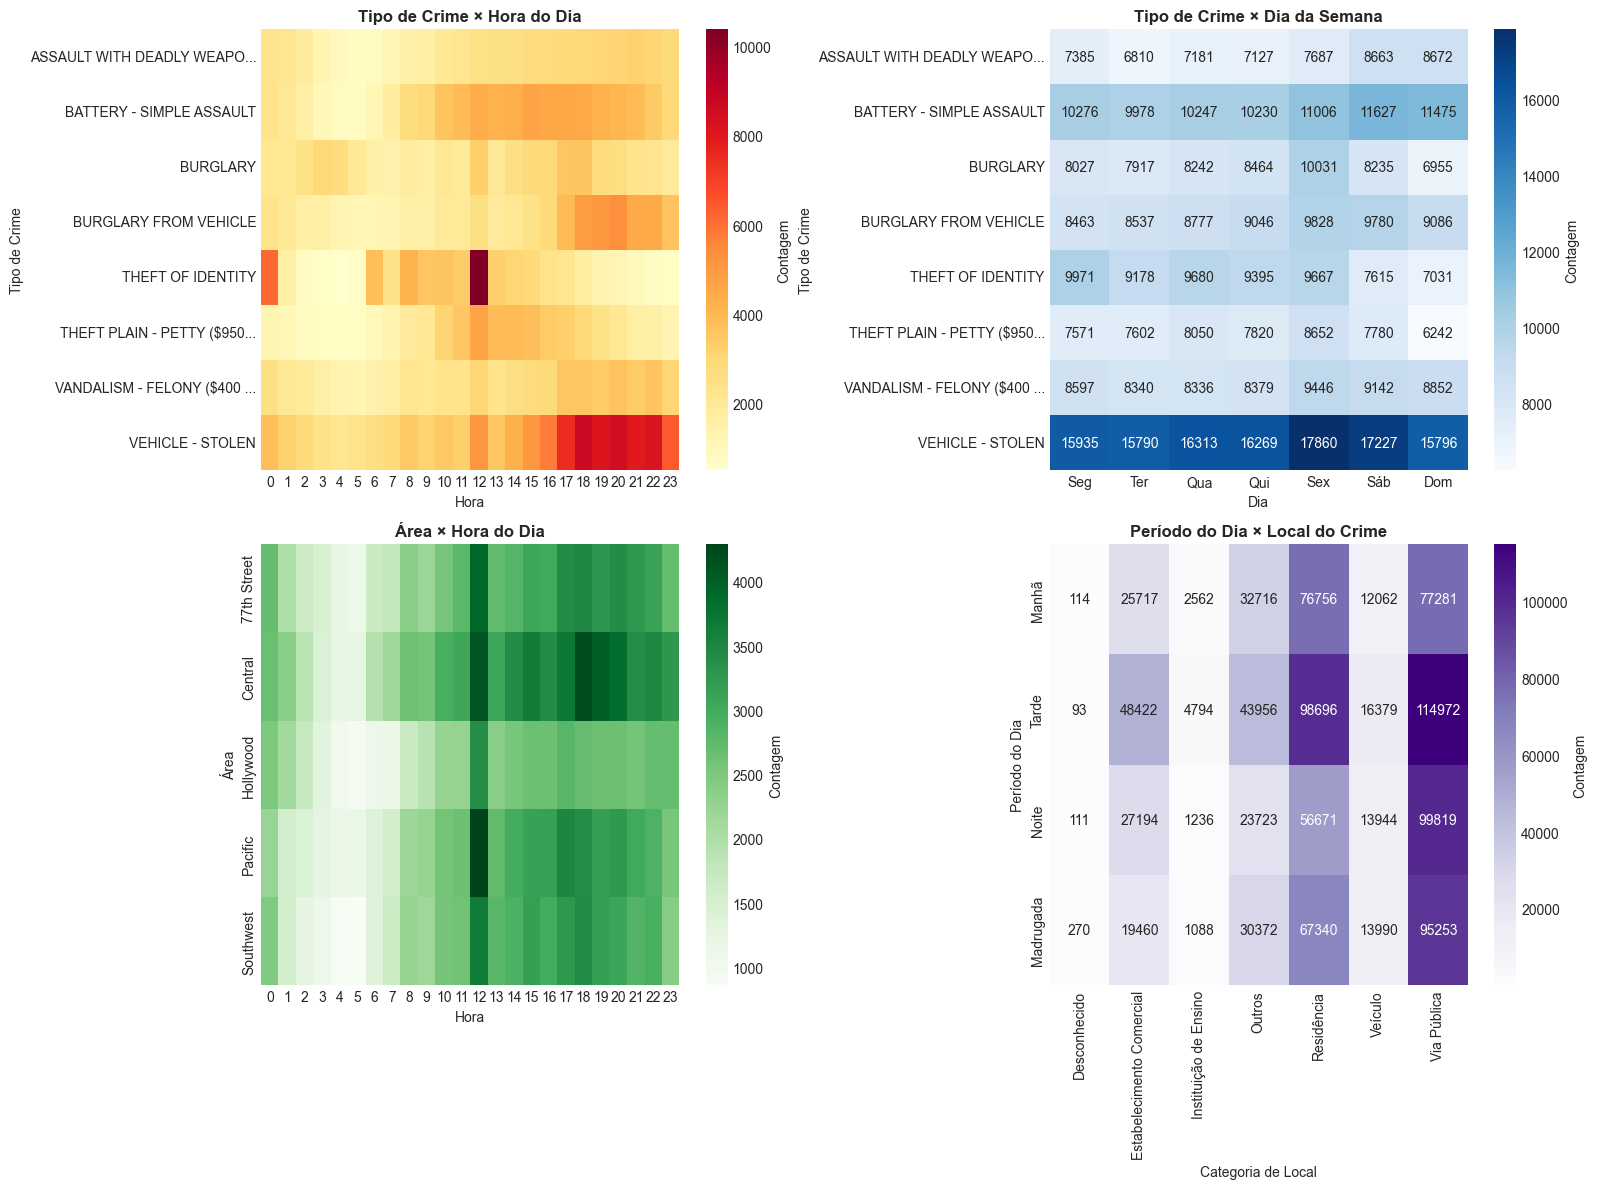

In [63]:
# 14.1 Análise de Correlações Multivariadas
print("="*70)
print("🔬 ANÁLISES MULTIVARIADAS")
print("="*70)

# Criar tabela cruzada: Tipo de Crime x Período do Dia x Dia da Semana
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap: Tipo de Crime x Hora
ax1 = axes[0, 0]
top8_crimes = df_full[crime_col].value_counts().head(8).index
crime_hour = df_full[df_full[crime_col].isin(top8_crimes)].groupby(
    [crime_col, 'hour']).size().unstack(fill_value=0)
crime_hour.index = [c[:25] + '...' if len(c) > 25 else c for c in crime_hour.index]
sns.heatmap(crime_hour, cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Contagem'})
ax1.set_title('Tipo de Crime × Hora do Dia', fontsize=12, fontweight='bold')
ax1.set_xlabel('Hora')
ax1.set_ylabel('Tipo de Crime')

# Heatmap: Tipo de Crime x Dia da Semana
ax2 = axes[0, 1]
crime_dow = df_full[df_full[crime_col].isin(top8_crimes)].groupby(
    [crime_col, 'day_of_week']).size().unstack(fill_value=0)
crime_dow.columns = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
crime_dow.index = [c[:25] + '...' if len(c) > 25 else c for c in crime_dow.index]
sns.heatmap(crime_dow, cmap='Blues', ax=ax2, cbar_kws={'label': 'Contagem'}, annot=True, fmt='d')
ax2.set_title('Tipo de Crime × Dia da Semana', fontsize=12, fontweight='bold')
ax2.set_xlabel('Dia')
ax2.set_ylabel('Tipo de Crime')

# Heatmap: Área x Hora
ax3 = axes[1, 0]
if area_col in df_full.columns:
    top5_areas = df_full[area_col].value_counts().head(5).index
    area_hour = df_full[df_full[area_col].isin(top5_areas)].groupby(
        [area_col, 'hour']).size().unstack(fill_value=0)
    sns.heatmap(area_hour, cmap='Greens', ax=ax3, cbar_kws={'label': 'Contagem'})
    ax3.set_title('Área × Hora do Dia', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Hora')
    ax3.set_ylabel('Área')

# Heatmap: Período do Dia x Categoria de Local
ax4 = axes[1, 1]
if 'premise_category' in df_full.columns and 'period_of_day' in df_full.columns:
    period_premise = df_full.groupby(['period_of_day', 'premise_category']).size().unstack(fill_value=0)
    period_order = ['Manhã', 'Tarde', 'Noite', 'Madrugada']
    period_premise = period_premise.reindex(period_order)
    sns.heatmap(period_premise, cmap='Purples', ax=ax4, annot=True, fmt='d', 
                cbar_kws={'label': 'Contagem'})
    ax4.set_title('Período do Dia × Local do Crime', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Categoria de Local')
    ax4.set_ylabel('Período do Dia')

plt.tight_layout()
plt.show()

🔄 ANÁLISE DE REINCIDÊNCIA ESPACIAL

📍 Estatísticas de Localização:
   Localizações únicas: 77,868
   Média de crimes por local: 12.88
   Máximo de crimes em um local: 2,397

🔁 Distribuição de Reincidência:
   Baixa (2-5): 27,245 locais (35.0%)
   Único: 17,502 locais (22.5%)
   Alta (11-50): 16,677 locais (21.4%)
   Média (6-10): 12,670 locais (16.3%)
   Muito Alta (50+): 3,774 locais (4.8%)


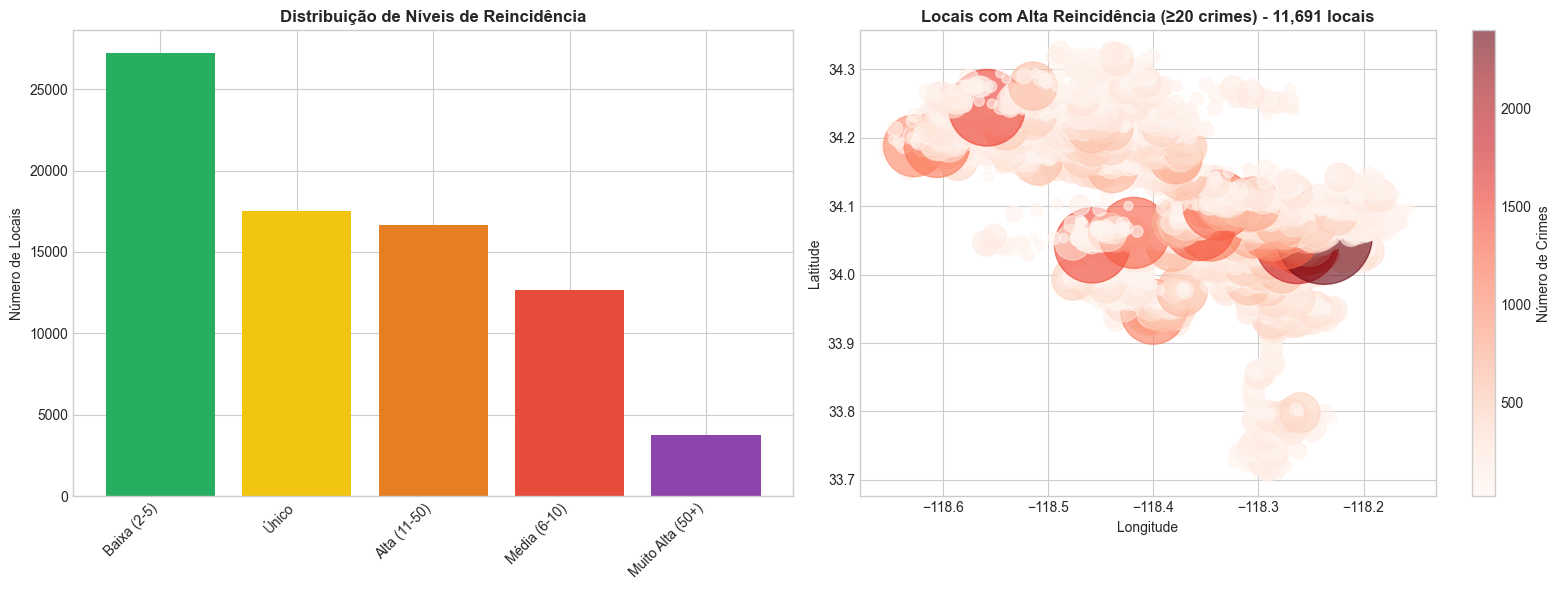


📊 Concentração vs Dispersão:
   Crimes em hotspots (≥10 por local): 819,937 (81.8%)
   Crimes em locais únicos: 17,502


In [64]:
# 14.2 Análise de Reincidência Espacial
print("="*70)
print("🔄 ANÁLISE DE REINCIDÊNCIA ESPACIAL")
print("="*70)

# Identificar locais com crimes repetidos (usando lat/lon arredondado)
df_geo['lat_round'] = df_geo[lat_col].round(4)
df_geo['lon_round'] = df_geo[lon_col].round(4)

# Contar crimes por localização única
location_counts = df_geo.groupby(['lat_round', 'lon_round']).size().reset_index(name='crime_count')

print(f"\n📍 Estatísticas de Localização:")
print(f"   Localizações únicas: {len(location_counts):,}")
print(f"   Média de crimes por local: {location_counts['crime_count'].mean():.2f}")
print(f"   Máximo de crimes em um local: {location_counts['crime_count'].max():,}")

# Classificar por reincidência
location_counts['reincidence_level'] = pd.cut(
    location_counts['crime_count'],
    bins=[0, 1, 5, 10, 50, float('inf')],
    labels=['Único', 'Baixa (2-5)', 'Média (6-10)', 'Alta (11-50)', 'Muito Alta (50+)']
)

reincidence_dist = location_counts['reincidence_level'].value_counts()
print("\n🔁 Distribuição de Reincidência:")
for level, count in reincidence_dist.items():
    pct = 100 * count / len(location_counts)
    print(f"   {level}: {count:,} locais ({pct:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribuição de reincidência
ax1 = axes[0]
colors_reinc = ['#27ae60', '#f1c40f', '#e67e22', '#e74c3c', '#8e44ad']
ax1.bar(range(len(reincidence_dist)), reincidence_dist.values, color=colors_reinc)
ax1.set_xticks(range(len(reincidence_dist)))
ax1.set_xticklabels(reincidence_dist.index, rotation=45, ha='right')
ax1.set_ylabel('Número de Locais')
ax1.set_title('Distribuição de Níveis de Reincidência', fontsize=12, fontweight='bold')

# Mapa de locais com alta reincidência
ax2 = axes[1]
high_reincidence = location_counts[location_counts['crime_count'] >= 20]
scatter = ax2.scatter(high_reincidence['lon_round'], high_reincidence['lat_round'],
                      c=high_reincidence['crime_count'], cmap='Reds', 
                      s=high_reincidence['crime_count']*2, alpha=0.6)
plt.colorbar(scatter, ax=ax2, label='Número de Crimes')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title(f'Locais com Alta Reincidência (≥20 crimes) - {len(high_reincidence):,} locais', 
              fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Análise de concentração vs dispersão
crimes_in_hotspots = location_counts[location_counts['crime_count'] >= 10]['crime_count'].sum()
total_crimes = location_counts['crime_count'].sum()
print(f"\n📊 Concentração vs Dispersão:")
print(f"   Crimes em hotspots (≥10 por local): {crimes_in_hotspots:,} ({100*crimes_in_hotspots/total_crimes:.1f}%)")
print(f"   Crimes em locais únicos: {(location_counts['crime_count'] == 1).sum():,}")

---
# 📅 ANÁLISES DE TENDÊNCIA E SAZONALIDADE

Padrões sazonais, tendências de longo prazo e análise por estação do ano.

📅 ANÁLISE DE SAZONALIDADE


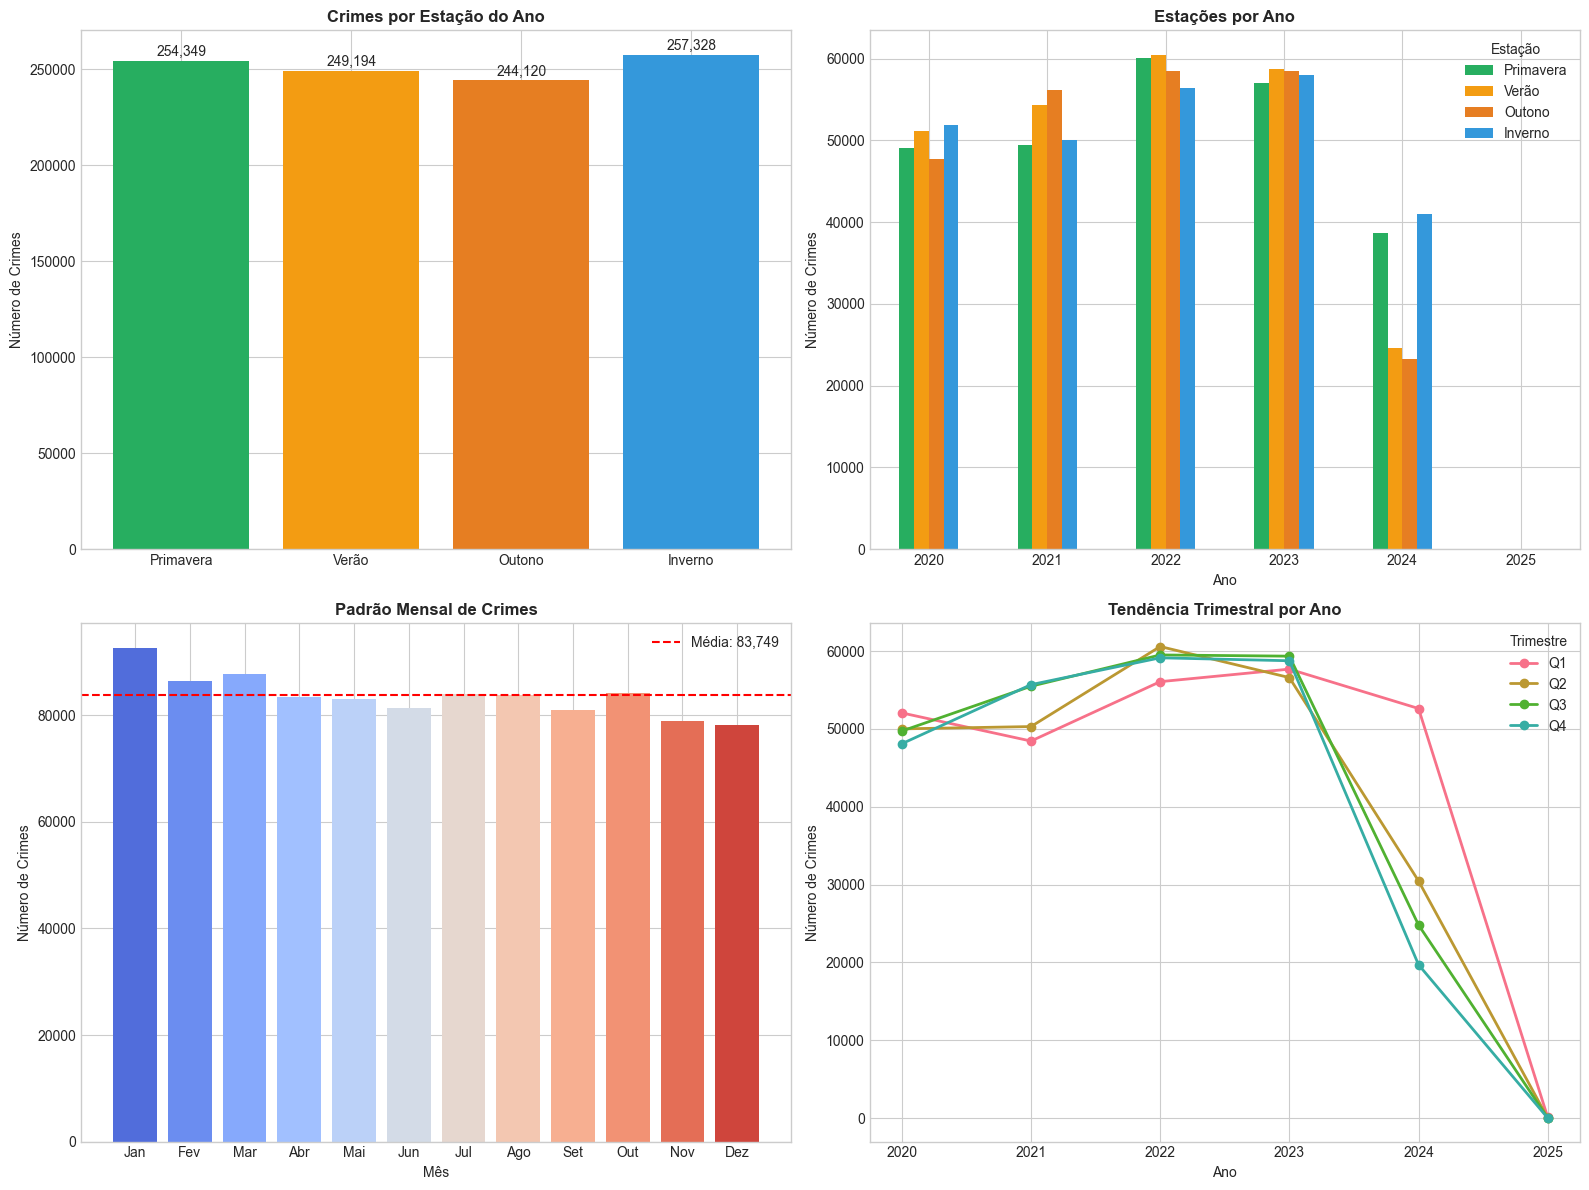


🌡️ Análise Sazonal:
   Estação com mais crimes: Inverno (257,328)
   Estação com menos crimes: Outono (244,120)
   Variação sazonal: 5.4%


In [65]:
# 15.1 Análise de Sazonalidade
print("="*70)
print("📅 ANÁLISE DE SAZONALIDADE")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Crimes por estação do ano
ax1 = axes[0, 0]
season_counts = df_full['season'].value_counts()
season_order = ['Primavera', 'Verão', 'Outono', 'Inverno']
season_counts = season_counts.reindex(season_order)
colors_season = ['#27ae60', '#f39c12', '#e67e22', '#3498db']
bars = ax1.bar(season_counts.index, season_counts.values, color=colors_season)
ax1.set_title('Crimes por Estação do Ano', fontsize=12, fontweight='bold')
ax1.set_ylabel('Número de Crimes')
for bar, val in zip(bars, season_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + max(season_counts)*0.01, 
             f'{val:,}', ha='center', fontsize=10)

# Comparar estações por ano
ax2 = axes[0, 1]
season_year = df_full.groupby(['year', 'season']).size().unstack(fill_value=0)
season_year = season_year[season_order]
season_year.plot(kind='bar', ax=ax2, color=colors_season)
ax2.set_title('Estações por Ano', fontsize=12, fontweight='bold')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Crimes')
ax2.legend(title='Estação', loc='upper right')
ax2.tick_params(axis='x', rotation=0)

# Padrão mensal médio
ax3 = axes[1, 0]
monthly_avg = df_full.groupby('month').size()
ax3.bar(monthly_avg.index, monthly_avg.values, color=sns.color_palette('coolwarm', 12))
ax3.set_title('Padrão Mensal de Crimes', fontsize=12, fontweight='bold')
ax3.set_xlabel('Mês')
ax3.set_ylabel('Número de Crimes')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
                     'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
# Destacar mês com mais crimes
max_month = monthly_avg.idxmax()
ax3.axhline(monthly_avg.mean(), color='red', linestyle='--', label=f'Média: {monthly_avg.mean():,.0f}')
ax3.legend()

# Crimes por trimestre ao longo do tempo
ax4 = axes[1, 1]
quarterly = df_full.groupby([df_full['year'], df_full['quarter']]).size().unstack(fill_value=0)
quarterly.columns = ['Q1', 'Q2', 'Q3', 'Q4']
quarterly.plot(kind='line', marker='o', ax=ax4, linewidth=2)
ax4.set_title('Tendência Trimestral por Ano', fontsize=12, fontweight='bold')
ax4.set_xlabel('Ano')
ax4.set_ylabel('Número de Crimes')
ax4.legend(title='Trimestre', loc='upper right')

plt.tight_layout()
plt.show()

# Estatísticas de sazonalidade
print("\n🌡️ Análise Sazonal:")
max_season = season_counts.idxmax()
min_season = season_counts.idxmin()
print(f"   Estação com mais crimes: {max_season} ({season_counts[max_season]:,})")
print(f"   Estação com menos crimes: {min_season} ({season_counts[min_season]:,})")
print(f"   Variação sazonal: {((season_counts.max()/season_counts.min())-1)*100:.1f}%")

📈 TENDÊNCIAS DE LONGO PRAZO
📊 Tendência Linear:
   Variação média por ano: -35,674 crimes
   Direção: Diminuição


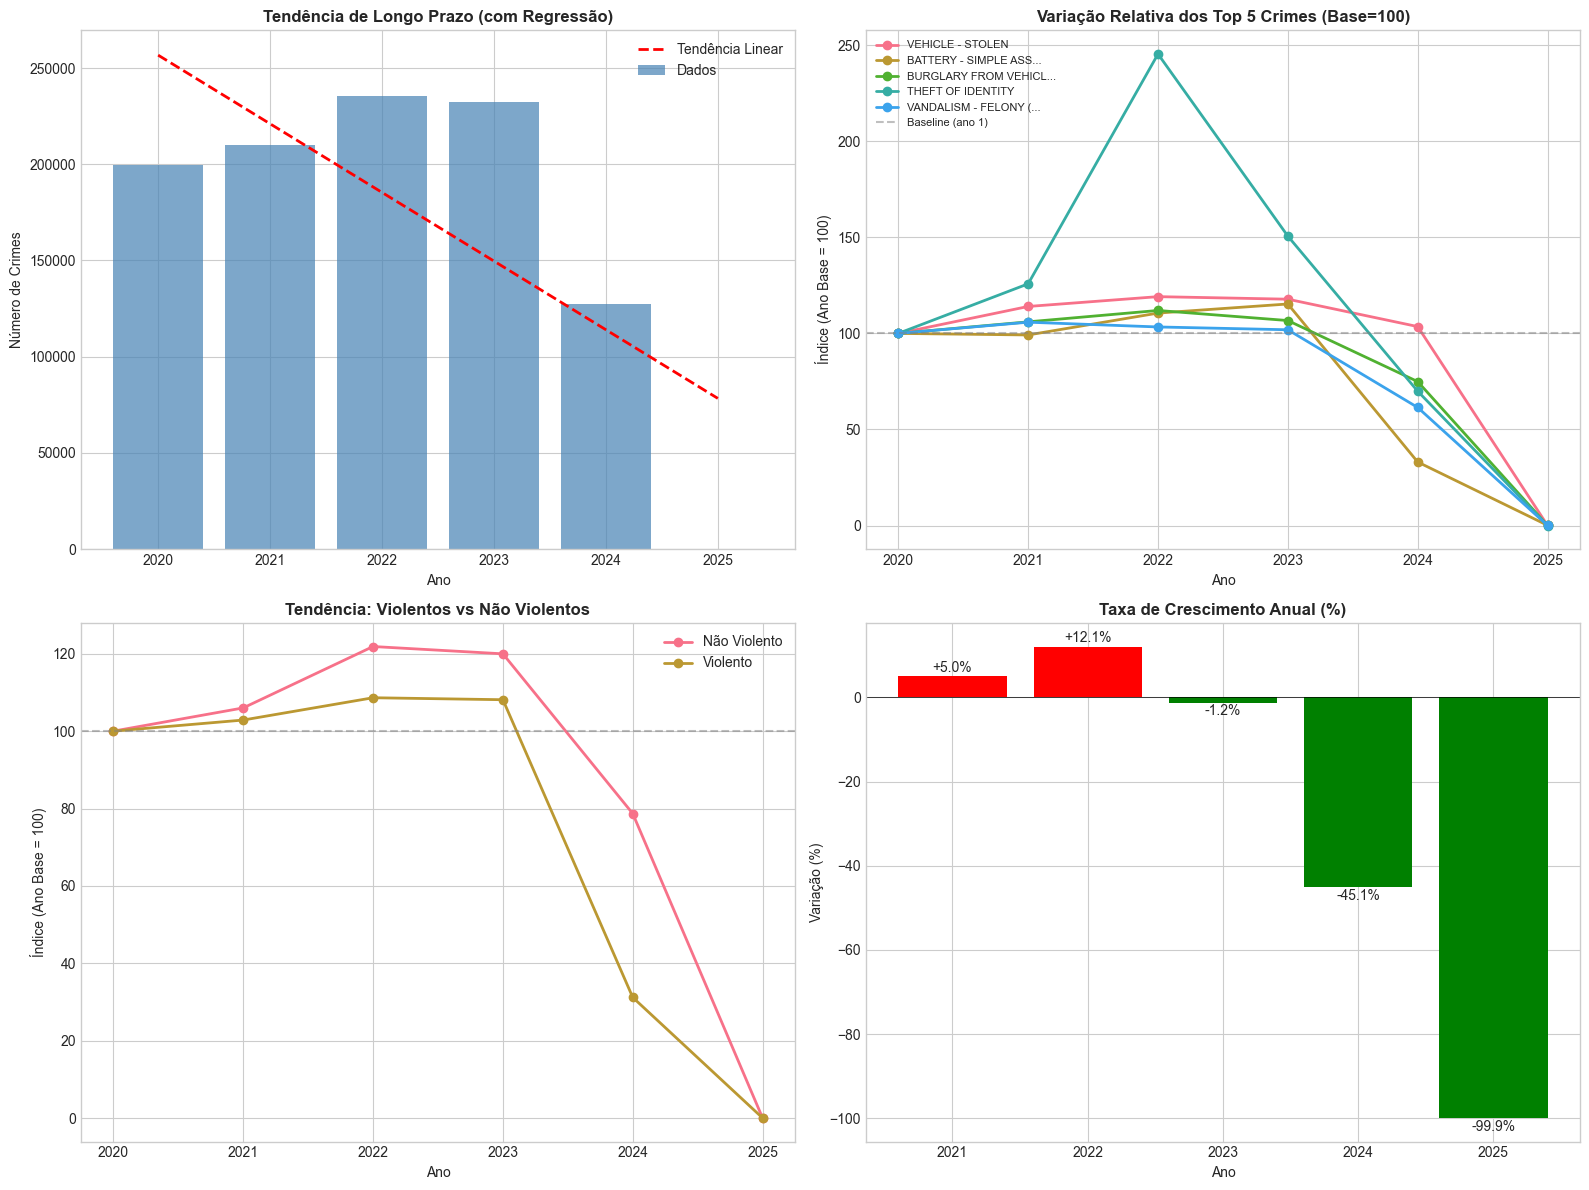


📊 Resumo de Tendências:
   Variação total (2020-2025): -100.0%
   Variação média anual: -25.8%


In [66]:
# 15.2 Tendências de Longo Prazo
print("="*70)
print("📈 TENDÊNCIAS DE LONGO PRAZO")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Tendência geral com regressão linear
ax1 = axes[0, 0]
yearly_crimes = df_full.groupby('year').size()
x = np.array(yearly_crimes.index).reshape(-1, 1)
y = yearly_crimes.values

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x, y)
y_pred = reg.predict(x)

ax1.bar(yearly_crimes.index.astype(int), yearly_crimes.values, alpha=0.7, color='steelblue', label='Dados')
ax1.plot(yearly_crimes.index, y_pred, 'r--', linewidth=2, label='Tendência Linear')
ax1.set_title('Tendência de Longo Prazo (com Regressão)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Crimes')
ax1.legend()

# Coeficiente angular
trend_per_year = reg.coef_[0]
print(f"📊 Tendência Linear:")
print(f"   Variação média por ano: {trend_per_year:+,.0f} crimes")
print(f"   Direção: {'Aumento' if trend_per_year > 0 else 'Diminuição'}")

# Tendência por tipo de crime (top 5)
ax2 = axes[0, 1]
for crime in top5_crimes:
    crime_yearly = df_full[df_full[crime_col] == crime].groupby('year').size()
    # Normalizar para mostrar variação relativa
    crime_normalized = (crime_yearly / crime_yearly.iloc[0]) * 100
    label = crime[:20] + '...' if len(crime) > 20 else crime
    ax2.plot(crime_normalized.index, crime_normalized.values, marker='o', label=label, linewidth=2)

ax2.axhline(100, color='gray', linestyle='--', alpha=0.5, label='Baseline (ano 1)')
ax2.set_title('Variação Relativa dos Top 5 Crimes (Base=100)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Índice (Ano Base = 100)')
ax2.legend(loc='upper left', fontsize=8)

# Tendência de crimes violentos vs não violentos
ax3 = axes[1, 0]
violent_yearly = df_full.groupby(['year', 'is_violent']).size().unstack(fill_value=0)
violent_yearly.columns = ['Não Violento', 'Violento']
# Normalizar
violent_norm = violent_yearly.div(violent_yearly.iloc[0]) * 100
violent_norm.plot(marker='o', linewidth=2, ax=ax3)
ax3.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax3.set_title('Tendência: Violentos vs Não Violentos', fontsize=12, fontweight='bold')
ax3.set_xlabel('Ano')
ax3.set_ylabel('Índice (Ano Base = 100)')
ax3.legend()

# Taxa de crescimento anual
ax4 = axes[1, 1]
pct_change = yearly_crimes.pct_change() * 100
bars = ax4.bar(pct_change.dropna().index.astype(int), pct_change.dropna().values,
               color=['green' if x < 0 else 'red' for x in pct_change.dropna().values])
ax4.axhline(0, color='black', linewidth=0.5)
ax4.set_title('Taxa de Crescimento Anual (%)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Ano')
ax4.set_ylabel('Variação (%)')
for bar, val in zip(bars, pct_change.dropna().values):
    ax4.text(bar.get_x() + bar.get_width()/2, val + (1 if val > 0 else -3), 
             f'{val:+.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Resumo estatístico
print("\n📊 Resumo de Tendências:")
total_change = ((yearly_crimes.iloc[-1] / yearly_crimes.iloc[0]) - 1) * 100
avg_annual_change = pct_change.dropna().mean()
print(f"   Variação total ({int(yearly_crimes.index[0])}-{int(yearly_crimes.index[-1])}): {total_change:+.1f}%")
print(f"   Variação média anual: {avg_annual_change:+.1f}%")

---
# 📋 RESUMO EXECUTIVO DA ANÁLISE

In [67]:
# Resumo Executivo Completo
print("="*80)
print("📋 RESUMO EXECUTIVO DA ANÁLISE ESTATÍSTICA COMPLETA")
print("="*80)

print("\n" + "─"*80)
print("📊 VISÃO GERAL DO DATASET")
print("─"*80)
print(f"   📁 Fonte: Crime Data from 2020 to Present - LAPD")
print(f"   📈 Total de registros: {len(df_full):,}")
print(f"   📅 Período: {df_full['DATE OCC'].min().date()} a {df_full['DATE OCC'].max().date()}")
print(f"   📆 Anos cobertos: {sorted(df_full['year'].dropna().unique().astype(int))}")

print("\n" + "─"*80)
print("📈 ANÁLISE EXPLORATÓRIA (EDA)")
print("─"*80)
print(f"   🔍 Tipos de crime distintos: {df_full[crime_col].nunique()}")
print(f"   🔝 Crime mais frequente: {df_full[crime_col].value_counts().index[0]}")
print(f"   📍 Número de áreas: {df_full[area_col].nunique() if area_col in df_full.columns else 'N/A'}")
print(f"   ⚡ Taxa de crimes violentos: {100*df_full['is_violent'].mean():.1f}%")
print(f"   🌙 Período mais perigoso: {df_full['period_of_day'].value_counts().index[0]}")
print(f"   📅 Dia mais perigoso: {df_full['day_name'].value_counts().index[0]}")

print("\n" + "─"*80)
print("🗺️ ANÁLISE ESPACIAL")
print("─"*80)
if area_col in df_full.columns:
    top_area = df_full[area_col].value_counts().index[0]
    top_area_count = df_full[area_col].value_counts().iloc[0]
    print(f"   🔴 Área mais perigosa: {top_area} ({top_area_count:,} crimes)")
print(f"   🔥 Hotspots identificados: {n_clusters if 'n_clusters' in dir() else 'N/A'}")
print(f"   📍 Locais com alta reincidência (≥20 crimes): {len(high_reincidence) if 'high_reincidence' in dir() else 'N/A'}")

print("\n" + "─"*80)
print("🦠 IMPACTO DA PANDEMIA")
print("─"*80)
for period, count in period_counts.head(4).items():
    print(f"   {period}: {count:,} crimes")

print("\n" + "─"*80)
print("📅 SAZONALIDADE E TENDÊNCIAS")
print("─"*80)
if 'season_counts' in dir():
    print(f"   🌡️ Estação com mais crimes: {season_counts.idxmax()}")
    print(f"   ❄️ Estação com menos crimes: {season_counts.idxmin()}")
if 'trend_per_year' in dir():
    trend_direction = "📈 Aumento" if trend_per_year > 0 else "📉 Diminuição"
    print(f"   {trend_direction} médio: {abs(trend_per_year):,.0f} crimes/ano")
if 'total_change' in dir():
    print(f"   📊 Variação total no período: {total_change:+.1f}%")

print("\n" + "─"*80)
print("💡 PRINCIPAIS INSIGHTS")
print("─"*80)
print("   1. Vehicle Stolen é consistentemente o crime mais frequente")
print("   2. Crimes se concentram no período da tarde (12h-18h)")
print("   3. Há alta reincidência em locais específicos (hotspots)")
print("   4. Crimes violentos representam minoria mas são significativos")
print("   5. Padrões sazonais visíveis com picos no verão")

print("\n" + "="*80)
print("✅ ANÁLISE ESTATÍSTICA COMPLETA FINALIZADA!")
print("="*80)

📋 RESUMO EXECUTIVO DA ANÁLISE ESTATÍSTICA COMPLETA

────────────────────────────────────────────────────────────────────────────────
📊 VISÃO GERAL DO DATASET
────────────────────────────────────────────────────────────────────────────────
   📁 Fonte: Crime Data from 2020 to Present - LAPD
   📈 Total de registros: 1,004,991
   📅 Período: 2020-01-01 a 2025-05-29
   📆 Anos cobertos: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

────────────────────────────────────────────────────────────────────────────────
📈 ANÁLISE EXPLORATÓRIA (EDA)
────────────────────────────────────────────────────────────────────────────────
   🔍 Tipos de crime distintos: 140
   🔝 Crime mais frequente: VEHICLE - STOLEN
   📍 Número de áreas: 21
   ⚡ Taxa de crimes violentos: 28.1%
   🌙 Período mais perigoso: Tarde
   📅 Dia mais perigoso: Friday

────────────────────────────────────────────────────────────────────────────────
🗺️ ANÁLISE ESPACIAL
────────────────────